# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Configuration

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device('cpu')

ROLLOUT_LENGTH = 250 
DISCOUNT = 0.99
GAE_LAMBDA = 0.95
OPTIMIZATION_EPOCHS = 10
MINI_BATCH_SIZE = 64
PPO_RATIO_CLIP = 0.1
GRADIENT_CLIP = 0.75
HIDDEN_LAYERS = 80

### Third-party Code
These are helper routines copied or adapted from other projects.

In [6]:
# Thank you for these helper routines to Shangtong Zhang 
# https://github.com/ShangtongZhang/DeepRL

def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

def to_np(t):
    return t.cpu().detach().numpy()

def tensor(x):
    if isinstance(x, torch.Tensor):
        return x
    x = torch.tensor(x, device=DEVICE, dtype=torch.float32)
    return x

def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]

class MeanStdNormalizer():
    def __init__(self):
        self.rms = None
        self.clip = 10.0
        self.epsilon = 1e-8

    def __call__(self, x):
        x = np.asarray(x)
        if self.rms is None:
            self.rms = RunningMeanStd(shape=(1, ) + x.shape[1:])
        self.rms.update(x)
        return np.clip((x - self.rms.mean) / np.sqrt(self.rms.var + self.epsilon),
                       -self.clip, self.clip)    


In [7]:
# Thank you for these helper routines to OpenAI.

# https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py    
class RunningMeanStd(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)    
        
def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count
                

### The Master Agent

The master agent implements the PPO algorithm and can use multiple sub-agents for the purpose of samlping trajectories.

In [8]:
import random
from collections import namedtuple, deque

class SubNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_units, output_size, seed):
        super(SubNetwork, self).__init__()
        dims = (input_size,) + hidden_units        
        self.layers = nn.ModuleList([layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.feature_dim = dims[-1]
        self.output_layer = layer_init(nn.Linear(self.feature_dim, output_size), 1e-3)
        
    def forward(self, x):
        for layer in self.layers:
            x = F.tanh(layer(x))
        x = self.output_layer(x)    
        return x    
            
class ActorAndCritic(nn.Module):
    
    def __init__(self, num_agents, state_size, action_size, seed):
        super(ActorAndCritic, self).__init__()
        self.seed = random.seed(seed)
        self.actor = SubNetwork(state_size, (HIDDEN_LAYERS, HIDDEN_LAYERS), action_size, seed)
        self.critic = SubNetwork(state_size, (HIDDEN_LAYERS, HIDDEN_LAYERS), 1, seed)
        self.std = nn.Parameter(torch.zeros(action_size))
        #self.to(Config.DEVICE)
        
    def forward(self, obs, action=None):
        obs = tensor(obs)
        a = self.actor(obs)
        v = self.critic(obs)
        mean = F.tanh(a)
        dist = torch.distributions.Normal(mean, F.softplus(self.std))
        return (v, dist)
        
class Rollout():
    
    def __init__(self):
        # Stored values
        self.actions = []
        self.log_prob_actions = []
        self.values = []
        self.rewards = []
        self.episode_not_dones = []
        self.states = []
        # Calculated values
        self.returns = [0.0] * ROLLOUT_LENGTH
        self.advantages = [0.0] * ROLLOUT_LENGTH
        
    def save_prediction(self, actions, log_prob_actions, values):
        self.actions.append(actions)
        self.log_prob_actions.append(log_prob_actions)
        self.values.append(values)

    def save_consequences(self, rewards, episode_not_dones, states):
        self.rewards.append(rewards)
        self.episode_not_dones.append(episode_not_dones)
        self.states.append(states)
        
    def calculate_returns_and_advantages(self, final_reward):
        self.rewards.append(None)
        self.episode_not_dones.append(None)
        self.calculate_future_returns(final_reward)
        self.estimate_advantages()

    def calculate_future_returns(self, returns):
        for i in reversed(range(ROLLOUT_LENGTH)):
            returns = self.rewards[i] + DISCOUNT * self.episode_not_dones[i] * returns
            self.returns[i] = returns.detach() 

    def estimate_advantages(self):
        advantages = tensor(np.zeros((num_agents, 1)))
        # Go backwards through rollout steps and calculate advantages for each state action pair
        # Use GAE for PPO. (Schulman, Moritz, Levine et al. 2016)
        for i in reversed(range(ROLLOUT_LENGTH)):
            td = self.rewards[i] + (DISCOUNT * self.episode_not_dones[i] * self.values[i + 1]) - self.values[i]
            advantages = advantages * GAE_LAMBDA * DISCOUNT * self.episode_not_dones[i] + td
            self.advantages[i] = advantages.detach()               

    def stack_tensor(self, some_list):
        return torch.cat(some_list[:ROLLOUT_LENGTH], dim=0)
            
    def get_sample_data(self):
        states = self.stack_tensor(self.states)
        actions = self.stack_tensor(self.actions) 
        log_prob_actions = self.stack_tensor(self.log_prob_actions)
        returns = self.stack_tensor(self.returns)
        # Normalize advantages
        advantages = self.stack_tensor(self.advantages)
        advantages = (advantages - advantages.mean()) / advantages.std()        
        return (states, actions, log_prob_actions, returns, advantages)
    
class MasterAgent():   
    
    def __init__(self, num_agents, state_size, action_size, seed):
        self.network = ActorAndCritic(num_agents, state_size, action_size, seed)
        self.first_states = True
        self.total_steps = 0
        self.state_normalizer = MeanStdNormalizer()
        
    def evaluate_actions_against_states(self, states, actions):
        value, action_distribution = self.network(states, actions)
        log_prob = self.get_log_prob(action_distribution, actions)
        return (log_prob, value)
    
    def get_log_prob(self, action_distribution, actions):
        return action_distribution.log_prob(actions).sum(-1).unsqueeze(-1)
    
    def get_prediction(self, states):
        if self.first_states:
            self.states = states
            self.first_states = False
        #self.latest_actions, self.latest_log_prob, self.latest_values = self.get_prediction_from_states(self.states)
        self.latest_values, action_distribution = self.network(self.states)
        self.latest_actions = action_distribution.sample()
        self.latest_log_prob = self.get_log_prob(action_distribution, self.latest_actions)
        return self.latest_actions
    
    def step(self, states, actions, rewards, next_states, dones):
        rewards = np.asarray(rewards)
        next_states = self.state_normalizer(next_states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
        dones = np.asarray(dones).astype(int)
        rewards = tensor(rewards).unsqueeze(-1)
        episode_not_dones = tensor(1 - dones).unsqueeze(-1)
        states = tensor(self.states)        
        self.rollout.save_consequences(rewards, episode_not_dones, states)

        self.states = next_states
                
    def start_rollout(self):
        self.rollout = Rollout()
            
    def process_rollout(self, states):
        self.save_final_results(states)
        self.rollout.calculate_returns_and_advantages(self.latest_values.detach())
        self.optimize()
        self.first_states = True
        
    def save_final_results(self, states):    
        self.get_prediction(states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
   
    def save_weights(self):
        print("======== Saving weights ==========")
        torch.save(self.network.state_dict(), "trained_weights.pth")

    def optimize(self):
        # Now use tensors for 's', 'a', 'log_pi_a', 'ret', 'adv' for training
        # states, actions, log prob actions, returns, advantages (1 row / timestep, 1 column per worker)

        states, actions, log_probs_old, returns, advantages = self.rollout.get_sample_data()
        actions = actions.detach()
        log_probs_old = log_probs_old.detach()
        optimizer = torch.optim.Adam(self.network.parameters(), 3e-4, eps=1e-5)
        for i in range(OPTIMIZATION_EPOCHS):
            number_timesteps = states.size(0)
            timesteps_to_sample = random_sample(np.arange(number_timesteps), MINI_BATCH_SIZE) 
            for timestep in timesteps_to_sample:
                t = tensor(timestep).long()
                # Get data for all workers from sampled timestep 
                sampled_states = states[t]
                sampled_actions = actions[t]
                sampled_log_probs_old = log_probs_old[t]
                sampled_returns = returns[t]
                sampled_advantages = advantages[t]
                self.optimize_with_sampled_worker_data(optimizer, sampled_states,
                                                                  sampled_actions,
                                                                  sampled_log_probs_old,
                                                                  sampled_returns,
                                                                  sampled_advantages)
        steps = ROLLOUT_LENGTH * num_agents
        # Total steps used to train network
        self.total_steps += steps
        
    def optimize_with_sampled_worker_data(self, optimizer, sampled_states, sampled_actions, sampled_log_probs_old, sampled_returns, sampled_advantages):
        # Get log_prob(actions) and value given states
        # Pass in states for all workers x batch_size.
        log_prob_action, value = self.evaluate_actions_against_states(sampled_states, sampled_actions)
        
        policy_loss = self.get_policy_loss(log_prob_action, sampled_log_probs_old, sampled_advantages)
        value_loss = self.get_value_loss(value, sampled_returns)
        
        # Do the actual optimization
        optimizer.zero_grad()
        # Overall loss function for training both networks at once. Get gradients on weights.
        (policy_loss + value_loss).backward()
        # Clip weight gradients 
        nn.utils.clip_grad_norm_(self.network.parameters(), GRADIENT_CLIP) 
        # Run actual optimization
        optimizer.step()
        
    def get_policy_loss(self, log_prob_action, sampled_log_probs_old, sampled_advantages):
        # This is the core of PPO
        # ratio = new prob / old prob for all workers
        ratio = (log_prob_action - sampled_log_probs_old).exp() 
        # Clip loss on the upside
        clamped_ratio = ratio.clamp(1.0 - PPO_RATIO_CLIP, 1.0 + PPO_RATIO_CLIP)
        obj = ratio * sampled_advantages
        obj_clipped = clamped_ratio * sampled_advantages
        policy_loss = -torch.min(obj, obj_clipped).mean() 
        return policy_loss
    
    def get_value_loss(self, value, sampled_returns):
        # Mean squared error
        value_loss = 0.5 * (sampled_returns - value).pow(2).mean()
        return value_loss


### Training

The TrainingSession class trains the agent while monitoring the progress of the episodes. It can also simply run an episode with the previously trained policy.

In [9]:
class TrainingSession():
    
    def __init__(self, num_workers):
        self.num_workers = num_workers
        self.online_rewards = np.zeros(num_workers)
        self.mean_last_100 = 0
        self.mean_scores = []

    def train_ppo(self, agent, target_average_score, max_episodes=300, print_every=1):
        print("Attempting to reach 100 episode trailing average of {:.2f} in under {} episodes.".format(target_average_score, max_episodes))
        print("ROLLOUT_LENGTH: %s" % ROLLOUT_LENGTH)
        print("GRADIENT_CLIP %s" % GRADIENT_CLIP)
        print("PPO_RATIO_CLIP %s" % PPO_RATIO_CLIP)
        print("GAE_LAMBDA %s" % GAE_LAMBDA)
        print("HIDDEN LAYERS %s" % HIDDEN_LAYERS)
        # TODO: Implement print_every
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment   
        self.num_episodes = 0
        self.last_100_scores = deque(maxlen=100)
        self.episode_scores = [list() for i in range(num_agents)]
        self.episodes_finished = 0
        self.target_average_score = target_average_score
        while True:
            mean_last_100 = self.run_rollout(agent, env_info, print_every=print_every)
            agent.process_rollout(states)
            
            #print("\rEpisode {}\tLast 100: {:.2f}".format(self.num_episodes, mean_last_100))
            if (len(self.mean_scores)>=100) and (mean_last_100 > target_average_score):
                print("Reached target! mean_last_100 %s" % mean_last_100)
                agent.save_weights() 
                break
            if self.num_episodes > max_episodes:
                print("Failed to reach target in {} episodes.".format(self.num_episodes))
                break
        return (self.mean_scores, mean_last_100, self.num_episodes) 
    
    def get_actions_from_policy(self, states):
        actions = agent.get_prediction(states)          # Run the policy 
        actions = to_np(actions)                        # Extract actions
        actions = np.clip(actions, -1, 1)               # all actions between -1 and 1
        return actions
    
    def run_ppo(self, agent, max_episodes=5):
        env_info = env.reset(train_mode=False)[brain_name]
        self.last_100_scores = deque(maxlen=100)
        self.num_episodes = 0
        while True:
            mean_score_over_agents = self.run_rollout(agent, env_info)
            self.num_episodes += 1
            if self.num_episodes > max_episodes:
                print("Policy failed to reach target in %s" % max_episodes)
                break
    
    def step_environment(self, env, actions):
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment        
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished for each agent
        return (next_states, rewards, dones)
                                
    def run_episode(self, env_info):
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.start_rollout()
        while True:
            actions = self.get_actions_from_policy(states)
            next_states, rewards, dones = self.step_environment(env, actions)
            
    def run_rollout(self, agent, env_info, print_every=1):
        #print("Run rollout")
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.start_rollout()
        for t in range(ROLLOUT_LENGTH):
            actions = self.get_actions_from_policy(states)            
            next_states, rewards, dones = self.step_environment(env, actions)
        
            # Save rewards
            self.online_rewards += rewards                          # Accumulate ongoing (un-normalized) rewards for each agent
            for i, done in enumerate(dones):
                if done:                                       # For a worker whose episode is done...
                    #print("Worker %s finished at timestep %s" % (i, t))
                    self.end_episode(i, self.online_rewards[i], print_every=print_every)
                    env_info = env.reset(train_mode=True)[brain_name]
                    #print("t = %s" % t)
                    self.online_rewards[i] = 0                 # Reset accumulated reward for next episode
                    self.mean_last_100 = np.mean(self.last_100_scores)
                    if self.mean_last_100 > self.target_average_score:
                        print("Breaking")
                        break
            #print("%s step" % t)            
            agent.step(states, actions, rewards, next_states, dones) # Teach the agent 
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step

        #print("Steps in rollout: {}".format(t+1))        
        return self.mean_last_100    

    def end_episode(self, agent_index, score, print_every=1):
        self.episode_scores[agent_index].append(score)   # Save the reward they accumulated in the episode
        self.episodes_finished +=1
        if (self.episodes_finished % num_agents) == 0:
            self.num_episodes += 1
            total_over_agents = 0
            best_score = -10000.0
            for i in range(num_agents):
                #total_over_agents += self.episode_scores[i][-1]
                agent_score = self.episode_scores[i][-1]
                best_score = agent_score if agent_score > best_score else best_score
            mean_score_over_agents = total_over_agents / num_agents 
            #self.last_100_scores.append(mean_score_over_agents)
            self.last_100_scores.append(best_score)
            self.mean_scores.append(best_score)
            #self.mean_scores.append(mean_score_over_agents)
            if (print_every!=0) and ((self.num_episodes % print_every) == 0):
                print("Finished %s episodes (%s cycles). best score over agents %8.3f trailing %8.3f" % (self.num_episodes, (self.episodes_finished/num_agents), best_score, np.mean(self.last_100_scores)))


### Hyperparameter Search

In [10]:
# Thanks to blog post on hyperparameter search
# https://people.eecs.berkeley.edu/~kjamieson/hyperband.html

# Number of trials to take before calculating value loss
NUMBER_TRIALS = 3

from math import log, ceil
from statistics import mean
import time
import datetime

def get_random_hyperparameter_configuration():
    # Add hyperparameters here that need randomizing
    # [[Name, Min value, Max value, type], .....]
    hyperparameters = [["ROLLOUT_LENGTH", 50, 1000, "int"],
                       ["HIDDEN_LAYERS",16, 512, "int"],
                      ]
    selection = {}
    for hyperparameter in hyperparameters:
        name = hyperparameter[0]
        min_value = hyperparameter[1]
        max_value = hyperparameter[2]
        value_type = hyperparameter[3]
        value = random.uniform(min_value, max_value)
        value = int(value) if value_type=="int" else value
        selection[name] = value
    return selection   

def run_then_return_val_loss(num_iters=10000, hyperparameters={}):
    global agent
    
    num_iters = int(num_iters)
    print("--------run_then_return_val_loss for %s iterations at %s-----------" % (num_iters, hyperparameters))
    set_hyperparameters(hyperparameters)
    val_losses = []
    
    for i in range(NUMBER_TRIALS):
        agent = MasterAgent(num_agents, state_size=state_size, action_size=action_size, seed=0)
        session = TrainingSession(num_agents)
        print("Running training session %s with max %s iterations" % (i, num_iters))
        scores, mean_last_100, num_episodes = session.train_ppo(agent, 0.5, max_episodes=num_iters, print_every=500)
        score = 0 if mean_last_100 < 0.5 else (3000-num_episodes)*0.005
        score = score + mean_last_100
        val_loss = -score
        val_losses.append(val_loss)
        print("Value loss %8.2f" % val_loss)
    mean_value_loss = np.mean(np.asarray(val_losses))  
    print("Mean value loss %8.3f" % mean_value_loss)
    return mean_value_loss

def set_hyperparameters(hyperparameters):
    global ROLLOUT_LENGTH, DISCOUNT, GAE_LAMBDA, OPTIMIZATION_EPOCHS, MINI_BATCH_SIZE
    global PPO_RATIO_CLIP, GRADIENT_CLIP, HIDDEN_LAYERS

    for key in hyperparameters.keys():
        assignment = key + " = " + str(hyperparameters[key])
        exec(assignment, globals())
    print("ASSIGNED ROLLOUT_LENGTH %s" % ROLLOUT_LENGTH)        
    
def search_for_best_hyperparameters():
    start_time = time.time()
    max_iter = 3000 # 81  # maximum iterations/epochs per configuration
    eta = 3 # defines downsampling rate (default=3)
    logeta = lambda x: log(x)/log(eta)
    s_max = int(logeta(max_iter))  # number of unique executions of Successive Halving (minus one)
    B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of Succesive Halving (n,r)
    print("s_max %8.2f B %8.2f" % (s_max, B))
    
    #### Begin Finite Horizon Hyperband outlerloop. Repeat indefinetely.
    for s in reversed(range(s_max+1)):
        print("====================== ")
        print("Outer loop s %8.2f" % s)
        n = int(ceil(int(B/max_iter/(s+1))*eta**s)) # initial number of configurations
        r = max_iter*eta**(-s) # initial number of iterations to run configurations for

        #### Begin Finite Horizon Successive Halving with (n,r)
        T = [ get_random_hyperparameter_configuration() for i in range(n) ] 
        print("n %s r %8.2f" % (n, r))
        print(T)
        for i in range(s+1):
            print("--------------------")
            print("Inner loop i = %s" % i)
            # Run each of the n_i configs for r_i iterations and keep best n_i/eta
            n_i = n*eta**(-i)
            r_i = r*eta**(i)
            val_losses = [ run_then_return_val_loss(num_iters=r_i,hyperparameters=t) for t in T ]
            print("val_losses")
            print(np.asarray(val_losses))
            T = [ T[i] for i in np.argsort(np.asarray(val_losses))[0:int( n_i/eta )] ]
            print("New T:")
            print(T)
        #### End Finite Horizon Successive Halving with (n,r)
    print("****************")
    print("Finished hyperparameter search")
    end_time = time.time()
    seconds = end_time - start_time
    print("Took %s" % str(datetime.timedelta(seconds=seconds)))
    print("****************")
    print(T)
    best_hyperparameters = T[0]
    set_hyperparameters(best_hyperparameters)

### Search for hyperparameters (optional)

In [ ]:
# Run the following line to do a full hyper-parameter search
# Otherwise, defaults defined above will be used.
search_for_best_hyperparameters()

s_max     7.00 B 24000.00
Outer loop s     7.00
n 2187 r     1.37
[{'ROLLOUT_LENGTH': 521, 'HIDDEN_LAYERS': 277}, {'ROLLOUT_LENGTH': 55, 'HIDDEN_LAYERS': 469}, {'ROLLOUT_LENGTH': 690, 'HIDDEN_LAYERS': 284}, {'ROLLOUT_LENGTH': 655, 'HIDDEN_LAYERS': 123}, {'ROLLOUT_LENGTH': 798, 'HIDDEN_LAYERS': 412}, {'ROLLOUT_LENGTH': 543, 'HIDDEN_LAYERS': 195}, {'ROLLOUT_LENGTH': 705, 'HIDDEN_LAYERS': 364}, {'ROLLOUT_LENGTH': 928, 'HIDDEN_LAYERS': 30}, {'ROLLOUT_LENGTH': 739, 'HIDDEN_LAYERS': 196}, {'ROLLOUT_LENGTH': 671, 'HIDDEN_LAYERS': 132}, {'ROLLOUT_LENGTH': 337, 'HIDDEN_LAYERS': 103}, {'ROLLOUT_LENGTH': 532, 'HIDDEN_LAYERS': 41}, {'ROLLOUT_LENGTH': 352, 'HIDDEN_LAYERS': 287}, {'ROLLOUT_LENGTH': 718, 'HIDDEN_LAYERS': 266}, {'ROLLOUT_LENGTH': 635, 'HIDDEN_LAYERS': 91}, {'ROLLOUT_LENGTH': 144, 'HIDDEN_LAYERS': 452}, {'ROLLOUT_LENGTH': 502, 'HIDDEN_LAYERS': 382}, {'ROLLOUT_LENGTH': 415, 'HIDDEN_LAYERS': 333}, {'ROLLOUT_LENGTH': 80, 'HIDDEN_LAYERS': 120}, {'ROLLOUT_LENGTH': 404, 'HIDDEN_LAYERS': 486}

/anaconda2/envs/drlnd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda2/envs/drlnd/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Failed to reach target in 26 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 521
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 277
Failed to reach target in 34 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 521
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 277
Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 55, 'HIDDEN_LAYERS': 469}-----------
ASSIGNED ROLLOUT_LENGTH 55
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 55
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 469
Failed

Failed to reach target in 34 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 739
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 196
Failed to reach target in 38 episodes.
Value loss    -0.03
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 671, 'HIDDEN_LAYERS': 132}-----------
ASSIGNED ROLLOUT_LENGTH 671
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 671
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 132
Failed to reach target in 39 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 671
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 132
Fai

Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 415, 'HIDDEN_LAYERS': 333}-----------
ASSIGNED ROLLOUT_LENGTH 415
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 415
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 333
Failed to reach target in 25 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 415
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 333
Failed to reach target in 24 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 415
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 333
Fai

Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 298
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 501
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 298
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 501
Failed to reach target in 19 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 551, 'HIDDEN_LAYERS': 465}-----------
ASSIGNED ROLLOUT_LENGTH 551
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 551
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 465
Fai

Failed to reach target in 10 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 166
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 357
Failed to reach target in 7 episodes.
Value loss    -0.04
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 369, 'HIDDEN_LAYERS': 433}-----------
ASSIGNED ROLLOUT_LENGTH 369
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 369
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 433
Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 369
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 433
Fail

Failed to reach target in 16 episodes.
Value loss    -0.01
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 207, 'HIDDEN_LAYERS': 49}-----------
ASSIGNED ROLLOUT_LENGTH 207
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 207
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 49
Failed to reach target in 13 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 207
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 49
Failed to reach target in 10 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 207
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 49
Failed 

Failed to reach target in 4 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 64
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 156
Failed to reach target in 2 episodes.
Value loss    -0.05
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 64
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 156
Failed to reach target in 4 episodes.
Value loss    -0.00
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 459, 'HIDDEN_LAYERS': 315}-----------
ASSIGNED ROLLOUT_LENGTH 459
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 459
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 315
Failed t

Failed to reach target in 8 episodes.
Value loss    -0.04
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 181
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 302
Failed to reach target in 10 episodes.
Value loss    -0.01
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 88, 'HIDDEN_LAYERS': 95}-----------
ASSIGNED ROLLOUT_LENGTH 88
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 88
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 95
Failed to reach target in 4 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 88
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 95
Failed to re

Failed to reach target in 8 episodes.
Value loss    -0.01
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 480, 'HIDDEN_LAYERS': 499}-----------
ASSIGNED ROLLOUT_LENGTH 480
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 480
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 499
Failed to reach target in 31 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 480
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 499
Failed to reach target in 29 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 480
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 499
Fail

Failed to reach target in 20 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 333
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 329
Failed to reach target in 16 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 333
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 329
Failed to reach target in 21 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 590, 'HIDDEN_LAYERS': 434}-----------
ASSIGNED ROLLOUT_LENGTH 590
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 590
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 434
Fai

Failed to reach target in 22 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 415
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 264
Failed to reach target in 23 episodes.
Value loss    -0.01
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 359, 'HIDDEN_LAYERS': 376}-----------
ASSIGNED ROLLOUT_LENGTH 359
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 359
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 376
Failed to reach target in 19 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 359
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 376
Fai

Failed to reach target in 42 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 249, 'HIDDEN_LAYERS': 199}-----------
ASSIGNED ROLLOUT_LENGTH 249
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 249
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 199
Failed to reach target in 16 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 249
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 199
Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 249
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 199
Fai

Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 680
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 188
Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 680
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 188
Failed to reach target in 41 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 780, 'HIDDEN_LAYERS': 369}-----------
ASSIGNED ROLLOUT_LENGTH 780
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 780
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 369
Fai

Failed to reach target in 3 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 323
Failed to reach target in 4 episodes.
Value loss    -0.00
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 647, 'HIDDEN_LAYERS': 19}-----------
ASSIGNED ROLLOUT_LENGTH 647
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 647
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 19
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 647
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 19
Failed to

Failed to reach target in 16 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 855, 'HIDDEN_LAYERS': 286}-----------
ASSIGNED ROLLOUT_LENGTH 855
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 855
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 286
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 855
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 286
Failed to reach target in 50 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 855
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 286
Fai

Failed to reach target in 2 episodes.
Value loss    -0.05
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 66
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 191
Failed to reach target in 3 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 66
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 191
Failed to reach target in 3 episodes.
Value loss    -0.07
Mean value loss   -0.050
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 641, 'HIDDEN_LAYERS': 50}-----------
ASSIGNED ROLLOUT_LENGTH 641
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 641
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 50
Failed to 

Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 525
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 167
Failed to reach target in 32 episodes.
Value loss    -0.01
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 548, 'HIDDEN_LAYERS': 234}-----------
ASSIGNED ROLLOUT_LENGTH 548
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 548
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 548
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Fai

Failed to reach target in 42 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 170, 'HIDDEN_LAYERS': 475}-----------
ASSIGNED ROLLOUT_LENGTH 170
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 170
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 475
Failed to reach target in 10 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 170
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 475
Failed to reach target in 7 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 170
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 475
Fail

Failed to reach target in 4 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 58
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 376
Failed to reach target in 4 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 58
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 376
Failed to reach target in 3 episodes.
Value loss    -0.03
Mean value loss   -0.010
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 860, 'HIDDEN_LAYERS': 115}-----------
ASSIGNED ROLLOUT_LENGTH 860
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 860
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 115
Failed t

Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 525
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 294
Failed to reach target in 32 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 297, 'HIDDEN_LAYERS': 96}-----------
ASSIGNED ROLLOUT_LENGTH 297
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 297
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed to reach target in 16 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 297
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed

Failed to reach target in 27 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 651, 'HIDDEN_LAYERS': 106}-----------
ASSIGNED ROLLOUT_LENGTH 651
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Fai

Failed to reach target in 13 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 230
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 371
Failed to reach target in 13 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 230
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 371
Failed to reach target in 13 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 340, 'HIDDEN_LAYERS': 197}-----------
ASSIGNED ROLLOUT_LENGTH 340
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 340
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 197
Fai

Failed to reach target in 9 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 207
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 161
Failed to reach target in 11 episodes.
Value loss    -0.03
Mean value loss   -0.029
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 660, 'HIDDEN_LAYERS': 129}-----------
ASSIGNED ROLLOUT_LENGTH 660
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 660
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 129
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 660
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 129
Fail

Failed to reach target in 43 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 628, 'HIDDEN_LAYERS': 415}-----------
ASSIGNED ROLLOUT_LENGTH 628
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 628
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 415
Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 628
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 415
Failed to reach target in 39 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 628
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 415
Fai

Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 731
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 464
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 731
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 464
Failed to reach target in 41 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 519, 'HIDDEN_LAYERS': 161}-----------
ASSIGNED ROLLOUT_LENGTH 519
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 519
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 161
Fai

Failed to reach target in 35 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 734
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 353
Failed to reach target in 40 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 860, 'HIDDEN_LAYERS': 312}-----------
ASSIGNED ROLLOUT_LENGTH 860
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 860
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 312
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 860
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 312
Fai

Failed to reach target in 36 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 700, 'HIDDEN_LAYERS': 269}-----------
ASSIGNED ROLLOUT_LENGTH 700
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 700
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 269
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 700
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 269
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 700
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 269
Fai

Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 321
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 135
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 321
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 135
Failed to reach target in 21 episodes.
Value loss    -0.01
Mean value loss   -0.010
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 560, 'HIDDEN_LAYERS': 231}-----------
ASSIGNED ROLLOUT_LENGTH 560
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 560
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 231
Fai

Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 893
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 35
Failed to reach target in 54 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 996, 'HIDDEN_LAYERS': 303}-----------
ASSIGNED ROLLOUT_LENGTH 996
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 996
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 303
Failed to reach target in 58 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 996
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 303
Fail

Failed to reach target in 4 episodes.
Value loss    -0.05
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 423, 'HIDDEN_LAYERS': 480}-----------
ASSIGNED ROLLOUT_LENGTH 423
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 423
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 21 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 423
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 27 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 423
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Fail

Failed to reach target in 11 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 192
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 500
Failed to reach target in 9 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 192
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 500
Failed to reach target in 10 episodes.
Value loss    -0.03
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 954, 'HIDDEN_LAYERS': 155}-----------
ASSIGNED ROLLOUT_LENGTH 954
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 954
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 155
Fail

Failed to reach target in 37 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 706
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Failed to reach target in 45 episodes.
Value loss    -0.01
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 341, 'HIDDEN_LAYERS': 497}-----------
ASSIGNED ROLLOUT_LENGTH 341
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 341
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 497
Failed to reach target in 19 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 341
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 497
Fai

Failed to reach target in 46 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 306, 'HIDDEN_LAYERS': 253}-----------
ASSIGNED ROLLOUT_LENGTH 306
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 306
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 253
Failed to reach target in 19 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 306
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 253
Failed to reach target in 22 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 306
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 253
Fai

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 718
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 134
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 718
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 134
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 676, 'HIDDEN_LAYERS': 325}-----------
ASSIGNED ROLLOUT_LENGTH 676
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 676
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 325
Fai

Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 665
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Failed to reach target in 34 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 765, 'HIDDEN_LAYERS': 447}-----------
ASSIGNED ROLLOUT_LENGTH 765
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 765
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 447
Failed to reach target in 35 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 765
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 447
Fai

Failed to reach target in 10 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 286, 'HIDDEN_LAYERS': 319}-----------
ASSIGNED ROLLOUT_LENGTH 286
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 319
Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 319
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 319
Fai

Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 276
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 477
Failed to reach target in 13 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 276
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 477
Failed to reach target in 15 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 757, 'HIDDEN_LAYERS': 287}-----------
ASSIGNED ROLLOUT_LENGTH 757
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 757
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 287
Fai

Failed to reach target in 15 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 285
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 456
Failed to reach target in 14 episodes.
Value loss    -0.03
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 542, 'HIDDEN_LAYERS': 132}-----------
ASSIGNED ROLLOUT_LENGTH 542
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 542
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 132
Failed to reach target in 33 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 542
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 132
Fai

Failed to reach target in 57 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 645, 'HIDDEN_LAYERS': 405}-----------
ASSIGNED ROLLOUT_LENGTH 645
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 645
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 405
Failed to reach target in 32 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 645
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 405
Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 645
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 405
Fai

Failed to reach target in 19 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 321
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 397
Failed to reach target in 15 episodes.
Value loss    -0.04
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 321
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 397
Failed to reach target in 18 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 259, 'HIDDEN_LAYERS': 303}-----------
ASSIGNED ROLLOUT_LENGTH 259
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 259
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 303
Fai

Failed to reach target in 12 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 225
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 33
Failed to reach target in 14 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 511, 'HIDDEN_LAYERS': 234}-----------
ASSIGNED ROLLOUT_LENGTH 511
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 511
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Failed to reach target in 25 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 511
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Fail

Failed to reach target in 60 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 306, 'HIDDEN_LAYERS': 163}-----------
ASSIGNED ROLLOUT_LENGTH 306
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 306
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 163
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 306
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 163
Failed to reach target in 16 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 306
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 163
Fai

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 675
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 426
Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 675
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 426
Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 911, 'HIDDEN_LAYERS': 89}-----------
ASSIGNED ROLLOUT_LENGTH 911
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 911
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 89
Faile

Failed to reach target in 17 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 353
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 288
Failed to reach target in 18 episodes.
Value loss    -0.01
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 81, 'HIDDEN_LAYERS': 217}-----------
ASSIGNED ROLLOUT_LENGTH 81
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 81
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 217
Failed to reach target in 6 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 81
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 217
Failed t

Failed to reach target in 50 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 732, 'HIDDEN_LAYERS': 89}-----------
ASSIGNED ROLLOUT_LENGTH 732
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 732
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 89
Failed to reach target in 44 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 732
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 89
Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 732
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 89
Failed 

Failed to reach target in 15 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 294
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 264
Failed to reach target in 16 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 294
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 264
Failed to reach target in 14 episodes.
Value loss    -0.03
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 67, 'HIDDEN_LAYERS': 306}-----------
ASSIGNED ROLLOUT_LENGTH 67
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 67
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 306
Failed

Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 295
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 121
Failed to reach target in 18 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 483, 'HIDDEN_LAYERS': 214}-----------
ASSIGNED ROLLOUT_LENGTH 483
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 483
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Failed to reach target in 24 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 483
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Fai

Failed to reach target in 43 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 69, 'HIDDEN_LAYERS': 50}-----------
ASSIGNED ROLLOUT_LENGTH 69
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 69
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 50
Failed to reach target in 5 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 69
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 50
Failed to reach target in 5 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 69
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 50
Failed to reac

Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 383
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 39
Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 383
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 39
Failed to reach target in 22 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 134, 'HIDDEN_LAYERS': 279}-----------
ASSIGNED ROLLOUT_LENGTH 134
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 134
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 279
Faile

Failed to reach target in 44 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 701
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 507
Failed to reach target in 40 episodes.
Value loss    -0.02
Mean value loss   -0.011
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 530, 'HIDDEN_LAYERS': 22}-----------
ASSIGNED ROLLOUT_LENGTH 530
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 530
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 25 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 530
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed

Failed to reach target in 33 episodes.
Value loss    -0.02
Mean value loss   -0.024
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 252, 'HIDDEN_LAYERS': 96}-----------
ASSIGNED ROLLOUT_LENGTH 252
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 252
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed to reach target in 14 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 252
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 252
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed 

Failed to reach target in 13 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 225
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 466
Failed to reach target in 13 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 225
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 466
Failed to reach target in 12 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 666, 'HIDDEN_LAYERS': 285}-----------
ASSIGNED ROLLOUT_LENGTH 666
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 666
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 285
Fai

Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 420
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 95
Failed to reach target in 26 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 743, 'HIDDEN_LAYERS': 151}-----------
ASSIGNED ROLLOUT_LENGTH 743
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 743
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 151
Failed to reach target in 43 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 743
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 151
Fail

Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 648, 'HIDDEN_LAYERS': 53}-----------
ASSIGNED ROLLOUT_LENGTH 648
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed to reach target in 37 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed to reach target in 37 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed 

Failed to reach target in 23 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 376
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 21 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 376
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 22 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 985, 'HIDDEN_LAYERS': 345}-----------
ASSIGNED ROLLOUT_LENGTH 985
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 985
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 345
Fai

Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 750
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Failed to reach target in 37 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 81, 'HIDDEN_LAYERS': 328}-----------
ASSIGNED ROLLOUT_LENGTH 81
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 81
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 328
Failed to reach target in 3 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 81
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 328
Failed t

Failed to reach target in 5 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 142, 'HIDDEN_LAYERS': 435}-----------
ASSIGNED ROLLOUT_LENGTH 142
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 142
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 10 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 142
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 10 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 142
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Fail

Failed to reach target in 15 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 277
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 61
Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 277
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 61
Failed to reach target in 15 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 555, 'HIDDEN_LAYERS': 138}-----------
ASSIGNED ROLLOUT_LENGTH 555
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 555
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 138
Faile

Failed to reach target in 23 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 416
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 311
Failed to reach target in 24 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 855, 'HIDDEN_LAYERS': 329}-----------
ASSIGNED ROLLOUT_LENGTH 855
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 855
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 329
Failed to reach target in 42 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 855
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 329
Fai

Failed to reach target in 29 episodes.
Value loss    -0.03
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 146, 'HIDDEN_LAYERS': 274}-----------
ASSIGNED ROLLOUT_LENGTH 146
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 274
Failed to reach target in 7 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 274
Failed to reach target in 9 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 274
Faile

Failed to reach target in 6 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 91
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 187
Failed to reach target in 7 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 91
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 187
Failed to reach target in 3 episodes.
Value loss    -0.00
Mean value loss    0.000
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 147, 'HIDDEN_LAYERS': 135}-----------
ASSIGNED ROLLOUT_LENGTH 147
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 147
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 135
Failed t

Failed to reach target in 34 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 709
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 182, 'HIDDEN_LAYERS': 125}-----------
ASSIGNED ROLLOUT_LENGTH 182
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 182
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 125
Failed to reach target in 10 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 182
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 125
Fail

Failed to reach target in 6 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 884, 'HIDDEN_LAYERS': 65}-----------
ASSIGNED ROLLOUT_LENGTH 884
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 884
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 65
Failed to reach target in 51 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 884
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 65
Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 884
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 65
Failed t

Failed to reach target in 24 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 432
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 151
Failed to reach target in 21 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 432
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 151
Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 617, 'HIDDEN_LAYERS': 132}-----------
ASSIGNED ROLLOUT_LENGTH 617
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 617
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 132
Fai

Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 520
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 506
Failed to reach target in 28 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 567, 'HIDDEN_LAYERS': 248}-----------
ASSIGNED ROLLOUT_LENGTH 567
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 567
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 248
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 567
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 248
Fai

Failed to reach target in 51 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 493, 'HIDDEN_LAYERS': 231}-----------
ASSIGNED ROLLOUT_LENGTH 493
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 493
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 231
Failed to reach target in 25 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 493
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 231
Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 493
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 231
Fai

Failed to reach target in 9 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 154
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 358
Failed to reach target in 10 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 154
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 358
Failed to reach target in 8 episodes.
Value loss    -0.00
Mean value loss   -0.007
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 971, 'HIDDEN_LAYERS': 421}-----------
ASSIGNED ROLLOUT_LENGTH 971
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 971
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Faile

Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 656
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 297
Failed to reach target in 36 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 403, 'HIDDEN_LAYERS': 45}-----------
ASSIGNED ROLLOUT_LENGTH 403
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 403
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 45
Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 403
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 45
Failed

Failed to reach target in 15 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 918, 'HIDDEN_LAYERS': 250}-----------
ASSIGNED ROLLOUT_LENGTH 918
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 918
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 918
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Failed to reach target in 44 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 918
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Fai

Failed to reach target in 49 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 892
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 322
Failed to reach target in 50 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 892
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 322
Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 62, 'HIDDEN_LAYERS': 480}-----------
ASSIGNED ROLLOUT_LENGTH 62
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 62
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed

Failed to reach target in 28 episodes.
Value loss    -0.04
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 635
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Failed to reach target in 39 episodes.
Value loss    -0.01
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 654, 'HIDDEN_LAYERS': 510}-----------
ASSIGNED ROLLOUT_LENGTH 654
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 654
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 510
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 654
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 510
Fai

Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 157, 'HIDDEN_LAYERS': 339}-----------
ASSIGNED ROLLOUT_LENGTH 157
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 157
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 339
Failed to reach target in 9 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 157
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 339
Failed to reach target in 10 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 157
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 339
Fail

Failed to reach target in 55 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 885
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 349
Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 885
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 349
Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 612, 'HIDDEN_LAYERS': 114}-----------
ASSIGNED ROLLOUT_LENGTH 612
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 612
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 114
Fai

Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 700
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 264
Failed to reach target in 40 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 865, 'HIDDEN_LAYERS': 121}-----------
ASSIGNED ROLLOUT_LENGTH 865
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 865
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 121
Failed to reach target in 53 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 865
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 121
Fai

Failed to reach target in 53 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 401, 'HIDDEN_LAYERS': 468}-----------
ASSIGNED ROLLOUT_LENGTH 401
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 468
Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 468
Failed to reach target in 24 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 468
Fai

Failed to reach target in 5 episodes.
Value loss    -0.04
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 108
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed to reach target in 7 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 108
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed to reach target in 5 episodes.
Value loss    -0.02
Mean value loss   -0.025
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 275, 'HIDDEN_LAYERS': 146}-----------
ASSIGNED ROLLOUT_LENGTH 275
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 275
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 146
Failed

Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 602
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 129
Failed to reach target in 35 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 220, 'HIDDEN_LAYERS': 38}-----------
ASSIGNED ROLLOUT_LENGTH 220
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 220
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 38
Failed to reach target in 10 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 220
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 38
Failed

Failed to reach target in 8 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 271, 'HIDDEN_LAYERS': 419}-----------
ASSIGNED ROLLOUT_LENGTH 271
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 271
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 419
Failed to reach target in 14 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 271
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 419
Failed to reach target in 14 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 271
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 419
Fail

Failed to reach target in 8 episodes.
Value loss    -0.04
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 197
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 205
Failed to reach target in 8 episodes.
Value loss    -0.05
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 197
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 205
Failed to reach target in 9 episodes.
Value loss    -0.01
Mean value loss   -0.032
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 600, 'HIDDEN_LAYERS': 162}-----------
ASSIGNED ROLLOUT_LENGTH 600
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 600
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 162
Failed

Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 846
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 316
Failed to reach target in 51 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 531, 'HIDDEN_LAYERS': 141}-----------
ASSIGNED ROLLOUT_LENGTH 531
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 531
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 141
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 531
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 141
Fai

Failed to reach target in 51 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 531, 'HIDDEN_LAYERS': 430}-----------
ASSIGNED ROLLOUT_LENGTH 531
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 531
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 430
Failed to reach target in 27 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 531
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 430
Failed to reach target in 32 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 531
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 430
Fai

Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 233
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 233
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 12 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 956, 'HIDDEN_LAYERS': 58}-----------
ASSIGNED ROLLOUT_LENGTH 956
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 956
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 58
Faile

Failed to reach target in 21 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 428
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 382
Failed to reach target in 25 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 730, 'HIDDEN_LAYERS': 501}-----------
ASSIGNED ROLLOUT_LENGTH 730
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 730
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 501
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 730
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 501
Fai

Failed to reach target in 13 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 120, 'HIDDEN_LAYERS': 199}-----------
ASSIGNED ROLLOUT_LENGTH 120
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 120
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 199
Failed to reach target in 7 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 120
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 199
Failed to reach target in 6 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 120
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 199
Faile

Failed to reach target in 9 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 180
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 506
Failed to reach target in 8 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 180
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 506
Failed to reach target in 12 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 643, 'HIDDEN_LAYERS': 115}-----------
ASSIGNED ROLLOUT_LENGTH 643
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 643
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 115
Faile

Failed to reach target in 29 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 495
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 239
Failed to reach target in 27 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 669, 'HIDDEN_LAYERS': 109}-----------
ASSIGNED ROLLOUT_LENGTH 669
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 669
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 109
Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 669
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 109
Fai

Failed to reach target in 31 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 212, 'HIDDEN_LAYERS': 487}-----------
ASSIGNED ROLLOUT_LENGTH 212
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 212
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 487
Failed to reach target in 12 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 212
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 487
Failed to reach target in 10 episodes.
Value loss    -0.04
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 212
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 487
Fai

Failed to reach target in 18 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 373
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 334
Failed to reach target in 23 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 373
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 334
Failed to reach target in 21 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 458, 'HIDDEN_LAYERS': 121}-----------
ASSIGNED ROLLOUT_LENGTH 458
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 458
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 121
Fai

Failed to reach target in 5 episodes.
Value loss    -0.08
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 175
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 241
Failed to reach target in 8 episodes.
Value loss    -0.04
Mean value loss   -0.046
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 656, 'HIDDEN_LAYERS': 380}-----------
ASSIGNED ROLLOUT_LENGTH 656
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 656
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 380
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 656
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 380
Faile

Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 852, 'HIDDEN_LAYERS': 143}-----------
ASSIGNED ROLLOUT_LENGTH 852
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Fai

Failed to reach target in 7 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 93
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 221
Failed to reach target in 6 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 93
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 221
Failed to reach target in 5 episodes.
Value loss    -0.02
Mean value loss   -0.007
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 861, 'HIDDEN_LAYERS': 235}-----------
ASSIGNED ROLLOUT_LENGTH 861
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 861
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 235
Failed t

Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 842
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 483
Failed to reach target in 51 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 120, 'HIDDEN_LAYERS': 203}-----------
ASSIGNED ROLLOUT_LENGTH 120
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 120
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 203
Failed to reach target in 6 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 120
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 203
Fail

Failed to reach target in 4 episodes.
Value loss    -0.05
Mean value loss   -0.033
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 199, 'HIDDEN_LAYERS': 284}-----------
ASSIGNED ROLLOUT_LENGTH 199
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 199
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 284
Failed to reach target in 8 episodes.
Value loss    -0.05
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 199
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 284
Failed to reach target in 10 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 199
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 284
Faile

Failed to reach target in 20 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 383
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 411
Failed to reach target in 22 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 383
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 411
Failed to reach target in 21 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 857, 'HIDDEN_LAYERS': 63}-----------
ASSIGNED ROLLOUT_LENGTH 857
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 857
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 63
Faile

Failed to reach target in 24 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 472
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 491
Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 193, 'HIDDEN_LAYERS': 188}-----------
ASSIGNED ROLLOUT_LENGTH 193
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 193
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 188
Failed to reach target in 12 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 193
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 188
Fai

Failed to reach target in 56 episodes.
Value loss    -0.01
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 844, 'HIDDEN_LAYERS': 214}-----------
ASSIGNED ROLLOUT_LENGTH 844
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 844
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Failed to reach target in 51 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 844
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Failed to reach target in 51 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 844
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Fai

Failed to reach target in 46 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 752
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 447
Failed to reach target in 44 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 752
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 447
Failed to reach target in 44 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 77, 'HIDDEN_LAYERS': 390}-----------
ASSIGNED ROLLOUT_LENGTH 77
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 77
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Failed

Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 545
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 384
Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 402, 'HIDDEN_LAYERS': 142}-----------
ASSIGNED ROLLOUT_LENGTH 402
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 402
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 142
Failed to reach target in 26 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 402
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 142
Fai

Failed to reach target in 8 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 641, 'HIDDEN_LAYERS': 19}-----------
ASSIGNED ROLLOUT_LENGTH 641
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 641
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 19
Failed to reach target in 39 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 641
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 19
Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 641
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 19
Failed t

Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 634
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 407
Failed to reach target in 38 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 634
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 407
Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 691, 'HIDDEN_LAYERS': 112}-----------
ASSIGNED ROLLOUT_LENGTH 691
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 691
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 112
Fai

Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 859
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 493
Failed to reach target in 43 episodes.
Value loss    -0.03
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 636, 'HIDDEN_LAYERS': 148}-----------
ASSIGNED ROLLOUT_LENGTH 636
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 636
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 148
Failed to reach target in 39 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 636
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 148
Fai

Failed to reach target in 31 episodes.
Value loss    -0.01
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 233, 'HIDDEN_LAYERS': 101}-----------
ASSIGNED ROLLOUT_LENGTH 233
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 233
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 101
Failed to reach target in 16 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 233
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 101
Failed to reach target in 12 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 233
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 101
Fai

Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 850
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 43 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 850
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 49 episodes.
Value loss    -0.01
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 168, 'HIDDEN_LAYERS': 78}-----------
ASSIGNED ROLLOUT_LENGTH 168
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 168
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 78
Faile

Failed to reach target in 30 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 611
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 415
Failed to reach target in 36 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 631, 'HIDDEN_LAYERS': 24}-----------
ASSIGNED ROLLOUT_LENGTH 631
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 631
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 24
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 631
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 24
Failed

Failed to reach target in 11 episodes.
Value loss    -0.03
Mean value loss   -0.024
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 621, 'HIDDEN_LAYERS': 316}-----------
ASSIGNED ROLLOUT_LENGTH 621
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 621
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 316
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 621
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 316
Failed to reach target in 39 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 621
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 316
Fai

Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 319
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 137
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 319
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 137
Failed to reach target in 18 episodes.
Value loss    -0.02
Mean value loss   -0.009
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 802, 'HIDDEN_LAYERS': 388}-----------
ASSIGNED ROLLOUT_LENGTH 802
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 802
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 388
Fai

Failed to reach target in 25 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 397
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 141
Failed to reach target in 23 episodes.
Value loss    -0.01
Mean value loss   -0.009
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 720, 'HIDDEN_LAYERS': 82}-----------
ASSIGNED ROLLOUT_LENGTH 720
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 82
Failed to reach target in 36 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 82
Failed

Failed to reach target in 42 episodes.
Value loss    -0.02
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 967, 'HIDDEN_LAYERS': 351}-----------
ASSIGNED ROLLOUT_LENGTH 967
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 967
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 351
Failed to reach target in 55 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 967
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 351
Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 967
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 351
Fai

Failed to reach target in 41 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 769
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 221
Failed to reach target in 45 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 769
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 221
Failed to reach target in 48 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 109, 'HIDDEN_LAYERS': 511}-----------
ASSIGNED ROLLOUT_LENGTH 109
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 109
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 511
Fai

Failed to reach target in 36 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 624
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 273
Failed to reach target in 37 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 568, 'HIDDEN_LAYERS': 412}-----------
ASSIGNED ROLLOUT_LENGTH 568
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 568
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 412
Failed to reach target in 36 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 568
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 412
Fai

Failed to reach target in 5 episodes.
Value loss    -0.00
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 651, 'HIDDEN_LAYERS': 294}-----------
ASSIGNED ROLLOUT_LENGTH 651
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 294
Failed to reach target in 33 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 294
Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 294
Fail

Failed to reach target in 14 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 242
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 150
Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 242
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 150
Failed to reach target in 13 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 189, 'HIDDEN_LAYERS': 93}-----------
ASSIGNED ROLLOUT_LENGTH 189
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 189
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93
Faile

Failed to reach target in 7 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 123
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 191
Failed to reach target in 6 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 751, 'HIDDEN_LAYERS': 123}-----------
ASSIGNED ROLLOUT_LENGTH 751
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 751
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 123
Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 751
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 123
Faile

Failed to reach target in 45 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 216, 'HIDDEN_LAYERS': 234}-----------
ASSIGNED ROLLOUT_LENGTH 216
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 216
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Failed to reach target in 10 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 216
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Failed to reach target in 10 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 216
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Fai

Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 374
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 127
Failed to reach target in 20 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 374
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 127
Failed to reach target in 26 episodes.
Value loss    -0.00
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 770, 'HIDDEN_LAYERS': 222}-----------
ASSIGNED ROLLOUT_LENGTH 770
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 770
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 222
Fai

Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 869
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 339
Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 760, 'HIDDEN_LAYERS': 109}-----------
ASSIGNED ROLLOUT_LENGTH 760
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 760
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 109
Failed to reach target in 40 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 760
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 109
Fai

Failed to reach target in 53 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 944, 'HIDDEN_LAYERS': 39}-----------
ASSIGNED ROLLOUT_LENGTH 944
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 944
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 39
Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 944
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 39
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 944
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 39
Failed 

Failed to reach target in 41 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 823
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 295
Failed to reach target in 41 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 823
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 295
Failed to reach target in 37 episodes.
Value loss    -0.03
Mean value loss   -0.029
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 383, 'HIDDEN_LAYERS': 152}-----------
ASSIGNED ROLLOUT_LENGTH 383
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 383
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 152
Fai

Failed to reach target in 48 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 989
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 270
Failed to reach target in 56 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 509, 'HIDDEN_LAYERS': 41}-----------
ASSIGNED ROLLOUT_LENGTH 509
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 509
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 41
Failed to reach target in 33 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 509
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 41
Failed

Failed to reach target in 4 episodes.
Value loss    -0.03
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 758, 'HIDDEN_LAYERS': 49}-----------
ASSIGNED ROLLOUT_LENGTH 758
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 758
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 49
Failed to reach target in 43 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 758
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 49
Failed to reach target in 46 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 758
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 49
Failed t

Failed to reach target in 52 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 931
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 170
Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 931
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 170
Failed to reach target in 52 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 711, 'HIDDEN_LAYERS': 59}-----------
ASSIGNED ROLLOUT_LENGTH 711
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 711
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 59
Faile

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 52
Failed to reach target in 40 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 168, 'HIDDEN_LAYERS': 260}-----------
ASSIGNED ROLLOUT_LENGTH 168
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 168
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Failed to reach target in 6 episodes.
Value loss    -0.05
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 168
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Faile

Failed to reach target in 6 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 359, 'HIDDEN_LAYERS': 362}-----------
ASSIGNED ROLLOUT_LENGTH 359
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 359
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 362
Failed to reach target in 17 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 359
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 362
Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 359
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 362
Fail

Failed to reach target in 20 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 316
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 164
Failed to reach target in 15 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 316
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 164
Failed to reach target in 13 episodes.
Value loss    -0.04
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 734, 'HIDDEN_LAYERS': 243}-----------
ASSIGNED ROLLOUT_LENGTH 734
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 734
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 243
Fai

Failed to reach target in 58 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 998
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 101
Failed to reach target in 58 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 462, 'HIDDEN_LAYERS': 124}-----------
ASSIGNED ROLLOUT_LENGTH 462
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 462
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 124
Failed to reach target in 27 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 462
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 124
Fai

Failed to reach target in 37 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 349, 'HIDDEN_LAYERS': 31}-----------
ASSIGNED ROLLOUT_LENGTH 349
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 349
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 31
Failed to reach target in 17 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 349
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 31
Failed to reach target in 22 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 349
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 31
Failed 

Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 883
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 17
Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 883
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 17
Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 601, 'HIDDEN_LAYERS': 303}-----------
ASSIGNED ROLLOUT_LENGTH 601
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 601
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 303
Faile

Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 315
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 83
Failed to reach target in 14 episodes.
Value loss    -0.03
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 845, 'HIDDEN_LAYERS': 314}-----------
ASSIGNED ROLLOUT_LENGTH 845
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 845
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 314
Failed to reach target in 49 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 845
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 314
Fail

Failed to reach target in 28 episodes.
Value loss    -0.01
Mean value loss   -0.011
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 479, 'HIDDEN_LAYERS': 28}-----------
ASSIGNED ROLLOUT_LENGTH 479
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 479
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed to reach target in 23 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 479
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed to reach target in 24 episodes.
Value loss    -0.04
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 479
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed 

Failed to reach target in 11 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 233
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 278
Failed to reach target in 10 episodes.
Value loss    -0.04
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 233
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 278
Failed to reach target in 13 episodes.
Value loss    -0.02
Mean value loss   -0.030
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 480, 'HIDDEN_LAYERS': 390}-----------
ASSIGNED ROLLOUT_LENGTH 480
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 480
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Fai

Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 642
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 198
Failed to reach target in 35 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 381, 'HIDDEN_LAYERS': 482}-----------
ASSIGNED ROLLOUT_LENGTH 381
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 381
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 482
Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 381
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 482
Fai

Failed to reach target in 4 episodes.
Value loss    -0.00
Mean value loss   -0.030
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 683, 'HIDDEN_LAYERS': 427}-----------
ASSIGNED ROLLOUT_LENGTH 683
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 683
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 427
Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 683
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 427
Failed to reach target in 34 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 683
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 427
Fail

Failed to reach target in 26 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 453
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 40
Failed to reach target in 26 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 453
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 40
Failed to reach target in 24 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 533, 'HIDDEN_LAYERS': 141}-----------
ASSIGNED ROLLOUT_LENGTH 533
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 533
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 141
Faile

Failed to reach target in 4 episodes.
Value loss    -0.05
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 142
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 243
Failed to reach target in 7 episodes.
Value loss    -0.03
Mean value loss   -0.026
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 926, 'HIDDEN_LAYERS': 28}-----------
ASSIGNED ROLLOUT_LENGTH 926
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 926
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 926
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed t

Failed to reach target in 14 episodes.
Value loss    -0.02
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 583, 'HIDDEN_LAYERS': 86}-----------
ASSIGNED ROLLOUT_LENGTH 583
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 583
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 86
Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 583
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 86
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 583
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 86
Failed 

Failed to reach target in 57 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 921
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed to reach target in 53 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 921
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 616, 'HIDDEN_LAYERS': 42}-----------
ASSIGNED ROLLOUT_LENGTH 616
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 616
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 42
Faile

Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 893
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 403
Failed to reach target in 54 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 809, 'HIDDEN_LAYERS': 111}-----------
ASSIGNED ROLLOUT_LENGTH 809
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 809
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 111
Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 809
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 111
Fai

Failed to reach target in 13 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 148, 'HIDDEN_LAYERS': 425}-----------
ASSIGNED ROLLOUT_LENGTH 148
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 148
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 425
Failed to reach target in 9 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 148
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 425
Failed to reach target in 7 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 148
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 425
Faile

Failed to reach target in 16 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 314
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 25
Failed to reach target in 12 episodes.
Value loss    -0.05
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 314
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 25
Failed to reach target in 15 episodes.
Value loss    -0.03
Mean value loss   -0.033
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 742, 'HIDDEN_LAYERS': 328}-----------
ASSIGNED ROLLOUT_LENGTH 742
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 742
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 328
Faile

Failed to reach target in 20 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 333
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 147
Failed to reach target in 20 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 92, 'HIDDEN_LAYERS': 301}-----------
ASSIGNED ROLLOUT_LENGTH 92
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 92
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 301
Failed to reach target in 5 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 92
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 301
Failed t

Failed to reach target in 40 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 240, 'HIDDEN_LAYERS': 291}-----------
ASSIGNED ROLLOUT_LENGTH 240
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 240
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 291
Failed to reach target in 13 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 240
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 291
Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 240
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 291
Fai

Failed to reach target in 5 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 83
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Failed to reach target in 3 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 83
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Failed to reach target in 6 episodes.
Value loss    -0.00
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 854, 'HIDDEN_LAYERS': 267}-----------
ASSIGNED ROLLOUT_LENGTH 854
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 854
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 267
Failed t

Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 719
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 201
Failed to reach target in 43 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 510, 'HIDDEN_LAYERS': 366}-----------
ASSIGNED ROLLOUT_LENGTH 510
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 510
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 366
Failed to reach target in 28 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 510
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 366
Fai

Failed to reach target in 24 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 934, 'HIDDEN_LAYERS': 257}-----------
ASSIGNED ROLLOUT_LENGTH 934
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 934
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 257
Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 934
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 257
Failed to reach target in 58 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 934
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 257
Fai

Failed to reach target in 22 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 454
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 357
Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 454
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 357
Failed to reach target in 27 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 228, 'HIDDEN_LAYERS': 415}-----------
ASSIGNED ROLLOUT_LENGTH 228
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 228
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 415
Fai

Failed to reach target in 22 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 357
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 500
Failed to reach target in 23 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 888, 'HIDDEN_LAYERS': 328}-----------
ASSIGNED ROLLOUT_LENGTH 888
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 888
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 328
Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 888
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 328
Fai

Failed to reach target in 35 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 385, 'HIDDEN_LAYERS': 427}-----------
ASSIGNED ROLLOUT_LENGTH 385
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 385
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 427
Failed to reach target in 20 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 385
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 427
Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 385
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 427
Fai

Failed to reach target in 12 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 215
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 233
Failed to reach target in 10 episodes.
Value loss    -0.04
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 215
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 233
Failed to reach target in 14 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 155, 'HIDDEN_LAYERS': 427}-----------
ASSIGNED ROLLOUT_LENGTH 155
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 155
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 427
Fai

Failed to reach target in 47 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 756
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 219
Failed to reach target in 43 episodes.
Value loss    -0.01
Mean value loss   -0.011
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 489, 'HIDDEN_LAYERS': 480}-----------
ASSIGNED ROLLOUT_LENGTH 489
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 489
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 23 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 489
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Fai

Failed to reach target in 33 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 781, 'HIDDEN_LAYERS': 252}-----------
ASSIGNED ROLLOUT_LENGTH 781
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 781
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 252
Failed to reach target in 45 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 781
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 252
Failed to reach target in 45 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 781
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 252
Fai

Failed to reach target in 47 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 958
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 311
Failed to reach target in 55 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 958
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 311
Failed to reach target in 53 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 954, 'HIDDEN_LAYERS': 193}-----------
ASSIGNED ROLLOUT_LENGTH 954
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 954
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 193
Fai

Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 622
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 140
Failed to reach target in 24 episodes.
Value loss    -0.04
Mean value loss   -0.024
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 746, 'HIDDEN_LAYERS': 71}-----------
ASSIGNED ROLLOUT_LENGTH 746
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 746
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 71
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 746
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 71
Failed

Failed to reach target in 12 episodes.
Value loss    -0.03
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 474, 'HIDDEN_LAYERS': 286}-----------
ASSIGNED ROLLOUT_LENGTH 474
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 474
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 286
Failed to reach target in 23 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 474
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 286
Failed to reach target in 28 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 474
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 286
Fai

Failed to reach target in 57 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 956
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 490
Failed to reach target in 53 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 956
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 490
Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 160, 'HIDDEN_LAYERS': 271}-----------
ASSIGNED ROLLOUT_LENGTH 160
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 160
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 271
Fai

Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 475
Failed to reach target in 47 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 552, 'HIDDEN_LAYERS': 164}-----------
ASSIGNED ROLLOUT_LENGTH 552
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 552
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 164
Failed to reach target in 33 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 552
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 164
Fai

Failed to reach target in 53 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 500, 'HIDDEN_LAYERS': 53}-----------
ASSIGNED ROLLOUT_LENGTH 500
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 500
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed to reach target in 27 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 500
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed to reach target in 23 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 500
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed 

Failed to reach target in 49 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 790
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 348
Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 790
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 348
Failed to reach target in 42 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 941, 'HIDDEN_LAYERS': 215}-----------
ASSIGNED ROLLOUT_LENGTH 941
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 941
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 215
Fai

Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 361
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 46
Failed to reach target in 23 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 99, 'HIDDEN_LAYERS': 81}-----------
ASSIGNED ROLLOUT_LENGTH 99
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 99
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 81
Failed to reach target in 4 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 99
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 81
Failed to re

Failed to reach target in 29 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 868, 'HIDDEN_LAYERS': 480}-----------
ASSIGNED ROLLOUT_LENGTH 868
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 868
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 868
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 868
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Fai

Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 332
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 76
Failed to reach target in 20 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 332
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 76
Failed to reach target in 18 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 557, 'HIDDEN_LAYERS': 258}-----------
ASSIGNED ROLLOUT_LENGTH 557
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 557
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 258
Faile

Failed to reach target in 9 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 262
Failed to reach target in 8 episodes.
Value loss    -0.03
Mean value loss   -0.008
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 157, 'HIDDEN_LAYERS': 24}-----------
ASSIGNED ROLLOUT_LENGTH 157
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 157
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 24
Failed to reach target in 10 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 157
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 24
Failed t

Failed to reach target in 47 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 288, 'HIDDEN_LAYERS': 429}-----------
ASSIGNED ROLLOUT_LENGTH 288
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 288
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Failed to reach target in 17 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 288
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Failed to reach target in 15 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 288
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Fai

Failed to reach target in 32 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 520
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Failed to reach target in 33 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 520
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 541, 'HIDDEN_LAYERS': 432}-----------
ASSIGNED ROLLOUT_LENGTH 541
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 541
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 432
Fai

Failed to reach target in 46 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 753
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 443
Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 756, 'HIDDEN_LAYERS': 226}-----------
ASSIGNED ROLLOUT_LENGTH 756
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 756
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Failed to reach target in 34 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 756
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Fai

Failed to reach target in 33 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 907, 'HIDDEN_LAYERS': 377}-----------
ASSIGNED ROLLOUT_LENGTH 907
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 907
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 377
Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 907
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 377
Failed to reach target in 55 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 907
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 377
Fai

Failed to reach target in 51 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 943
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 62
Failed to reach target in 52 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 943
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 62
Failed to reach target in 48 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 497, 'HIDDEN_LAYERS': 310}-----------
ASSIGNED ROLLOUT_LENGTH 497
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 497
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 310
Faile

Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 515
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 347
Failed to reach target in 24 episodes.
Value loss    -0.03
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 571, 'HIDDEN_LAYERS': 447}-----------
ASSIGNED ROLLOUT_LENGTH 571
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 447
Failed to reach target in 36 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 447
Fai

Failed to reach target in 6 episodes.
Value loss    -0.00
Mean value loss   -0.007
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 737, 'HIDDEN_LAYERS': 214}-----------
ASSIGNED ROLLOUT_LENGTH 737
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 737
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 737
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 737
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Fail

Failed to reach target in 34 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 535
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 359
Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 535
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 359
Failed to reach target in 25 episodes.
Value loss    -0.03
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 754, 'HIDDEN_LAYERS': 352}-----------
ASSIGNED ROLLOUT_LENGTH 754
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 754
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 352
Fai

Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 290
Failed to reach target in 52 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 668, 'HIDDEN_LAYERS': 419}-----------
ASSIGNED ROLLOUT_LENGTH 668
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 668
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 419
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 668
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 419
Fai

Failed to reach target in 50 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 342, 'HIDDEN_LAYERS': 158}-----------
ASSIGNED ROLLOUT_LENGTH 342
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 342
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 158
Failed to reach target in 14 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 342
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 158
Failed to reach target in 19 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 342
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 158
Fai

Failed to reach target in 48 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 808
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 206
Failed to reach target in 40 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 808
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 206
Failed to reach target in 43 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 410, 'HIDDEN_LAYERS': 343}-----------
ASSIGNED ROLLOUT_LENGTH 410
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 410
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 343
Fai

Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 847
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 86
Failed to reach target in 50 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 81, 'HIDDEN_LAYERS': 498}-----------
ASSIGNED ROLLOUT_LENGTH 81
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 81
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 498
Failed to reach target in 3 episodes.
Value loss    -0.07
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 81
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 498
Failed to

Failed to reach target in 14 episodes.
Value loss    -0.02
Mean value loss   -0.024
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 308, 'HIDDEN_LAYERS': 79}-----------
ASSIGNED ROLLOUT_LENGTH 308
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 308
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 15 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 308
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 16 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 308
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed 

Failed to reach target in 34 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 555
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 112
Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 555
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 112
Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 58, 'HIDDEN_LAYERS': 161}-----------
ASSIGNED ROLLOUT_LENGTH 58
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 58
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 161
Failed

Failed to reach target in 53 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 924
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 154
Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 711, 'HIDDEN_LAYERS': 89}-----------
ASSIGNED ROLLOUT_LENGTH 711
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 711
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 89
Failed to reach target in 44 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 711
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 89
Failed

Failed to reach target in 12 episodes.
Value loss    -0.01
Mean value loss   -0.026
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 582, 'HIDDEN_LAYERS': 191}-----------
ASSIGNED ROLLOUT_LENGTH 582
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 582
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 191
Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 582
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 191
Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 582
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 191
Fai

Failed to reach target in 8 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 149
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 207
Failed to reach target in 9 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 149
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 207
Failed to reach target in 7 episodes.
Value loss    -0.03
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 547, 'HIDDEN_LAYERS': 148}-----------
ASSIGNED ROLLOUT_LENGTH 547
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 547
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 148
Failed

Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 660
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 246
Failed to reach target in 34 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 806, 'HIDDEN_LAYERS': 459}-----------
ASSIGNED ROLLOUT_LENGTH 806
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 806
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 459
Failed to reach target in 48 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 806
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 459
Fai

Failed to reach target in 24 episodes.
Value loss    -0.02
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 67, 'HIDDEN_LAYERS': 452}-----------
ASSIGNED ROLLOUT_LENGTH 67
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 67
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 452
Failed to reach target in 4 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 67
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 452
Failed to reach target in 5 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 67
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 452
Failed to 

Failed to reach target in 39 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 671
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 95
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 671
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 95
Failed to reach target in 36 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 417, 'HIDDEN_LAYERS': 490}-----------
ASSIGNED ROLLOUT_LENGTH 417
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 417
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 490
Faile

Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 738
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 353
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 59, 'HIDDEN_LAYERS': 194}-----------
ASSIGNED ROLLOUT_LENGTH 59
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 59
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 194
Failed to reach target in 2 episodes.
Value loss    -0.05
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 59
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 194
Failed t

Failed to reach target in 10 episodes.
Value loss    -0.04
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 190, 'HIDDEN_LAYERS': 284}-----------
ASSIGNED ROLLOUT_LENGTH 190
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 190
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 284
Failed to reach target in 11 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 190
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 284
Failed to reach target in 14 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 190
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 284
Fai

Failed to reach target in 17 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 364
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 269
Failed to reach target in 23 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 364
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 269
Failed to reach target in 18 episodes.
Value loss    -0.03
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 108, 'HIDDEN_LAYERS': 334}-----------
ASSIGNED ROLLOUT_LENGTH 108
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 108
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 334
Fai

Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 235
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 455
Failed to reach target in 13 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 610, 'HIDDEN_LAYERS': 510}-----------
ASSIGNED ROLLOUT_LENGTH 610
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 610
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 510
Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 610
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 510
Fai

Failed to reach target in 5 episodes.
Value loss    -0.04
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 749, 'HIDDEN_LAYERS': 425}-----------
ASSIGNED ROLLOUT_LENGTH 749
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 749
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 425
Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 749
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 425
Failed to reach target in 36 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 749
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 425
Fail

Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 796
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 376
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 796
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 376
Failed to reach target in 40 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 770, 'HIDDEN_LAYERS': 195}-----------
ASSIGNED ROLLOUT_LENGTH 770
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 770
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 195
Fai

Failed to reach target in 33 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 567
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 120
Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 112, 'HIDDEN_LAYERS': 51}-----------
ASSIGNED ROLLOUT_LENGTH 112
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 112
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 51
Failed to reach target in 7 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 112
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 51
Failed 

Failed to reach target in 22 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 428, 'HIDDEN_LAYERS': 40}-----------
ASSIGNED ROLLOUT_LENGTH 428
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 428
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 40
Failed to reach target in 23 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 428
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 40
Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 428
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 40
Failed 

Failed to reach target in 6 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 101
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Failed to reach target in 5 episodes.
Value loss    -0.04
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 101
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Failed to reach target in 6 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 723, 'HIDDEN_LAYERS': 487}-----------
ASSIGNED ROLLOUT_LENGTH 723
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 723
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 487
Failed

Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 600
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 380
Failed to reach target in 35 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 991, 'HIDDEN_LAYERS': 83}-----------
ASSIGNED ROLLOUT_LENGTH 991
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 991
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 83
Failed to reach target in 54 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 991
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 83
Failed

Failed to reach target in 27 episodes.
Value loss    -0.01
Mean value loss   -0.025
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 705, 'HIDDEN_LAYERS': 390}-----------
ASSIGNED ROLLOUT_LENGTH 705
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 705
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 705
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 705
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Fai

Failed to reach target in 26 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 519
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Failed to reach target in 31 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 519
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Failed to reach target in 24 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 329, 'HIDDEN_LAYERS': 502}-----------
ASSIGNED ROLLOUT_LENGTH 329
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 329
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 502
Fai

Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 654
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 173
Failed to reach target in 40 episodes.
Value loss    -0.01
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 558, 'HIDDEN_LAYERS': 421}-----------
ASSIGNED ROLLOUT_LENGTH 558
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 558
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 558
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Fai

Failed to reach target in 51 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 374, 'HIDDEN_LAYERS': 29}-----------
ASSIGNED ROLLOUT_LENGTH 374
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 374
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 29
Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 374
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 29
Failed to reach target in 24 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 374
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 29
Failed 

Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 781
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 395
Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 781
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 395
Failed to reach target in 44 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 570, 'HIDDEN_LAYERS': 271}-----------
ASSIGNED ROLLOUT_LENGTH 570
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 570
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 271
Fai

Failed to reach target in 53 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 968
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 91
Failed to reach target in 46 episodes.
Value loss    -0.03
Mean value loss   -0.025
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 803, 'HIDDEN_LAYERS': 363}-----------
ASSIGNED ROLLOUT_LENGTH 803
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 803
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 363
Failed to reach target in 46 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 803
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 363
Fail

Failed to reach target in 41 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 351, 'HIDDEN_LAYERS': 494}-----------
ASSIGNED ROLLOUT_LENGTH 351
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 351
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 351
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 351
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Fai

Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 621
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 133
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 621
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 133
Failed to reach target in 37 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 245, 'HIDDEN_LAYERS': 50}-----------
ASSIGNED ROLLOUT_LENGTH 245
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 245
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 50
Faile

Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 576
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 114
Failed to reach target in 34 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 219, 'HIDDEN_LAYERS': 466}-----------
ASSIGNED ROLLOUT_LENGTH 219
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 219
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 466
Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 219
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 466
Fai

Failed to reach target in 30 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 896, 'HIDDEN_LAYERS': 93}-----------
ASSIGNED ROLLOUT_LENGTH 896
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 896
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 896
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 896
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93
Failed 

Failed to reach target in 17 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 309
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 198
Failed to reach target in 20 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 309
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 198
Failed to reach target in 21 episodes.
Value loss    -0.00
Mean value loss   -0.009
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 339, 'HIDDEN_LAYERS': 198}-----------
ASSIGNED ROLLOUT_LENGTH 339
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 339
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 198
Fai

Failed to reach target in 38 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 646
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 261
Failed to reach target in 33 episodes.
Value loss    -0.02
Mean value loss   -0.024
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 204, 'HIDDEN_LAYERS': 468}-----------
ASSIGNED ROLLOUT_LENGTH 204
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 204
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 468
Failed to reach target in 10 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 204
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 468
Fai

Failed to reach target in 29 episodes.
Value loss    -0.01
Mean value loss   -0.011
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 73, 'HIDDEN_LAYERS': 273}-----------
ASSIGNED ROLLOUT_LENGTH 73
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 73
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 273
Failed to reach target in 6 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 73
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 273
Failed to reach target in 4 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 73
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 273
Failed to 

Failed to reach target in 31 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 590
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 243
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 590
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 243
Failed to reach target in 30 episodes.
Value loss    -0.03
Mean value loss   -0.024
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 217, 'HIDDEN_LAYERS': 101}-----------
ASSIGNED ROLLOUT_LENGTH 217
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 217
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 101
Fai

Failed to reach target in 28 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 486
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 484
Failed to reach target in 27 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 131, 'HIDDEN_LAYERS': 257}-----------
ASSIGNED ROLLOUT_LENGTH 131
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 131
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 257
Failed to reach target in 8 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 131
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 257
Fail

Failed to reach target in 20 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 345, 'HIDDEN_LAYERS': 341}-----------
ASSIGNED ROLLOUT_LENGTH 345
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 345
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 17 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 345
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 345
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Fai

Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 317
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 32
Failed to reach target in 14 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 317
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 32
Failed to reach target in 20 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 50, 'HIDDEN_LAYERS': 84}-----------
ASSIGNED ROLLOUT_LENGTH 50
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 50
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 84
Failed to 

Failed to reach target in 33 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 558
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 298
Failed to reach target in 36 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 625, 'HIDDEN_LAYERS': 366}-----------
ASSIGNED ROLLOUT_LENGTH 625
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 625
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 366
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 625
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 366
Fai

Failed to reach target in 53 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 264, 'HIDDEN_LAYERS': 34}-----------
ASSIGNED ROLLOUT_LENGTH 264
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 264
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 34
Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 264
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 34
Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 264
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 34
Failed 

Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 726
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 300
Failed to reach target in 35 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 726
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 300
Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 174, 'HIDDEN_LAYERS': 300}-----------
ASSIGNED ROLLOUT_LENGTH 174
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 174
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 300
Fai

Failed to reach target in 7 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 109
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 304
Failed to reach target in 3 episodes.
Value loss    -0.07
Mean value loss   -0.032
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 613, 'HIDDEN_LAYERS': 84}-----------
ASSIGNED ROLLOUT_LENGTH 613
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 613
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 84
Failed to reach target in 30 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 613
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 84
Failed t

Failed to reach target in 12 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 967, 'HIDDEN_LAYERS': 155}-----------
ASSIGNED ROLLOUT_LENGTH 967
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 967
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 155
Failed to reach target in 54 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 967
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 155
Failed to reach target in 54 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 967
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 155
Fai

Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 885
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Failed to reach target in 42 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 885
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Failed to reach target in 52 episodes.
Value loss    -0.02
Mean value loss   -0.025
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 359, 'HIDDEN_LAYERS': 252}-----------
ASSIGNED ROLLOUT_LENGTH 359
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 359
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 252
Faile

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 735
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 63
Failed to reach target in 35 episodes.
Value loss    -0.03
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 880, 'HIDDEN_LAYERS': 78}-----------
ASSIGNED ROLLOUT_LENGTH 880
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 880
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 78
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 880
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 78
Failed 

Failed to reach target in 25 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 537, 'HIDDEN_LAYERS': 136}-----------
ASSIGNED ROLLOUT_LENGTH 537
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 537
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 136
Failed to reach target in 32 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 537
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 136
Failed to reach target in 31 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 537
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 136
Fai

Failed to reach target in 15 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 302
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 95
Failed to reach target in 13 episodes.
Value loss    -0.04
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 302
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 95
Failed to reach target in 17 episodes.
Value loss    -0.01
Mean value loss   -0.026
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 822, 'HIDDEN_LAYERS': 60}-----------
ASSIGNED ROLLOUT_LENGTH 822
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 822
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 60
Failed 

Failed to reach target in 43 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 755
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 449
Failed to reach target in 44 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 548, 'HIDDEN_LAYERS': 114}-----------
ASSIGNED ROLLOUT_LENGTH 548
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 548
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 114
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 548
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 114
Fai

Failed to reach target in 60 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 591, 'HIDDEN_LAYERS': 234}-----------
ASSIGNED ROLLOUT_LENGTH 591
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Failed to reach target in 35 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Fai

Failed to reach target in 27 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 527
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 370
Failed to reach target in 31 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 527
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 370
Failed to reach target in 30 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 719, 'HIDDEN_LAYERS': 94}-----------
ASSIGNED ROLLOUT_LENGTH 719
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 719
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 94
Faile

Failed to reach target in 36 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 529
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 376
Failed to reach target in 28 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 206, 'HIDDEN_LAYERS': 205}-----------
ASSIGNED ROLLOUT_LENGTH 206
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 206
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 205
Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 206
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 205
Fai

Failed to reach target in 48 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 524, 'HIDDEN_LAYERS': 362}-----------
ASSIGNED ROLLOUT_LENGTH 524
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 524
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 362
Failed to reach target in 28 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 524
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 362
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 524
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 362
Fai

Failed to reach target in 33 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 565
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Failed to reach target in 34 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 565
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Failed to reach target in 35 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 342, 'HIDDEN_LAYERS': 32}-----------
ASSIGNED ROLLOUT_LENGTH 342
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 342
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 32
Faile

Failed to reach target in 4 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 84
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 426
Failed to reach target in 4 episodes.
Value loss    -0.03
Mean value loss   -0.050
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 916, 'HIDDEN_LAYERS': 181}-----------
ASSIGNED ROLLOUT_LENGTH 916
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 916
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 181
Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 916
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 181
Failed

Failed to reach target in 42 episodes.
Value loss    -0.03
Mean value loss   -0.025
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 159, 'HIDDEN_LAYERS': 497}-----------
ASSIGNED ROLLOUT_LENGTH 159
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 159
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 497
Failed to reach target in 11 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 159
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 497
Failed to reach target in 11 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 159
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 497
Fai

Failed to reach target in 43 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 704
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 343
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 704
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 343
Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 161, 'HIDDEN_LAYERS': 119}-----------
ASSIGNED ROLLOUT_LENGTH 161
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 161
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 119
Fai

Failed to reach target in 59 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 999
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Failed to reach target in 56 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 591, 'HIDDEN_LAYERS': 80}-----------
ASSIGNED ROLLOUT_LENGTH 591
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 80
Failed to reach target in 40 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 80
Failed

Failed to reach target in 18 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 211, 'HIDDEN_LAYERS': 500}-----------
ASSIGNED ROLLOUT_LENGTH 211
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 211
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 500
Failed to reach target in 11 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 211
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 500
Failed to reach target in 12 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 211
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 500
Fai

Failed to reach target in 19 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 394
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 271
Failed to reach target in 23 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 394
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 271
Failed to reach target in 20 episodes.
Value loss    -0.03
Mean value loss   -0.024
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 502, 'HIDDEN_LAYERS': 203}-----------
ASSIGNED ROLLOUT_LENGTH 502
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 502
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 203
Fai

Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 376
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 157
Failed to reach target in 15 episodes.
Value loss    -0.05
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 857, 'HIDDEN_LAYERS': 280}-----------
ASSIGNED ROLLOUT_LENGTH 857
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 857
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 280
Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 857
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 280
Fai

Failed to reach target in 40 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 986, 'HIDDEN_LAYERS': 298}-----------
ASSIGNED ROLLOUT_LENGTH 986
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 986
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 298
Failed to reach target in 58 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 986
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 298
Failed to reach target in 50 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 986
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 298
Fai

Failed to reach target in 4 episodes.
Value loss    -0.05
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 101
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 7 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 101
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 5 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 387, 'HIDDEN_LAYERS': 374}-----------
ASSIGNED ROLLOUT_LENGTH 387
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 387
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 374
Failed

Failed to reach target in 30 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 613
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 36 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 494, 'HIDDEN_LAYERS': 390}-----------
ASSIGNED ROLLOUT_LENGTH 494
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 494
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Failed to reach target in 25 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 494
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Fai

Failed to reach target in 46 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 286, 'HIDDEN_LAYERS': 81}-----------
ASSIGNED ROLLOUT_LENGTH 286
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 81
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 81
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 81
Failed 

Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 710
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 479
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 710
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 479
Failed to reach target in 43 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 839, 'HIDDEN_LAYERS': 141}-----------
ASSIGNED ROLLOUT_LENGTH 839
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 839
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 141
Fai

Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 905
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 221
Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 97, 'HIDDEN_LAYERS': 484}-----------
ASSIGNED ROLLOUT_LENGTH 97
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 97
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 484
Failed to reach target in 6 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 97
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 484
Failed t

Failed to reach target in 45 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 608, 'HIDDEN_LAYERS': 63}-----------
ASSIGNED ROLLOUT_LENGTH 608
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 608
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 63
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 608
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 63
Failed to reach target in 31 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 608
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 63
Failed 

Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 930
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 48
Failed to reach target in 51 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 930
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 48
Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 654, 'HIDDEN_LAYERS': 35}-----------
ASSIGNED ROLLOUT_LENGTH 654
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 654
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 35
Failed 

Failed to reach target in 29 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 458
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 416
Failed to reach target in 27 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 636, 'HIDDEN_LAYERS': 226}-----------
ASSIGNED ROLLOUT_LENGTH 636
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 636
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 636
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Fai

Failed to reach target in 17 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 914, 'HIDDEN_LAYERS': 289}-----------
ASSIGNED ROLLOUT_LENGTH 914
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 289
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 289
Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 289
Fai

Failed to reach target in 5 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 83
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 375
Failed to reach target in 4 episodes.
Value loss    -0.05
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 83
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 375
Failed to reach target in 3 episodes.
Value loss    -0.03
Mean value loss   -0.033
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 289, 'HIDDEN_LAYERS': 53}-----------
ASSIGNED ROLLOUT_LENGTH 289
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 289
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed to 

Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 364
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 508
Failed to reach target in 17 episodes.
Value loss    -0.02
Mean value loss   -0.024
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 227, 'HIDDEN_LAYERS': 372}-----------
ASSIGNED ROLLOUT_LENGTH 227
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 227
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 372
Failed to reach target in 11 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 227
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 372
Fai

Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 613, 'HIDDEN_LAYERS': 37}-----------
ASSIGNED ROLLOUT_LENGTH 613
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 613
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 37
Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 613
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 37
Failed to reach target in 35 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 613
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 37
Failed 

Failed to reach target in 39 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 804
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 804
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed to reach target in 50 episodes.
Value loss    -0.01
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 140, 'HIDDEN_LAYERS': 416}-----------
ASSIGNED ROLLOUT_LENGTH 140
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 140
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 416
Faile

Failed to reach target in 25 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 493
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 286
Failed to reach target in 30 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 781, 'HIDDEN_LAYERS': 217}-----------
ASSIGNED ROLLOUT_LENGTH 781
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 781
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 217
Failed to reach target in 45 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 781
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 217
Fai

Failed to reach target in 5 episodes.
Value loss    -0.00
Mean value loss   -0.008
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 815, 'HIDDEN_LAYERS': 453}-----------
ASSIGNED ROLLOUT_LENGTH 815
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 815
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 453
Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 815
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 453
Failed to reach target in 42 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 815
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 453
Fail

Failed to reach target in 55 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 950
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 265
Failed to reach target in 49 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 950
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 265
Failed to reach target in 55 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 776, 'HIDDEN_LAYERS': 391}-----------
ASSIGNED ROLLOUT_LENGTH 776
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 776
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 391
Fai

Failed to reach target in 30 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 471
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 23
Failed to reach target in 22 episodes.
Value loss    -0.03
Mean value loss   -0.016
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 103, 'HIDDEN_LAYERS': 180}-----------
ASSIGNED ROLLOUT_LENGTH 103
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 103
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 180
Failed to reach target in 6 episodes.
Value loss    -0.00
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 103
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 180
Faile

Failed to reach target in 36 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 649, 'HIDDEN_LAYERS': 496}-----------
ASSIGNED ROLLOUT_LENGTH 649
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 649
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 496
Failed to reach target in 32 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 649
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 496
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 649
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 496
Fai

Failed to reach target in 47 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 793
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Failed to reach target in 38 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 793
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 304, 'HIDDEN_LAYERS': 284}-----------
ASSIGNED ROLLOUT_LENGTH 304
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 304
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 284
Fai

Failed to reach target in 17 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 346
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 457
Failed to reach target in 19 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 465, 'HIDDEN_LAYERS': 175}-----------
ASSIGNED ROLLOUT_LENGTH 465
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 465
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 175
Failed to reach target in 30 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 465
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 175
Fai

Failed to reach target in 23 episodes.
Value loss    -0.03
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 908, 'HIDDEN_LAYERS': 135}-----------
ASSIGNED ROLLOUT_LENGTH 908
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 908
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 135
Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 908
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 135
Failed to reach target in 49 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 908
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 135
Fai

Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 709
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 237
Failed to reach target in 36 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 709
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 237
Failed to reach target in 40 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 379, 'HIDDEN_LAYERS': 464}-----------
ASSIGNED ROLLOUT_LENGTH 379
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 379
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 464
Fai

Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 566
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 507
Failed to reach target in 29 episodes.
Value loss    -0.03
Mean value loss   -0.020
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 992, 'HIDDEN_LAYERS': 482}-----------
ASSIGNED ROLLOUT_LENGTH 992
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 992
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 482
Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 992
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 482
Fai

Failed to reach target in 45 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 961, 'HIDDEN_LAYERS': 277}-----------
ASSIGNED ROLLOUT_LENGTH 961
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 961
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 277
Failed to reach target in 56 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 961
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 277
Failed to reach target in 53 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 961
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 277
Fai

Failed to reach target in 58 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 985
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 147
Failed to reach target in 58 episodes.
Value loss    -0.01
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 985
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 147
Failed to reach target in 48 episodes.
Value loss    -0.03
Mean value loss   -0.019
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 914, 'HIDDEN_LAYERS': 24}-----------
ASSIGNED ROLLOUT_LENGTH 914
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 24
Faile

Failed to reach target in 23 episodes.
Value loss    -0.03
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 477
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 121
Failed to reach target in 23 episodes.
Value loss    -0.03
Mean value loss   -0.023
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 913, 'HIDDEN_LAYERS': 277}-----------
ASSIGNED ROLLOUT_LENGTH 913
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 913
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 277
Failed to reach target in 52 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 913
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 277
Fai

Failed to reach target in 9 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 472, 'HIDDEN_LAYERS': 334}-----------
ASSIGNED ROLLOUT_LENGTH 472
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 472
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 334
Failed to reach target in 23 episodes.
Value loss    -0.03
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 472
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 334
Failed to reach target in 27 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 472
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 334
Fail

Failed to reach target in 22 episodes.
Value loss    -0.04
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 476
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 436
Failed to reach target in 33 episodes.
Value loss    -0.00
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 476
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 436
Failed to reach target in 21 episodes.
Value loss    -0.03
Mean value loss   -0.024
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 449, 'HIDDEN_LAYERS': 328}-----------
ASSIGNED ROLLOUT_LENGTH 449
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 449
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 328
Fai

Failed to reach target in 6 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 126
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 388
Failed to reach target in 7 episodes.
Value loss    -0.01
Mean value loss   -0.010
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 989, 'HIDDEN_LAYERS': 296}-----------
ASSIGNED ROLLOUT_LENGTH 989
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 989
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 296
Failed to reach target in 55 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 989
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 296
Faile

Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 446, 'HIDDEN_LAYERS': 506}-----------
ASSIGNED ROLLOUT_LENGTH 446
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 446
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 506
Failed to reach target in 27 episodes.
Value loss    -0.01
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 446
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 506
Failed to reach target in 25 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 446
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 506
Fai

Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 905
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 495
Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 905
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 495
Failed to reach target in 52 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 601, 'HIDDEN_LAYERS': 402}-----------
ASSIGNED ROLLOUT_LENGTH 601
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 601
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 402
Fai

Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 2 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 547
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 436
Failed to reach target in 30 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 1 iterations at {'ROLLOUT_LENGTH': 294, 'HIDDEN_LAYERS': 179}-----------
ASSIGNED ROLLOUT_LENGTH 294
Running training session 0 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 294
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 179
Failed to reach target in 12 episodes.
Value loss    -0.04
Running training session 1 with max 1 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1 episodes.
ROLLOUT_LENGTH: 294
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 179
Fai

Failed to reach target in 6 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 63
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 161
Failed to reach target in 9 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 63
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 161
Failed to reach target in 5 episodes.
Value loss    -0.08
Mean value loss   -0.037
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 51, 'HIDDEN_LAYERS': 421}-----------
ASSIGNED ROLLOUT_LENGTH 51
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 51
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Failed to r

Failed to reach target in 8 episodes.
Value loss    -0.03
Mean value loss   -0.015
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 80, 'HIDDEN_LAYERS': 338}-----------
ASSIGNED ROLLOUT_LENGTH 80
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 80
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 338
Failed to reach target in 5 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 80
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 338
Failed to reach target in 5 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 80
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 338
Failed to r

Failed to reach target in 6 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 50
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 84
Failed to reach target in 7 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 50
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 84
Failed to reach target in 8 episodes.
Value loss    -0.04
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 147, 'HIDDEN_LAYERS': 419}-----------
ASSIGNED ROLLOUT_LENGTH 147
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 147
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 419
Failed to 

Failed to reach target in 10 episodes.
Value loss    -0.04
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 209
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 55
Failed to reach target in 13 episodes.
Value loss    -0.01
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 251, 'HIDDEN_LAYERS': 448}-----------
ASSIGNED ROLLOUT_LENGTH 251
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 251
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 448
Failed to reach target in 16 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 251
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 448
Fail

Failed to reach target in 9 episodes.
Value loss    -0.00
Mean value loss   -0.007
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 482, 'HIDDEN_LAYERS': 164}-----------
ASSIGNED ROLLOUT_LENGTH 482
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 482
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 164
Failed to reach target in 26 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 482
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 164
Failed to reach target in 28 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 482
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 164
Fail

Failed to reach target in 7 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 80
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 120
Failed to reach target in 5 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 80
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 120
Failed to reach target in 9 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 56, 'HIDDEN_LAYERS': 480}-----------
ASSIGNED ROLLOUT_LENGTH 56
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 56
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to r

Failed to reach target in 13 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 187
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 437
Failed to reach target in 9 episodes.
Value loss    -0.03
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 122, 'HIDDEN_LAYERS': 71}-----------
ASSIGNED ROLLOUT_LENGTH 122
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 122
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 71
Failed to reach target in 6 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 122
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 71
Failed t

Failed to reach target in 8 episodes.
Value loss    -0.04
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 479, 'HIDDEN_LAYERS': 28}-----------
ASSIGNED ROLLOUT_LENGTH 479
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 479
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed to reach target in 24 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 479
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed to reach target in 27 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 479
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed t

Failed to reach target in 12 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 210
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 139
Failed to reach target in 13 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 210
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 139
Failed to reach target in 12 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 58, 'HIDDEN_LAYERS': 149}-----------
ASSIGNED ROLLOUT_LENGTH 58
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 58
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 149
Failed

Failed to reach target in 24 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 381
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 482
Failed to reach target in 20 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 185, 'HIDDEN_LAYERS': 259}-----------
ASSIGNED ROLLOUT_LENGTH 185
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 259
Failed to reach target in 11 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 259
Fai

Failed to reach target in 46 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 591, 'HIDDEN_LAYERS': 30}-----------
ASSIGNED ROLLOUT_LENGTH 591
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 30
Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 30
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 30
Failed 

Failed to reach target in 20 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 309
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 291
Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 309
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 291
Failed to reach target in 20 episodes.
Value loss    -0.01
Mean value loss   -0.011
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 257, 'HIDDEN_LAYERS': 400}-----------
ASSIGNED ROLLOUT_LENGTH 257
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 257
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 400
Fai

Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 216
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 202
Failed to reach target in 10 episodes.
Value loss    -0.04
Mean value loss   -0.022
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 207, 'HIDDEN_LAYERS': 161}-----------
ASSIGNED ROLLOUT_LENGTH 207
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 207
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 161
Failed to reach target in 12 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 207
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 161
Fai

Failed to reach target in 44 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 565, 'HIDDEN_LAYERS': 419}-----------
ASSIGNED ROLLOUT_LENGTH 565
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 565
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 419
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 565
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 419
Failed to reach target in 29 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 565
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 419
Fai

Failed to reach target in 5 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 80
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Failed to reach target in 5 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 80
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Failed to reach target in 7 episodes.
Value loss    -0.03
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 531, 'HIDDEN_LAYERS': 141}-----------
ASSIGNED ROLLOUT_LENGTH 531
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 531
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 141
Failed t

Failed to reach target in 9 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 165
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 438
Failed to reach target in 10 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 289, 'HIDDEN_LAYERS': 53}-----------
ASSIGNED ROLLOUT_LENGTH 289
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 289
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 289
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 53
Failed 

Failed to reach target in 30 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 404, 'HIDDEN_LAYERS': 375}-----------
ASSIGNED ROLLOUT_LENGTH 404
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 404
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 375
Failed to reach target in 24 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 404
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 375
Failed to reach target in 25 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 404
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 375
Fai

Failed to reach target in 6 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 56
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 287
Failed to reach target in 5 episodes.
Value loss    -0.04
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 56
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 287
Failed to reach target in 7 episodes.
Value loss    -0.00
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 132, 'HIDDEN_LAYERS': 157}-----------
ASSIGNED ROLLOUT_LENGTH 132
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 132
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 157
Failed t

Failed to reach target in 10 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 108
Failed to reach target in 7 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 532, 'HIDDEN_LAYERS': 494}-----------
ASSIGNED ROLLOUT_LENGTH 532
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 532
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Failed to reach target in 28 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 532
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Fail

Failed to reach target in 6 episodes.
Value loss    -0.00
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 72, 'HIDDEN_LAYERS': 60}-----------
ASSIGNED ROLLOUT_LENGTH 72
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 72
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 60
Failed to reach target in 5 episodes.
Value loss    -0.04
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 72
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 60
Failed to reach target in 7 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 72
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 60
Failed to reach

Failed to reach target in 30 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 560
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 310
Failed to reach target in 34 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 560
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 310
Failed to reach target in 36 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 142, 'HIDDEN_LAYERS': 243}-----------
ASSIGNED ROLLOUT_LENGTH 142
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 142
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 243
Fai

Failed to reach target in 20 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 299
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 155
Failed to reach target in 18 episodes.
Value loss    -0.01
Mean value loss   -0.011
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 579, 'HIDDEN_LAYERS': 494}-----------
ASSIGNED ROLLOUT_LENGTH 579
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 579
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Failed to reach target in 34 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 579
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Fai

Failed to reach target in 19 episodes.
Value loss    -0.03
Mean value loss   -0.024
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 389, 'HIDDEN_LAYERS': 242}-----------
ASSIGNED ROLLOUT_LENGTH 389
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 389
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 242
Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 389
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 242
Failed to reach target in 25 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 389
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 242
Fai

Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 567
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 323
Failed to reach target in 33 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 567
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 323
Failed to reach target in 35 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 865, 'HIDDEN_LAYERS': 435}-----------
ASSIGNED ROLLOUT_LENGTH 865
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 865
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Fai

Failed to reach target in 13 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 225
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 103
Failed to reach target in 13 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 309, 'HIDDEN_LAYERS': 182}-----------
ASSIGNED ROLLOUT_LENGTH 309
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 309
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 182
Failed to reach target in 18 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 309
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 182
Fai

Failed to reach target in 5 episodes.
Value loss    -0.04
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 108, 'HIDDEN_LAYERS': 223}-----------
ASSIGNED ROLLOUT_LENGTH 108
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 108
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed to reach target in 7 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 108
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed to reach target in 6 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 108
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed

Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 549
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 339
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 549
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 339
Failed to reach target in 34 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 754, 'HIDDEN_LAYERS': 462}-----------
ASSIGNED ROLLOUT_LENGTH 754
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 754
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 462
Fai

Failed to reach target in 7 episodes.
Value loss    -0.04
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 167
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 55
Failed to reach target in 8 episodes.
Value loss    -0.05
Mean value loss   -0.033
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 788, 'HIDDEN_LAYERS': 67}-----------
ASSIGNED ROLLOUT_LENGTH 788
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 788
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 67
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 788
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 67
Failed to

Failed to reach target in 8 episodes.
Value loss    -0.00
Mean value loss   -0.009
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 130, 'HIDDEN_LAYERS': 482}-----------
ASSIGNED ROLLOUT_LENGTH 130
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 130
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 482
Failed to reach target in 8 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 130
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 482
Failed to reach target in 8 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 130
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 482
Failed

Failed to reach target in 53 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 944
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 432
Failed to reach target in 53 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 944
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 432
Failed to reach target in 51 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 542, 'HIDDEN_LAYERS': 46}-----------
ASSIGNED ROLLOUT_LENGTH 542
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 542
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 46
Faile

Failed to reach target in 5 episodes.
Value loss    -0.04
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 125
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 266
Failed to reach target in 5 episodes.
Value loss    -0.04
Mean value loss   -0.037
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 902, 'HIDDEN_LAYERS': 233}-----------
ASSIGNED ROLLOUT_LENGTH 902
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 902
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 233
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 902
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 233
Faile

Failed to reach target in 21 episodes.
Value loss    -0.03
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 869, 'HIDDEN_LAYERS': 217}-----------
ASSIGNED ROLLOUT_LENGTH 869
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 869
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 217
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 869
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 217
Failed to reach target in 43 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 869
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 217
Fai

Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 849
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 297
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 849
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 297
Failed to reach target in 46 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 610, 'HIDDEN_LAYERS': 510}-----------
ASSIGNED ROLLOUT_LENGTH 610
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 610
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 510
Fai

Failed to reach target in 46 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 788
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 191
Failed to reach target in 36 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 858, 'HIDDEN_LAYERS': 290}-----------
ASSIGNED ROLLOUT_LENGTH 858
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 858
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 290
Failed to reach target in 49 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 858
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 290
Fai

Failed to reach target in 28 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 242, 'HIDDEN_LAYERS': 438}-----------
ASSIGNED ROLLOUT_LENGTH 242
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 242
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 438
Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 242
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 438
Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 242
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 438
Fai

Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 597
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 455
Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 597
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 455
Failed to reach target in 33 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 691, 'HIDDEN_LAYERS': 255}-----------
ASSIGNED ROLLOUT_LENGTH 691
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 691
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Fai

Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 530
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 548, 'HIDDEN_LAYERS': 308}-----------
ASSIGNED ROLLOUT_LENGTH 548
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 548
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 308
Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 548
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 308
Fail

Failed to reach target in 17 episodes.
Value loss    -0.05
Mean value loss   -0.023
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 175, 'HIDDEN_LAYERS': 474}-----------
ASSIGNED ROLLOUT_LENGTH 175
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 175
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 474
Failed to reach target in 7 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 175
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 474
Failed to reach target in 5 episodes.
Value loss    -0.06
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 175
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 474
Faile

Failed to reach target in 11 episodes.
Value loss    -0.04
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 212
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 114
Failed to reach target in 11 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 212
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 114
Failed to reach target in 13 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 304, 'HIDDEN_LAYERS': 246}-----------
ASSIGNED ROLLOUT_LENGTH 304
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 304
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 246
Fai

Failed to reach target in 35 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 734
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 179
Failed to reach target in 43 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 941, 'HIDDEN_LAYERS': 471}-----------
ASSIGNED ROLLOUT_LENGTH 941
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 941
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 471
Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 941
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 471
Fai

Failed to reach target in 28 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 307, 'HIDDEN_LAYERS': 226}-----------
ASSIGNED ROLLOUT_LENGTH 307
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 307
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Failed to reach target in 16 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 307
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Failed to reach target in 14 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 307
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Fai

Failed to reach target in 22 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 483
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 483
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 214
Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.024
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 310, 'HIDDEN_LAYERS': 331}-----------
ASSIGNED ROLLOUT_LENGTH 310
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 310
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 331
Fai

Failed to reach target in 23 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 387
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 374
Failed to reach target in 21 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 687, 'HIDDEN_LAYERS': 128}-----------
ASSIGNED ROLLOUT_LENGTH 687
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 687
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 128
Failed to reach target in 35 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 687
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 128
Fai

Failed to reach target in 11 episodes.
Value loss    -0.05
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 616, 'HIDDEN_LAYERS': 432}-----------
ASSIGNED ROLLOUT_LENGTH 616
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 616
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 432
Failed to reach target in 35 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 616
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 432
Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 616
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 432
Fai

Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 932
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 398
Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 932
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 398
Failed to reach target in 54 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 567, 'HIDDEN_LAYERS': 136}-----------
ASSIGNED ROLLOUT_LENGTH 567
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 567
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 136
Fai

Failed to reach target in 36 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 613
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 32 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 364, 'HIDDEN_LAYERS': 269}-----------
ASSIGNED ROLLOUT_LENGTH 364
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 364
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 269
Failed to reach target in 15 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 364
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 269
Fai

Failed to reach target in 7 episodes.
Value loss    -0.00
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 954, 'HIDDEN_LAYERS': 155}-----------
ASSIGNED ROLLOUT_LENGTH 954
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 954
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 155
Failed to reach target in 57 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 954
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 155
Failed to reach target in 54 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 954
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 155
Fail

Failed to reach target in 15 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 275
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 146
Failed to reach target in 12 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 275
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 146
Failed to reach target in 14 episodes.
Value loss    -0.03
Mean value loss   -0.024
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 212, 'HIDDEN_LAYERS': 469}-----------
ASSIGNED ROLLOUT_LENGTH 212
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 212
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 469
Fai

Failed to reach target in 32 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 530
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 42
Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 471, 'HIDDEN_LAYERS': 381}-----------
ASSIGNED ROLLOUT_LENGTH 471
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 471
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 381
Failed to reach target in 30 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 471
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 381
Fail

Failed to reach target in 24 episodes.
Value loss    -0.03
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 563, 'HIDDEN_LAYERS': 303}-----------
ASSIGNED ROLLOUT_LENGTH 563
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 563
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 303
Failed to reach target in 33 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 563
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 303
Failed to reach target in 28 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 563
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 303
Fai

Failed to reach target in 24 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 502
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 382
Failed to reach target in 32 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 502
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 382
Failed to reach target in 27 episodes.
Value loss    -0.03
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 316, 'HIDDEN_LAYERS': 260}-----------
ASSIGNED ROLLOUT_LENGTH 316
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 316
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Fai

Failed to reach target in 39 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 649
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 168
Failed to reach target in 35 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 713, 'HIDDEN_LAYERS': 429}-----------
ASSIGNED ROLLOUT_LENGTH 713
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 713
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 713
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Fai

Failed to reach target in 42 episodes.
Value loss    -0.03
Mean value loss   -0.023
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 433, 'HIDDEN_LAYERS': 79}-----------
ASSIGNED ROLLOUT_LENGTH 433
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 433
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 23 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 433
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 24 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 433
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed 

Failed to reach target in 52 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 943
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 188
Failed to reach target in 51 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 943
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 188
Failed to reach target in 53 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 214, 'HIDDEN_LAYERS': 493}-----------
ASSIGNED ROLLOUT_LENGTH 214
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 214
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 493
Fai

Failed to reach target in 24 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 377
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 456
Failed to reach target in 21 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 648, 'HIDDEN_LAYERS': 480}-----------
ASSIGNED ROLLOUT_LENGTH 648
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Fai

Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 940, 'HIDDEN_LAYERS': 236}-----------
ASSIGNED ROLLOUT_LENGTH 940
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 940
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 236
Failed to reach target in 54 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 940
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 236
Failed to reach target in 47 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 940
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 236
Fai

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 700
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 269
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 700
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 269
Failed to reach target in 41 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 859, 'HIDDEN_LAYERS': 493}-----------
ASSIGNED ROLLOUT_LENGTH 859
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 859
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 493
Fai

Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 530
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 408
Failed to reach target in 32 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 91, 'HIDDEN_LAYERS': 335}-----------
ASSIGNED ROLLOUT_LENGTH 91
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 91
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 335
Failed to reach target in 5 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 91
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 335
Failed t

Failed to reach target in 22 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 412, 'HIDDEN_LAYERS': 443}-----------
ASSIGNED ROLLOUT_LENGTH 412
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 412
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 443
Failed to reach target in 26 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 412
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 443
Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 412
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 443
Fai

Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 425
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 329
Failed to reach target in 19 episodes.
Value loss    -0.04
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 425
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 329
Failed to reach target in 27 episodes.
Value loss    -0.01
Mean value loss   -0.024
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 635, 'HIDDEN_LAYERS': 381}-----------
ASSIGNED ROLLOUT_LENGTH 635
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 635
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 381
Fai

Failed to reach target in 26 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 419
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 268
Failed to reach target in 21 episodes.
Value loss    -0.03
Mean value loss   -0.023
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 791, 'HIDDEN_LAYERS': 96}-----------
ASSIGNED ROLLOUT_LENGTH 791
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 791
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 791
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed

Failed to reach target in 58 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 214, 'HIDDEN_LAYERS': 65}-----------
ASSIGNED ROLLOUT_LENGTH 214
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 214
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 65
Failed to reach target in 12 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 214
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 65
Failed to reach target in 12 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 214
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 65
Failed 

Failed to reach target in 54 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 918
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 918
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Failed to reach target in 55 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 185, 'HIDDEN_LAYERS': 379}-----------
ASSIGNED ROLLOUT_LENGTH 185
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 379
Fai

Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 655
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 485
Failed to reach target in 34 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 699, 'HIDDEN_LAYERS': 113}-----------
ASSIGNED ROLLOUT_LENGTH 699
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 699
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 113
Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 699
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 113
Fai

Failed to reach target in 29 episodes.
Value loss    -0.03
Mean value loss   -0.025
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 494, 'HIDDEN_LAYERS': 42}-----------
ASSIGNED ROLLOUT_LENGTH 494
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 494
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 42
Failed to reach target in 28 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 494
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 42
Failed to reach target in 32 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 494
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 42
Failed 

Failed to reach target in 23 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 478
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 23 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 478
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 22 episodes.
Value loss    -0.02
Mean value loss   -0.027
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 668, 'HIDDEN_LAYERS': 389}-----------
ASSIGNED ROLLOUT_LENGTH 668
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 668
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 389
Fai

Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 791
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 35
Failed to reach target in 45 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 902, 'HIDDEN_LAYERS': 106}-----------
ASSIGNED ROLLOUT_LENGTH 902
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 902
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 902
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Fail

Failed to reach target in 17 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 258, 'HIDDEN_LAYERS': 400}-----------
ASSIGNED ROLLOUT_LENGTH 258
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 258
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 400
Failed to reach target in 16 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 258
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 400
Failed to reach target in 15 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 258
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 400
Fai

Failed to reach target in 20 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 371
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 120
Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 371
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 120
Failed to reach target in 20 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 198, 'HIDDEN_LAYERS': 285}-----------
ASSIGNED ROLLOUT_LENGTH 198
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 198
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 285
Fai

Failed to reach target in 38 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 708
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 304
Failed to reach target in 36 episodes.
Value loss    -0.03
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 880, 'HIDDEN_LAYERS': 254}-----------
ASSIGNED ROLLOUT_LENGTH 880
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 880
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 254
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 880
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 254
Fai

Failed to reach target in 15 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 834, 'HIDDEN_LAYERS': 255}-----------
ASSIGNED ROLLOUT_LENGTH 834
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 834
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 834
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 834
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Fai

Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 612
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 114
Failed to reach target in 36 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 612
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 114
Failed to reach target in 36 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 276, 'HIDDEN_LAYERS': 477}-----------
ASSIGNED ROLLOUT_LENGTH 276
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 276
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 477
Fai

Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 709
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 270
Failed to reach target in 42 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 883, 'HIDDEN_LAYERS': 446}-----------
ASSIGNED ROLLOUT_LENGTH 883
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 883
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 446
Failed to reach target in 45 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 883
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 446
Fai

Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 646, 'HIDDEN_LAYERS': 429}-----------
ASSIGNED ROLLOUT_LENGTH 646
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 646
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Failed to reach target in 38 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 646
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 646
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 429
Fai

Failed to reach target in 45 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 809
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Failed to reach target in 43 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 809
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Failed to reach target in 43 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 221, 'HIDDEN_LAYERS': 122}-----------
ASSIGNED ROLLOUT_LENGTH 221
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 221
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 122
Fai

Failed to reach target in 24 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 428
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 50
Failed to reach target in 24 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 963, 'HIDDEN_LAYERS': 418}-----------
ASSIGNED ROLLOUT_LENGTH 963
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 963
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 418
Failed to reach target in 51 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 963
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 418
Fail

Failed to reach target in 15 episodes.
Value loss    -0.02
Mean value loss   -0.025
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 681, 'HIDDEN_LAYERS': 76}-----------
ASSIGNED ROLLOUT_LENGTH 681
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 681
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 76
Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 681
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 76
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 681
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 76
Failed 

Failed to reach target in 32 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 537
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 84
Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 537
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 84
Failed to reach target in 31 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 375, 'HIDDEN_LAYERS': 396}-----------
ASSIGNED ROLLOUT_LENGTH 375
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 375
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 396
Faile

Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 233
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 467
Failed to reach target in 15 episodes.
Value loss    -0.00
Mean value loss   -0.010
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 326, 'HIDDEN_LAYERS': 452}-----------
ASSIGNED ROLLOUT_LENGTH 326
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 326
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 452
Failed to reach target in 15 episodes.
Value loss    -0.04
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 326
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 452
Fai

Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 750, 'HIDDEN_LAYERS': 291}-----------
ASSIGNED ROLLOUT_LENGTH 750
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 750
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 291
Failed to reach target in 43 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 750
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 291
Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 750
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 291
Fai

Failed to reach target in 42 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 123
Failed to reach target in 31 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 123
Failed to reach target in 38 episodes.
Value loss    -0.03
Mean value loss   -0.028
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 743, 'HIDDEN_LAYERS': 155}-----------
ASSIGNED ROLLOUT_LENGTH 743
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 743
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 155
Fai

Failed to reach target in 21 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 467
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 76
Failed to reach target in 16 episodes.
Value loss    -0.04
Mean value loss   -0.033
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 793, 'HIDDEN_LAYERS': 261}-----------
ASSIGNED ROLLOUT_LENGTH 793
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 793
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 261
Failed to reach target in 33 episodes.
Value loss    -0.04
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 793
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 261
Fail

Failed to reach target in 30 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 493, 'HIDDEN_LAYERS': 231}-----------
ASSIGNED ROLLOUT_LENGTH 493
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 493
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 231
Failed to reach target in 32 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 493
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 231
Failed to reach target in 23 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 493
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 231
Fai

Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 700
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 264
Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 700
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 264
Failed to reach target in 41 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 232, 'HIDDEN_LAYERS': 400}-----------
ASSIGNED ROLLOUT_LENGTH 232
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 232
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 400
Fai

Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 798
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed to reach target in 42 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 863, 'HIDDEN_LAYERS': 314}-----------
ASSIGNED ROLLOUT_LENGTH 863
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 863
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 314
Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 863
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 314
Fail

Failed to reach target in 33 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 454, 'HIDDEN_LAYERS': 357}-----------
ASSIGNED ROLLOUT_LENGTH 454
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 454
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 357
Failed to reach target in 22 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 454
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 357
Failed to reach target in 28 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 454
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 357
Fai

Failed to reach target in 17 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 299
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 324
Failed to reach target in 15 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 299
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 324
Failed to reach target in 18 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 808, 'HIDDEN_LAYERS': 206}-----------
ASSIGNED ROLLOUT_LENGTH 808
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 808
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 206
Fai

Failed to reach target in 17 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 321
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 397
Failed to reach target in 17 episodes.
Value loss    -0.02
Mean value loss   -0.026
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 954, 'HIDDEN_LAYERS': 193}-----------
ASSIGNED ROLLOUT_LENGTH 954
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 954
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 193
Failed to reach target in 51 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 954
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 193
Fai

Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 50
Failed to reach target in 16 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 50
Failed to reach target in 15 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 103, 'HIDDEN_LAYERS': 360}-----------
ASSIGNED ROLLOUT_LENGTH 103
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 103
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 36

Failed to reach target in 13 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 128
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 328
Failed to reach target in 16 episodes.
Value loss    -0.01
Mean value loss   -0.009
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 58, 'HIDDEN_LAYERS': 149}-----------
ASSIGNED ROLLOUT_LENGTH 58
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 58
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 149
Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 58
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 149


Failed to reach target in 19 episodes.
Value loss    -0.02
Mean value loss   -0.010
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 57, 'HIDDEN_LAYERS': 79}-----------
ASSIGNED ROLLOUT_LENGTH 57
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Faile

Failed to reach target in 16 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 308
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 28 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 308
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 15 episodes.
Value loss    -0.03
Mean value loss   -0.025
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 532, 'HIDDEN_LAYERS': 494}-----------
ASSIGNED ROLLOUT_LENGTH 532
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 532
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 49

Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 130
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 272
Failed to reach target in 15 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 286, 'HIDDEN_LAYERS': 305}-----------
ASSIGNED ROLLOUT_LENGTH 286
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 305
Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 531, 'HIDDEN_LAYERS': 141}-----------
ASSIGNED ROLLOUT_LENGTH 531
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 531
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 141
Failed to reach target in 28 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 531
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 141
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 531
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 18 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 328
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 20 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 328
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 16 episodes.
Value loss    -0.04
Mean value loss   -0.022
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 126, 'HIDDEN_LAYERS': 471}-----------
ASSIGNED ROLLOUT_LENGTH 126
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 126
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 30 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 304
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 344
Failed to reach target in 13 episodes.
Value loss    -0.04
Mean value loss   -0.032
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 653, 'HIDDEN_LAYERS': 369}-----------
ASSIGNED ROLLOUT_LENGTH 653
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 653
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 369
Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 653
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 22 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 286, 'HIDDEN_LAYERS': 25}-----------
ASSIGNED ROLLOUT_LENGTH 286
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 25
Failed to reach target in 18 episodes.
Value loss    -0.00
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 25
Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 25


Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 358
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 287
Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 358
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 287
Failed to reach target in 19 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 701, 'HIDDEN_LAYERS': 264}-----------
ASSIGNED ROLLOUT_LENGTH 701
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 701
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 691
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 363
Failed to reach target in 44 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 144, 'HIDDEN_LAYERS': 452}-----------
ASSIGNED ROLLOUT_LENGTH 144
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 144
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 452
Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 144
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 26 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 402, 'HIDDEN_LAYERS': 158}-----------
ASSIGNED ROLLOUT_LENGTH 402
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 402
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 158
Failed to reach target in 23 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 402
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 158
Failed to reach target in 25 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 402
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 275
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 146
Failed to reach target in 16 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 275
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 146
Failed to reach target in 28 episodes.
Value loss    -0.03
Mean value loss   -0.013
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 214, 'HIDDEN_LAYERS': 494}-----------
ASSIGNED ROLLOUT_LENGTH 214
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 214
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 27 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 426
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 166
Failed to reach target in 24 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 476, 'HIDDEN_LAYERS': 436}-----------
ASSIGNED ROLLOUT_LENGTH 476
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 476
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 436
Failed to reach target in 29 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 476
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 23 episodes.
Value loss    -0.02
Mean value loss   -0.027
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 804, 'HIDDEN_LAYERS': 490}-----------
ASSIGNED ROLLOUT_LENGTH 804
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 804
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 490
Failed to reach target in 48 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 804
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 490
Failed to reach target in 48 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 804
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 708
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 60
Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 708
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 60
Failed to reach target in 43 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 454, 'HIDDEN_LAYERS': 357}-----------
ASSIGNED ROLLOUT_LENGTH 454
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 454
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 35

Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 187
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 275
Failed to reach target in 18 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 832, 'HIDDEN_LAYERS': 253}-----------
ASSIGNED ROLLOUT_LENGTH 832
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 832
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 253
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 832
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 49 episodes.
Value loss    -0.01
Mean value loss   -0.022
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 383, 'HIDDEN_LAYERS': 494}-----------
ASSIGNED ROLLOUT_LENGTH 383
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 383
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Failed to reach target in 18 episodes.
Value loss    -0.04
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 383
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 383
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 709
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 237
Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 709
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 237
Failed to reach target in 36 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 513, 'HIDDEN_LAYERS': 123}-----------
ASSIGNED ROLLOUT_LENGTH 513
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 513
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 15 episodes.
Value loss    -0.00
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 216
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 202
Failed to reach target in 13 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 402, 'HIDDEN_LAYERS': 373}-----------
ASSIGNED ROLLOUT_LENGTH 402
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 402
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 373
Failed to reach target in 22 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 402
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 42 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 775, 'HIDDEN_LAYERS': 93}-----------
ASSIGNED ROLLOUT_LENGTH 775
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 775
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93
Failed to reach target in 38 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 775
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93
Failed to reach target in 47 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 775
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93


Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 738
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 738
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Failed to reach target in 37 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 954, 'HIDDEN_LAYERS': 193}-----------
ASSIGNED ROLLOUT_LENGTH 954
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 954
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 34 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 649
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 491
Failed to reach target in 39 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 177, 'HIDDEN_LAYERS': 483}-----------
ASSIGNED ROLLOUT_LENGTH 177
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 177
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 483
Failed to reach target in 20 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 177
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 34 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 880, 'HIDDEN_LAYERS': 254}-----------
ASSIGNED ROLLOUT_LENGTH 880
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 880
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 254
Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 880
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 254
Failed to reach target in 41 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 880
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 43 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 735
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 63
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 735
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 63
Failed to reach target in 44 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 545, 'HIDDEN_LAYERS': 220}-----------
ASSIGNED ROLLOUT_LENGTH 545
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 545
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22

Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 889
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 453
Failed to reach target in 53 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 185, 'HIDDEN_LAYERS': 379}-----------
ASSIGNED ROLLOUT_LENGTH 185
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 379
Failed to reach target in 23 episodes.
Value loss    -0.00
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 27 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 720, 'HIDDEN_LAYERS': 52}-----------
ASSIGNED ROLLOUT_LENGTH 720
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 52
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 52
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 52


Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 878
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 878
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Failed to reach target in 45 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 88, 'HIDDEN_LAYERS': 95}-----------
ASSIGNED ROLLOUT_LENGTH 88
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 88
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 95
F

Failed to reach target in 17 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 307
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 226
Failed to reach target in 16 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 824, 'HIDDEN_LAYERS': 445}-----------
ASSIGNED ROLLOUT_LENGTH 824
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 824
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 445
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 824
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 17 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 770, 'HIDDEN_LAYERS': 334}-----------
ASSIGNED ROLLOUT_LENGTH 770
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 770
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 334
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 770
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 334
Failed to reach target in 41 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 770
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 304
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 344
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 304
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 344
Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 186, 'HIDDEN_LAYERS': 229}-----------
ASSIGNED ROLLOUT_LENGTH 186
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 186
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 305
Failed to reach target in 45 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 419, 'HIDDEN_LAYERS': 268}-----------
ASSIGNED ROLLOUT_LENGTH 419
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 419
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 268
Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 419
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 53 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 308, 'HIDDEN_LAYERS': 79}-----------
ASSIGNED ROLLOUT_LENGTH 308
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 308
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 308
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79
Failed to reach target in 53 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 308
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 79


Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 888
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 888
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 57, 'HIDDEN_LAYERS': 267}-----------
ASSIGNED ROLLOUT_LENGTH 57
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 267
F

Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 66
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 191
Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 398, 'HIDDEN_LAYERS': 184}-----------
ASSIGNED ROLLOUT_LENGTH 398
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 398
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 184
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 398
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 1

Failed to reach target in 38 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 809, 'HIDDEN_LAYERS': 111}-----------
ASSIGNED ROLLOUT_LENGTH 809
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 809
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 111
Failed to reach target in 49 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 809
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 111
Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 809
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 187
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 275
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 187
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 275
Failed to reach target in 40 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 202, 'HIDDEN_LAYERS': 488}-----------
ASSIGNED ROLLOUT_LENGTH 202
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 202
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 53 episodes.
Value loss    -0.03
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 511
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 244
Failed to reach target in 55 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 279, 'HIDDEN_LAYERS': 69}-----------
ASSIGNED ROLLOUT_LENGTH 279
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 279
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 69
Failed to reach target in 45 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 279
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 69

Failed to reach target in 39 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 235, 'HIDDEN_LAYERS': 345}-----------
ASSIGNED ROLLOUT_LENGTH 235
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 235
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 345
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 235
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 345
Failed to reach target in 46 episodes.
Value loss    -0.03
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 235
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 70 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 654
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 212
Failed to reach target in 70 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 654
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 212
Failed to reach target in 71 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 775, 'HIDDEN_LAYERS': 93}-----------
ASSIGNED ROLLOUT_LENGTH 775
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 775
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 9

Failed to reach target in 115 episodes.
Value loss    -0.03
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 326
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 452
Failed to reach target in 120 episodes.
Value loss    -0.03
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 326
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 452
Failed to reach target in 125 episodes.
Value loss    -0.02
Mean value loss   -0.026
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 202, 'HIDDEN_LAYERS': 488}-----------
ASSIGNED ROLLOUT_LENGTH 202
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 202
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 115 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 511
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 244
Failed to reach target in 118 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 888, 'HIDDEN_LAYERS': 96}-----------
ASSIGNED ROLLOUT_LENGTH 888
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 888
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 96
Failed to reach target in 145 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 888
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN

Failed to reach target in 123 episodes.
Value loss    -0.03
Mean value loss   -0.025
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 304, 'HIDDEN_LAYERS': 344}-----------
ASSIGNED ROLLOUT_LENGTH 304
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 304
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 344
Failed to reach target in 123 episodes.
Value loss    -0.01
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 304
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 344
Failed to reach target in 115 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 304
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 121 episodes.
Value loss    -0.01
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 294
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 264
Failed to reach target in 120 episodes.
Value loss    -0.03
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 294
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 264
Failed to reach target in 119 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 116, 'HIDDEN_LAYERS': 283}-----------
ASSIGNED ROLLOUT_LENGTH 116
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 116
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 337 episodes.
Value loss    -0.04
Mean value loss   -0.039
--------run_then_return_val_loss for 333 iterations at {'ROLLOUT_LENGTH': 265, 'HIDDEN_LAYERS': 266}-----------
ASSIGNED ROLLOUT_LENGTH 265
Running training session 0 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 265
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 266
Failed to reach target in 340 episodes.
Value loss    -0.04
Running training session 1 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 265
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 266
Failed to reach target in 341 episodes.
Value loss    -0.04
Running training session 2 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 265
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Finished 500 episodes (500.0 cycles). best score over agents    0.000 trailing    0.061
Finished 1000 episodes (1000.0 cycles). best score over agents    0.000 trailing    0.071
Finished 1500 episodes (1500.0 cycles). best score over agents    0.100 trailing    0.092
Finished 2000 episodes (2000.0 cycles). best score over agents    0.100 trailing    0.306
Finished 2500 episodes (2500.0 cycles). best score over agents    0.700 trailing    0.236
Breaking
Reached target! mean_last_100 0.5042000075429678
======== Saving weights ==========
Value loss    -2.67
Running training session 1 with max 3000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 3000 episodes.
ROLLOUT_LENGTH: 187
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 275
Finished 500 episodes (500.0 cycles). best score over agents    0.100 trailing    0.076
Finished 1000 episodes (1000.0 cycles). best score over agents    0.100 trailing    0.097
Finished 1500 episodes (1500.0 cycle

Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 391
Failed to reach target in 49 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 391
Failed to reach target in 49 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 449, 'HIDDEN_LAYERS': 144}-----------
ASSIGNED ROLLOUT_LENGTH 449
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 449
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Fai

Failed to reach target in 52 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 503
Failed to reach target in 48 episodes.
Value loss    -0.03
Mean value loss   -0.023
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 819, 'HIDDEN_LAYERS': 463}-----------
ASSIGNED ROLLOUT_LENGTH 819
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 819
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 463
Failed to reach target in 46 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 819
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 463
Fai

Failed to reach target in 14 episodes.
Value loss    -0.01
Mean value loss   -0.029
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 571, 'HIDDEN_LAYERS': 22}-----------
ASSIGNED ROLLOUT_LENGTH 571
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed 

Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 238
Failed to reach target in 47 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 238
Failed to reach target in 47 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 126, 'HIDDEN_LAYERS': 174}-----------
ASSIGNED ROLLOUT_LENGTH 126
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 126
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 174
Fai

Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 616
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 206
Failed to reach target in 35 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 596, 'HIDDEN_LAYERS': 160}-----------
ASSIGNED ROLLOUT_LENGTH 596
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 596
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 160
Failed to reach target in 34 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 596
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 160
Fai

Failed to reach target in 31 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 720, 'HIDDEN_LAYERS': 152}-----------
ASSIGNED ROLLOUT_LENGTH 720
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 152
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 152
Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 152
Fai

Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 35 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 280, 'HIDDEN_LAYERS': 378}-----------
ASSIGNED ROLLOUT_LENGTH 280
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 280
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 378
Fai

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 696
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 29
Failed to reach target in 40 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 653, 'HIDDEN_LAYERS': 316}-----------
ASSIGNED ROLLOUT_LENGTH 653
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 653
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 316
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 653
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 316
Fail

Failed to reach target in 8 episodes.
Value loss    -0.00
Mean value loss   -0.004
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 146, 'HIDDEN_LAYERS': 144}-----------
ASSIGNED ROLLOUT_LENGTH 146
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Failed to reach target in 10 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Failed to reach target in 9 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Faile

Failed to reach target in 36 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 689
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 495
Failed to reach target in 35 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 689
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 495
Failed to reach target in 31 episodes.
Value loss    -0.04
Mean value loss   -0.030
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 105, 'HIDDEN_LAYERS': 351}-----------
ASSIGNED ROLLOUT_LENGTH 105
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 105
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 351
Fai

Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 845
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 140
Failed to reach target in 42 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 582, 'HIDDEN_LAYERS': 22}-----------
ASSIGNED ROLLOUT_LENGTH 582
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 582
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 30 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 582
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed

Failed to reach target in 42 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 443, 'HIDDEN_LAYERS': 338}-----------
ASSIGNED ROLLOUT_LENGTH 443
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 443
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 338
Failed to reach target in 25 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 443
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 338
Failed to reach target in 26 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 443
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 338
Fai

Failed to reach target in 26 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 473
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Failed to reach target in 28 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 473
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Failed to reach target in 26 episodes.
Value loss    -0.02
Mean value loss   -0.011
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 199, 'HIDDEN_LAYERS': 277}-----------
ASSIGNED ROLLOUT_LENGTH 199
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 199
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 277
Fai

Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Failed to reach target in 33 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 739, 'HIDDEN_LAYERS': 505}-----------
ASSIGNED ROLLOUT_LENGTH 739
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 739
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 505
Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 739
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 505
Fail

Failed to reach target in 18 episodes.
Value loss    -0.02
Mean value loss   -0.024
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 145, 'HIDDEN_LAYERS': 439}-----------
ASSIGNED ROLLOUT_LENGTH 145
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 145
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 439
Failed to reach target in 10 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 145
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 439
Failed to reach target in 8 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 145
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 439
Fail

Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 696
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 292
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 696
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 292
Failed to reach target in 37 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 949, 'HIDDEN_LAYERS': 481}-----------
ASSIGNED ROLLOUT_LENGTH 949
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 949
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 481
Fai

Failed to reach target in 8 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 58
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 90
Failed to reach target in 9 episodes.
Value loss    -0.00
Mean value loss   -0.011
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 366, 'HIDDEN_LAYERS': 407}-----------
ASSIGNED ROLLOUT_LENGTH 366
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 366
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 407
Failed to reach target in 20 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 366
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 407
Failed 

Failed to reach target in 7 episodes.
Value loss    -0.00
Mean value loss   -0.012
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 546, 'HIDDEN_LAYERS': 51}-----------
ASSIGNED ROLLOUT_LENGTH 546
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 546
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 51
Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 546
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 51
Failed to reach target in 34 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 546
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 51
Failed t

Failed to reach target in 54 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 899
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 472
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 899
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 472
Failed to reach target in 52 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 645, 'HIDDEN_LAYERS': 202}-----------
ASSIGNED ROLLOUT_LENGTH 645
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 645
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 202
Fai

Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 695
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 35 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 399, 'HIDDEN_LAYERS': 506}-----------
ASSIGNED ROLLOUT_LENGTH 399
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 399
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 506
Failed to reach target in 23 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 399
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 506
Fai

Failed to reach target in 12 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 950, 'HIDDEN_LAYERS': 123}-----------
ASSIGNED ROLLOUT_LENGTH 950
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 950
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 123
Failed to reach target in 54 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 950
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 123
Failed to reach target in 52 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 950
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 123
Fai

Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 523
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 263
Failed to reach target in 32 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 523
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 263
Failed to reach target in 22 episodes.
Value loss    -0.04
Mean value loss   -0.024
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 686, 'HIDDEN_LAYERS': 116}-----------
ASSIGNED ROLLOUT_LENGTH 686
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 686
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 116
Fai

Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 732
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 416
Failed to reach target in 43 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 113, 'HIDDEN_LAYERS': 57}-----------
ASSIGNED ROLLOUT_LENGTH 113
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 113
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Failed to reach target in 7 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 113
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Failed 

Failed to reach target in 56 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 595, 'HIDDEN_LAYERS': 352}-----------
ASSIGNED ROLLOUT_LENGTH 595
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 595
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 352
Failed to reach target in 35 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 595
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 352
Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 595
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 352
Fai

Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 808
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 48 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 808
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 46 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 50, 'HIDDEN_LAYERS': 106}-----------
ASSIGNED ROLLOUT_LENGTH 50
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 50
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Failed

Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 838
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 43
Failed to reach target in 42 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 84, 'HIDDEN_LAYERS': 223}-----------
ASSIGNED ROLLOUT_LENGTH 84
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 84
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed to reach target in 8 episodes.
Value loss    -0.04
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 84
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed to

Failed to reach target in 8 episodes.
Value loss    -0.03
Mean value loss   -0.008
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 648, 'HIDDEN_LAYERS': 68}-----------
ASSIGNED ROLLOUT_LENGTH 648
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed to reach target in 31 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed t

Failed to reach target in 12 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 170
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 468
Failed to reach target in 12 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 170
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 468
Failed to reach target in 11 episodes.
Value loss    -0.01
Mean value loss   -0.003
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 809, 'HIDDEN_LAYERS': 470}-----------
ASSIGNED ROLLOUT_LENGTH 809
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 809
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 470
Fai

Failed to reach target in 7 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 92
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 479
Failed to reach target in 10 episodes.
Value loss    -0.01
Mean value loss   -0.003
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 511, 'HIDDEN_LAYERS': 462}-----------
ASSIGNED ROLLOUT_LENGTH 511
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 511
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 462
Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 511
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 462
Faile

Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 926, 'HIDDEN_LAYERS': 480}-----------
ASSIGNED ROLLOUT_LENGTH 926
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 926
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 926
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 53 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 926
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Fai

Failed to reach target in 5 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 77
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 188
Failed to reach target in 5 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 77
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 188
Failed to reach target in 5 episodes.
Value loss    -0.00
Mean value loss   -0.007
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 59, 'HIDDEN_LAYERS': 499}-----------
ASSIGNED ROLLOUT_LENGTH 59
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 59
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 499
Failed to r

Failed to reach target in 51 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 866
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 108
Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 156, 'HIDDEN_LAYERS': 186}-----------
ASSIGNED ROLLOUT_LENGTH 156
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 156
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 186
Failed to reach target in 8 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 156
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 186
Fail

Failed to reach target in 31 episodes.
Value loss    -0.02
Mean value loss   -0.024
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 902, 'HIDDEN_LAYERS': 485}-----------
ASSIGNED ROLLOUT_LENGTH 902
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 902
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 485
Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 902
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 485
Failed to reach target in 51 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 902
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 485
Fai

Failed to reach target in 11 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 11 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 12 episodes.
Value loss    -0.00
Mean value loss   -0.015
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 655, 'HIDDEN_LAYERS': 57}-----------
ASSIGNED ROLLOUT_LENGTH 655
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 655
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Faile

Failed to reach target in 51 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 806
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 153
Failed to reach target in 48 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 580, 'HIDDEN_LAYERS': 357}-----------
ASSIGNED ROLLOUT_LENGTH 580
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 580
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 357
Failed to reach target in 27 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 580
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 357
Fai

Failed to reach target in 10 episodes.
Value loss    -0.03
Mean value loss   -0.037
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 714, 'HIDDEN_LAYERS': 322}-----------
ASSIGNED ROLLOUT_LENGTH 714
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 714
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 322
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 714
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 322
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 714
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 322
Fai

Failed to reach target in 12 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 164
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 454
Failed to reach target in 9 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 164
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 454
Failed to reach target in 11 episodes.
Value loss    -0.00
Mean value loss   -0.007
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 88, 'HIDDEN_LAYERS': 143}-----------
ASSIGNED ROLLOUT_LENGTH 88
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 88
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Failed 

Failed to reach target in 23 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 372
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 278
Failed to reach target in 23 episodes.
Value loss    -0.00
Mean value loss   -0.008
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 286, 'HIDDEN_LAYERS': 472}-----------
ASSIGNED ROLLOUT_LENGTH 286
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 472
Failed to reach target in 16 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 472
Fai

Failed to reach target in 16 episodes.
Value loss    -0.02
Mean value loss   -0.027
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 647, 'HIDDEN_LAYERS': 93}-----------
ASSIGNED ROLLOUT_LENGTH 647
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 647
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93
Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 647
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 647
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 93
Failed 

Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 757
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 41
Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 757
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 41
Failed to reach target in 45 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 640, 'HIDDEN_LAYERS': 28}-----------
ASSIGNED ROLLOUT_LENGTH 640
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 640
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed 

Failed to reach target in 60 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 999
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 449
Failed to reach target in 58 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 714, 'HIDDEN_LAYERS': 376}-----------
ASSIGNED ROLLOUT_LENGTH 714
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 714
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 376
Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 714
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 376
Fai

Failed to reach target in 22 episodes.
Value loss    -0.05
Mean value loss   -0.030
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 914, 'HIDDEN_LAYERS': 236}-----------
ASSIGNED ROLLOUT_LENGTH 914
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 236
Failed to reach target in 55 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 236
Failed to reach target in 51 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 236
Fai

Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 656
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 101
Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 656
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 101
Failed to reach target in 39 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 630, 'HIDDEN_LAYERS': 319}-----------
ASSIGNED ROLLOUT_LENGTH 630
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 630
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 319
Fai

Failed to reach target in 30 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 601
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 259
Failed to reach target in 33 episodes.
Value loss    -0.02
Mean value loss   -0.025
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 718, 'HIDDEN_LAYERS': 122}-----------
ASSIGNED ROLLOUT_LENGTH 718
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 718
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 122
Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 718
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 122
Fai

Failed to reach target in 19 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 888, 'HIDDEN_LAYERS': 410}-----------
ASSIGNED ROLLOUT_LENGTH 888
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 888
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 410
Failed to reach target in 54 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 888
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 410
Failed to reach target in 53 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 888
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 410
Fai

Failed to reach target in 21 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 291
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 186
Failed to reach target in 14 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 291
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 186
Failed to reach target in 20 episodes.
Value loss    -0.00
Mean value loss   -0.011
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 726, 'HIDDEN_LAYERS': 38}-----------
ASSIGNED ROLLOUT_LENGTH 726
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 726
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 38
Faile

Failed to reach target in 24 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 443
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 471
Failed to reach target in 19 episodes.
Value loss    -0.04
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 468, 'HIDDEN_LAYERS': 54}-----------
ASSIGNED ROLLOUT_LENGTH 468
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 468
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 54
Failed to reach target in 23 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 468
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 54
Failed

Failed to reach target in 18 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 241, 'HIDDEN_LAYERS': 163}-----------
ASSIGNED ROLLOUT_LENGTH 241
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 241
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 163
Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 241
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 163
Failed to reach target in 12 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 241
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 163
Fai

Failed to reach target in 28 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 539
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 442
Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 539
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 442
Failed to reach target in 29 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 165, 'HIDDEN_LAYERS': 336}-----------
ASSIGNED ROLLOUT_LENGTH 165
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 165
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 336
Fai

Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 647
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 158
Failed to reach target in 33 episodes.
Value loss    -0.03
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 212, 'HIDDEN_LAYERS': 417}-----------
ASSIGNED ROLLOUT_LENGTH 212
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 212
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 417
Failed to reach target in 13 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 212
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 417
Fai

Failed to reach target in 31 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 252, 'HIDDEN_LAYERS': 379}-----------
ASSIGNED ROLLOUT_LENGTH 252
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 252
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 379
Failed to reach target in 17 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 252
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 379
Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 252
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 379
Fai

Failed to reach target in 32 episodes.
Value loss    -0.04
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 677
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 261
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 677
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 261
Failed to reach target in 40 episodes.
Value loss    -0.01
Mean value loss   -0.022
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 955, 'HIDDEN_LAYERS': 254}-----------
ASSIGNED ROLLOUT_LENGTH 955
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 955
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 254
Fai

Failed to reach target in 17 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 376
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 234
Failed to reach target in 23 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 739, 'HIDDEN_LAYERS': 342}-----------
ASSIGNED ROLLOUT_LENGTH 739
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 739
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 342
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 739
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 342
Fai

Failed to reach target in 38 episodes.
Value loss    -0.01
Mean value loss   -0.023
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 109, 'HIDDEN_LAYERS': 498}-----------
ASSIGNED ROLLOUT_LENGTH 109
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 109
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 498
Failed to reach target in 5 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 109
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 498
Failed to reach target in 7 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 109
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 498
Faile

Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 702
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 245
Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 702
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 245
Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 89, 'HIDDEN_LAYERS': 473}-----------
ASSIGNED ROLLOUT_LENGTH 89
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 89
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 473
Failed

Failed to reach target in 5 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 70
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 416
Failed to reach target in 7 episodes.
Value loss    -0.04
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 210, 'HIDDEN_LAYERS': 406}-----------
ASSIGNED ROLLOUT_LENGTH 210
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 210
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 406
Failed to reach target in 13 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 210
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 406
Failed

Failed to reach target in 5 episodes.
Value loss    -0.00
Mean value loss   -0.007
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 84, 'HIDDEN_LAYERS': 60}-----------
ASSIGNED ROLLOUT_LENGTH 84
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 84
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 60
Failed to reach target in 6 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 84
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 60
Failed to reach target in 5 episodes.
Value loss    -0.00
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 84
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 60
Failed to reach

Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 146
Failed to reach target in 38 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 591
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 146
Failed to reach target in 32 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 702, 'HIDDEN_LAYERS': 242}-----------
ASSIGNED ROLLOUT_LENGTH 702
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 702
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 242
Fai

Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 552
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 184
Failed to reach target in 32 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 979, 'HIDDEN_LAYERS': 498}-----------
ASSIGNED ROLLOUT_LENGTH 979
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 979
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 498
Failed to reach target in 54 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 979
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 498
Fai

Failed to reach target in 43 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 825, 'HIDDEN_LAYERS': 296}-----------
ASSIGNED ROLLOUT_LENGTH 825
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 825
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 296
Failed to reach target in 52 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 825
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 296
Failed to reach target in 48 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 825
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 296
Fai

Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 949
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 949
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 421
Failed to reach target in 53 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 789, 'HIDDEN_LAYERS': 386}-----------
ASSIGNED ROLLOUT_LENGTH 789
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 789
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 386
Fai

Failed to reach target in 48 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 767
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 147
Failed to reach target in 40 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 320, 'HIDDEN_LAYERS': 228}-----------
ASSIGNED ROLLOUT_LENGTH 320
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 320
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 228
Failed to reach target in 16 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 320
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 228
Fai

Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 585, 'HIDDEN_LAYERS': 195}-----------
ASSIGNED ROLLOUT_LENGTH 585
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 585
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 195
Failed to reach target in 34 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 585
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 195
Failed to reach target in 31 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 585
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 195
Fai

Failed to reach target in 16 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 458
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 286
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 458
Failed to reach target in 18 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 310, 'HIDDEN_LAYERS': 484}-----------
ASSIGNED ROLLOUT_LENGTH 310
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 310
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 484
Fai

Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 653
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 482
Failed to reach target in 37 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 290, 'HIDDEN_LAYERS': 453}-----------
ASSIGNED ROLLOUT_LENGTH 290
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 290
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 453
Failed to reach target in 16 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 290
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 453
Fai

Failed to reach target in 5 episodes.
Value loss    -0.00
Mean value loss   -0.007
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 838, 'HIDDEN_LAYERS': 78}-----------
ASSIGNED ROLLOUT_LENGTH 838
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 838
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 78
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 838
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 78
Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 838
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 78
Failed t

Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 484
Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 484
Failed to reach target in 48 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 349, 'HIDDEN_LAYERS': 465}-----------
ASSIGNED ROLLOUT_LENGTH 349
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 349
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 465
Fai

Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 775
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 39
Failed to reach target in 43 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 832, 'HIDDEN_LAYERS': 37}-----------
ASSIGNED ROLLOUT_LENGTH 832
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 832
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 37
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 832
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 37
Failed 

Failed to reach target in 16 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 938, 'HIDDEN_LAYERS': 511}-----------
ASSIGNED ROLLOUT_LENGTH 938
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 938
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 511
Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 938
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 511
Failed to reach target in 44 episodes.
Value loss    -0.03
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 938
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 511
Fai

Failed to reach target in 11 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 201
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 181
Failed to reach target in 13 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 201
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 181
Failed to reach target in 10 episodes.
Value loss    -0.04
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 672, 'HIDDEN_LAYERS': 252}-----------
ASSIGNED ROLLOUT_LENGTH 672
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 672
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 252
Fai

Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 868
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 74
Failed to reach target in 47 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 351, 'HIDDEN_LAYERS': 27}-----------
ASSIGNED ROLLOUT_LENGTH 351
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 351
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 27
Failed to reach target in 18 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 351
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 27
Failed 

Failed to reach target in 47 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 101, 'HIDDEN_LAYERS': 192}-----------
ASSIGNED ROLLOUT_LENGTH 101
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 101
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 192
Failed to reach target in 5 episodes.
Value loss    -0.04
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 101
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 192
Failed to reach target in 8 episodes.
Value loss    -0.04
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 101
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 192
Faile

Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 635
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 340
Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 635
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 340
Failed to reach target in 33 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 62, 'HIDDEN_LAYERS': 242}-----------
ASSIGNED ROLLOUT_LENGTH 62
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 62
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 242
Failed

Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 366
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 489
Failed to reach target in 20 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 497, 'HIDDEN_LAYERS': 32}-----------
ASSIGNED ROLLOUT_LENGTH 497
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 497
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 32
Failed to reach target in 25 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 497
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 32
Failed

Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 948, 'HIDDEN_LAYERS': 255}-----------
ASSIGNED ROLLOUT_LENGTH 948
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 948
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 948
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 948
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Fai

Failed to reach target in 52 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 933
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 18
Failed to reach target in 52 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 933
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 18
Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 420, 'HIDDEN_LAYERS': 413}-----------
ASSIGNED ROLLOUT_LENGTH 420
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 420
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 413
Faile

Failed to reach target in 28 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 464
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 469
Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 366, 'HIDDEN_LAYERS': 138}-----------
ASSIGNED ROLLOUT_LENGTH 366
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 366
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 138
Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 366
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 138
Fai

Failed to reach target in 42 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 602, 'HIDDEN_LAYERS': 430}-----------
ASSIGNED ROLLOUT_LENGTH 602
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 602
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 430
Failed to reach target in 35 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 602
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 430
Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 602
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 430
Fai

Failed to reach target in 35 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 727
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 29
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 727
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 29
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 449, 'HIDDEN_LAYERS': 447}-----------
ASSIGNED ROLLOUT_LENGTH 449
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 449
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 447
Faile

Failed to reach target in 20 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 378
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 327
Failed to reach target in 22 episodes.
Value loss    -0.01
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 777, 'HIDDEN_LAYERS': 328}-----------
ASSIGNED ROLLOUT_LENGTH 777
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 777
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 328
Failed to reach target in 43 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 777
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 328
Fai

Failed to reach target in 23 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 632, 'HIDDEN_LAYERS': 98}-----------
ASSIGNED ROLLOUT_LENGTH 632
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 98
Failed to reach target in 30 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 98
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 98
Failed 

Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 887
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 380
Failed to reach target in 52 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 887
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 380
Failed to reach target in 46 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 730, 'HIDDEN_LAYERS': 182}-----------
ASSIGNED ROLLOUT_LENGTH 730
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 730
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 182
Fai

Failed to reach target in 43 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 756
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 167
Failed to reach target in 36 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 886, 'HIDDEN_LAYERS': 508}-----------
ASSIGNED ROLLOUT_LENGTH 886
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 886
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 508
Failed to reach target in 46 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 886
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 508
Fai

Failed to reach target in 34 episodes.
Value loss    -0.01
Mean value loss   -0.023
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 664, 'HIDDEN_LAYERS': 117}-----------
ASSIGNED ROLLOUT_LENGTH 664
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 664
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 117
Failed to reach target in 30 episodes.
Value loss    -0.03
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 664
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 117
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 664
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 117
Fai

Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 291
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 257
Failed to reach target in 14 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 291
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 257
Failed to reach target in 16 episodes.
Value loss    -0.03
Mean value loss   -0.019
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 786, 'HIDDEN_LAYERS': 473}-----------
ASSIGNED ROLLOUT_LENGTH 786
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 786
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 473
Fai

Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 722
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 216
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 70, 'HIDDEN_LAYERS': 82}-----------
ASSIGNED ROLLOUT_LENGTH 70
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 70
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 82
Failed to reach target in 5 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 70
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 82
Failed to r

Failed to reach target in 51 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 662, 'HIDDEN_LAYERS': 250}-----------
ASSIGNED ROLLOUT_LENGTH 662
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 662
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 662
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Failed to reach target in 32 episodes.
Value loss    -0.02
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 662
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 250
Fai

Failed to reach target in 11 episodes.
Value loss    -0.00
Running training session 1 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 184
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 418
Failed to reach target in 11 episodes.
Value loss    -0.01
Running training session 2 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 184
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 418
Failed to reach target in 7 episodes.
Value loss    -0.06
Mean value loss   -0.022
--------run_then_return_val_loss for 4 iterations at {'ROLLOUT_LENGTH': 181, 'HIDDEN_LAYERS': 444}-----------
ASSIGNED ROLLOUT_LENGTH 181
Running training session 0 with max 4 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 4 episodes.
ROLLOUT_LENGTH: 181
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 444
Fail

Failed to reach target in 18 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 165
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 336
Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 165
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 336
Failed to reach target in 18 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 228, 'HIDDEN_LAYERS': 116}-----------
ASSIGNED ROLLOUT_LENGTH 228
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 228
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 15 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 82
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 391
Failed to reach target in 16 episodes.
Value loss    -0.01
Mean value loss   -0.023
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 52, 'HIDDEN_LAYERS': 84}-----------
ASSIGNED ROLLOUT_LENGTH 52
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 52
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 84
Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 52
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 84
Fail

Failed to reach target in 29 episodes.
Value loss    -0.01
Mean value loss   -0.023
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 92, 'HIDDEN_LAYERS': 198}-----------
ASSIGNED ROLLOUT_LENGTH 92
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 92
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 198
Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 92
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 198
Failed to reach target in 19 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 92
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 198
F

Failed to reach target in 16 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 297
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 415
Failed to reach target in 18 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 297
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 415
Failed to reach target in 18 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 813, 'HIDDEN_LAYERS': 220}-----------
ASSIGNED ROLLOUT_LENGTH 813
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 15 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 110
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 444
Failed to reach target in 15 episodes.
Value loss    -0.01
Mean value loss   -0.008
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 60, 'HIDDEN_LAYERS': 140}-----------
ASSIGNED ROLLOUT_LENGTH 60
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 60
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 140
Failed to reach target in 15 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 60
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 140


Failed to reach target in 16 episodes.
Value loss    -0.01
Mean value loss   -0.007
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 168, 'HIDDEN_LAYERS': 354}-----------
ASSIGNED ROLLOUT_LENGTH 168
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 168
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 354
Failed to reach target in 20 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 168
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 354
Failed to reach target in 18 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 168
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 26 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 263
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 36
Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 263
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 36
Failed to reach target in 17 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 385, 'HIDDEN_LAYERS': 470}-----------
ASSIGNED ROLLOUT_LENGTH 385
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 385
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 47

Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 385
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 243
Failed to reach target in 17 episodes.
Value loss    -0.03
Mean value loss   -0.023
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 786, 'HIDDEN_LAYERS': 473}-----------
ASSIGNED ROLLOUT_LENGTH 786
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 786
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 473
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 786
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 23 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 88, 'HIDDEN_LAYERS': 143}-----------
ASSIGNED ROLLOUT_LENGTH 88
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 88
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Failed to reach target in 13 episodes.
Value loss    -0.04
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 88
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Failed to reach target in 16 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 88
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
F

Failed to reach target in 61 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 978
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 399
Failed to reach target in 54 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 978
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 399
Failed to reach target in 54 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 438, 'HIDDEN_LAYERS': 209}-----------
ASSIGNED ROLLOUT_LENGTH 438
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 438
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 801
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 208
Failed to reach target in 48 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 79, 'HIDDEN_LAYERS': 413}-----------
ASSIGNED ROLLOUT_LENGTH 79
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 79
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 413
Failed to reach target in 13 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 79
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 413


Failed to reach target in 17 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 965, 'HIDDEN_LAYERS': 68}-----------
ASSIGNED ROLLOUT_LENGTH 965
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 965
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed to reach target in 52 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 965
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed to reach target in 49 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 965
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68


Failed to reach target in 31 episodes.
Value loss    -0.00
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 464
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 249
Failed to reach target in 24 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 464
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 249
Failed to reach target in 23 episodes.
Value loss    -0.03
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 280, 'HIDDEN_LAYERS': 390}-----------
ASSIGNED ROLLOUT_LENGTH 280
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 280
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 13 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 263
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 211
Failed to reach target in 16 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 389, 'HIDDEN_LAYERS': 77}-----------
ASSIGNED ROLLOUT_LENGTH 389
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 389
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 77
Failed to reach target in 23 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 389
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 77

Failed to reach target in 19 episodes.
Value loss    -0.03
Mean value loss   -0.016
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 535, 'HIDDEN_LAYERS': 494}-----------
ASSIGNED ROLLOUT_LENGTH 535
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 535
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Failed to reach target in 28 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 535
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 494
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 535
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 18 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 201
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 438
Failed to reach target in 21 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 201
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 438
Failed to reach target in 23 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 647, 'HIDDEN_LAYERS': 462}-----------
ASSIGNED ROLLOUT_LENGTH 647
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 647
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 32 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 672
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 252
Failed to reach target in 40 episodes.
Value loss    -0.01
Mean value loss   -0.023
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 249, 'HIDDEN_LAYERS': 276}-----------
ASSIGNED ROLLOUT_LENGTH 249
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 249
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 276
Failed to reach target in 13 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 249
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 29 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 184, 'HIDDEN_LAYERS': 418}-----------
ASSIGNED ROLLOUT_LENGTH 184
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 184
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 418
Failed to reach target in 21 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 184
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 418
Failed to reach target in 17 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 184
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 604
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 162
Failed to reach target in 34 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 604
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 162
Failed to reach target in 34 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 833, 'HIDDEN_LAYERS': 347}-----------
ASSIGNED ROLLOUT_LENGTH 833
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 833
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 30 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 567
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 290
Failed to reach target in 27 episodes.
Value loss    -0.04
Mean value loss   -0.024
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 276, 'HIDDEN_LAYERS': 495}-----------
ASSIGNED ROLLOUT_LENGTH 276
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 276
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 495
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 276
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 22 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 651, 'HIDDEN_LAYERS': 57}-----------
ASSIGNED ROLLOUT_LENGTH 651
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Failed to reach target in 33 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57


Failed to reach target in 15 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 155
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 284
Failed to reach target in 18 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 155
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 284
Failed to reach target in 19 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 322, 'HIDDEN_LAYERS': 34}-----------
ASSIGNED ROLLOUT_LENGTH 322
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 322
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 3

Failed to reach target in 23 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 382
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 105
Failed to reach target in 19 episodes.
Value loss    -0.03
Mean value loss   -0.016
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 838, 'HIDDEN_LAYERS': 78}-----------
ASSIGNED ROLLOUT_LENGTH 838
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 838
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 78
Failed to reach target in 48 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 838
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 78

Failed to reach target in 26 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 497, 'HIDDEN_LAYERS': 456}-----------
ASSIGNED ROLLOUT_LENGTH 497
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 497
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 456
Failed to reach target in 25 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 497
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 456
Failed to reach target in 30 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 497
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 834
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 834
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Failed to reach target in 45 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 502, 'HIDDEN_LAYERS': 305}-----------
ASSIGNED ROLLOUT_LENGTH 502
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 502
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 44 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 722
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 216
Failed to reach target in 40 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 695, 'HIDDEN_LAYERS': 225}-----------
ASSIGNED ROLLOUT_LENGTH 695
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 695
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 695
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 40 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 652, 'HIDDEN_LAYERS': 324}-----------
ASSIGNED ROLLOUT_LENGTH 652
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 652
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 324
Failed to reach target in 28 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 652
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 324
Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 652
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 275
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 35
Failed to reach target in 13 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 275
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 35
Failed to reach target in 17 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 793, 'HIDDEN_LAYERS': 236}-----------
ASSIGNED ROLLOUT_LENGTH 793
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 793
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 23

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 801
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 434
Failed to reach target in 43 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 759, 'HIDDEN_LAYERS': 205}-----------
ASSIGNED ROLLOUT_LENGTH 759
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 759
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 205
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 759
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 35 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 648, 'HIDDEN_LAYERS': 68}-----------
ASSIGNED ROLLOUT_LENGTH 648
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68


Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 88
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 88
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 143
Failed to reach target in 40 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 991, 'HIDDEN_LAYERS': 386}-----------
ASSIGNED ROLLOUT_LENGTH 991
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 991
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 38

Failed to reach target in 42 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 89
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 323
Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.023
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 340, 'HIDDEN_LAYERS': 45}-----------
ASSIGNED ROLLOUT_LENGTH 340
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 340
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 45
Failed to reach target in 53 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 340
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 45


Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.015
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 171, 'HIDDEN_LAYERS': 448}-----------
ASSIGNED ROLLOUT_LENGTH 171
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 171
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 448
Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 171
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 448
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 171
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 42 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 245
Failed to reach target in 42 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 245
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 82, 'HIDDEN_LAYERS': 391}-----------
ASSIGNED ROLLOUT_LENGTH 82
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 82
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 391

Failed to reach target in 45 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 695
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 570, 'HIDDEN_LAYERS': 88}-----------
ASSIGNED ROLLOUT_LENGTH 570
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 570
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 88
Failed to reach target in 70 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 570
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 88

Failed to reach target in 56 episodes.
Value loss    -0.03
Mean value loss   -0.025
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 646, 'HIDDEN_LAYERS': 28}-----------
ASSIGNED ROLLOUT_LENGTH 646
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 646
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed to reach target in 71 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 646
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28
Failed to reach target in 71 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 646
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 28


Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 327
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 200
Failed to reach target in 52 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 327
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 200
Failed to reach target in 39 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 967, 'HIDDEN_LAYERS': 230}-----------
ASSIGNED ROLLOUT_LENGTH 967
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 967
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 57 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 993
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 66
Failed to reach target in 56 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 54, 'HIDDEN_LAYERS': 311}-----------
ASSIGNED ROLLOUT_LENGTH 54
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 54
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 311
Failed to reach target in 38 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 54
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 311
F

Failed to reach target in 44 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 632, 'HIDDEN_LAYERS': 257}-----------
ASSIGNED ROLLOUT_LENGTH 632
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 257
Failed to reach target in 58 episodes.
Value loss    -0.03
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 257
Failed to reach target in 68 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 45 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 745
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 89
Failed to reach target in 42 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 745
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 89
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 998, 'HIDDEN_LAYERS': 454}-----------
ASSIGNED ROLLOUT_LENGTH 998
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 998
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 45

Failed to reach target in 113 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 355
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 411
Failed to reach target in 113 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 355
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 411
Failed to reach target in 118 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 122, 'HIDDEN_LAYERS': 368}-----------
ASSIGNED ROLLOUT_LENGTH 122
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 122
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 155 episodes.
Value loss    -0.01
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 924
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 99
Failed to reach target in 153 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 306, 'HIDDEN_LAYERS': 260}-----------
ASSIGNED ROLLOUT_LENGTH 306
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 306
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Failed to reach target in 131 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 306
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDE

Failed to reach target in 113 episodes.
Value loss    -0.03
Mean value loss   -0.025
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 57, 'HIDDEN_LAYERS': 211}-----------
ASSIGNED ROLLOUT_LENGTH 57
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 211
Failed to reach target in 115 episodes.
Value loss    -0.04
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 211
Failed to reach target in 112 episodes.
Value loss    -0.03
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LA

Failed to reach target in 153 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 952
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 294
Failed to reach target in 164 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 952
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 294
Failed to reach target in 156 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 185, 'HIDDEN_LAYERS': 245}-----------
ASSIGNED ROLLOUT_LENGTH 185
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 185
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 338 episodes.
Value loss    -0.05
Mean value loss   -0.049
--------run_then_return_val_loss for 333 iterations at {'ROLLOUT_LENGTH': 79, 'HIDDEN_LAYERS': 413}-----------
ASSIGNED ROLLOUT_LENGTH 79
Running training session 0 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 79
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 413
Failed to reach target in 334 episodes.
Value loss    -0.07
Running training session 1 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 79
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 413
Failed to reach target in 335 episodes.
Value loss    -0.08
Running training session 2 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 79
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LA

Finished 500 episodes (500.0 cycles). best score over agents    0.100 trailing    0.059
Finished 1000 episodes (1000.0 cycles). best score over agents    0.000 trailing    0.073
Finished 1500 episodes (1500.0 cycles). best score over agents    0.090 trailing    0.086
Finished 2000 episodes (2000.0 cycles). best score over agents    0.090 trailing    0.071
Finished 2500 episodes (2500.0 cycles). best score over agents    0.100 trailing    0.077
Finished 3000 episodes (3000.0 cycles). best score over agents    0.000 trailing    0.125
Failed to reach target in 3002 episodes.
Value loss    -0.12
Running training session 1 with max 3000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 3000 episodes.
ROLLOUT_LENGTH: 92
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 198
Finished 500 episodes (500.0 cycles). best score over agents    0.190 trailing    0.077
Finished 1000 episodes (1000.0 cycles). best score over agents    0.300 trailing    0.087

Failed to reach target in 52 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 391
Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 391
Failed to reach target in 50 episodes.
Value loss    -0.01
Mean value loss   -0.014
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 449, 'HIDDEN_LAYERS': 144}-----------
ASSIGNED ROLLOUT_LENGTH 449
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 449
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 503
Failed to reach target in 54 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 819, 'HIDDEN_LAYERS': 463}-----------
ASSIGNED ROLLOUT_LENGTH 819
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 819
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 463
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 819
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 15 episodes.
Value loss    -0.03
Mean value loss   -0.020
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 571, 'HIDDEN_LAYERS': 22}-----------
ASSIGNED ROLLOUT_LENGTH 571
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 27 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 35 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22


Failed to reach target in 44 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 238
Failed to reach target in 42 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 238
Failed to reach target in 43 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 126, 'HIDDEN_LAYERS': 174}-----------
ASSIGNED ROLLOUT_LENGTH 126
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 126
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 33 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 616
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 206
Failed to reach target in 38 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 596, 'HIDDEN_LAYERS': 160}-----------
ASSIGNED ROLLOUT_LENGTH 596
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 596
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 160
Failed to reach target in 36 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 596
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 34 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 720, 'HIDDEN_LAYERS': 152}-----------
ASSIGNED ROLLOUT_LENGTH 720
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 152
Failed to reach target in 42 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 152
Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 39 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 37 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 280, 'HIDDEN_LAYERS': 378}-----------
ASSIGNED ROLLOUT_LENGTH 280
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 280
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 44 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 696
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 29
Failed to reach target in 45 episodes.
Value loss    -0.01
Mean value loss   -0.010
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 653, 'HIDDEN_LAYERS': 316}-----------
ASSIGNED ROLLOUT_LENGTH 653
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 653
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 316
Failed to reach target in 36 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 653
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 3

Failed to reach target in 13 episodes.
Value loss    -0.04
Mean value loss   -0.025
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 146, 'HIDDEN_LAYERS': 144}-----------
ASSIGNED ROLLOUT_LENGTH 146
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Failed to reach target in 17 episodes.
Value loss    -0.05
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Failed to reach target in 17 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 146
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 689
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 495
Failed to reach target in 37 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 689
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 495
Failed to reach target in 37 episodes.
Value loss    -0.03
Mean value loss   -0.023
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 105, 'HIDDEN_LAYERS': 351}-----------
ASSIGNED ROLLOUT_LENGTH 105
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 105
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 845
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 140
Failed to reach target in 44 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 582, 'HIDDEN_LAYERS': 22}-----------
ASSIGNED ROLLOUT_LENGTH 582
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 582
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 36 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 582
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22

Failed to reach target in 38 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 443, 'HIDDEN_LAYERS': 338}-----------
ASSIGNED ROLLOUT_LENGTH 443
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 443
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 338
Failed to reach target in 27 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 443
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 338
Failed to reach target in 24 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 443
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 28 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 473
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Failed to reach target in 28 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 473
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Failed to reach target in 28 episodes.
Value loss    -0.02
Mean value loss   -0.013
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 199, 'HIDDEN_LAYERS': 277}-----------
ASSIGNED ROLLOUT_LENGTH 199
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 199
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 651
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Failed to reach target in 37 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 739, 'HIDDEN_LAYERS': 505}-----------
ASSIGNED ROLLOUT_LENGTH 739
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 739
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 505
Failed to reach target in 37 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 739
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 5

Failed to reach target in 17 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 145, 'HIDDEN_LAYERS': 439}-----------
ASSIGNED ROLLOUT_LENGTH 145
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 145
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 439
Failed to reach target in 13 episodes.
Value loss    -0.04
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 145
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 439
Failed to reach target in 18 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 145
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 37 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 696
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 292
Failed to reach target in 35 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 696
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 292
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 949, 'HIDDEN_LAYERS': 481}-----------
ASSIGNED ROLLOUT_LENGTH 949
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 949
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 58
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 90
Failed to reach target in 15 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 366, 'HIDDEN_LAYERS': 407}-----------
ASSIGNED ROLLOUT_LENGTH 366
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 366
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 407
Failed to reach target in 23 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 366
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 40

Failed to reach target in 15 episodes.
Value loss    -0.01
Mean value loss   -0.017
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 546, 'HIDDEN_LAYERS': 51}-----------
ASSIGNED ROLLOUT_LENGTH 546
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 546
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 51
Failed to reach target in 31 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 546
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 51
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 546
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 51


Failed to reach target in 47 episodes.
Value loss    -0.03
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 899
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 472
Failed to reach target in 45 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 899
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 472
Failed to reach target in 46 episodes.
Value loss    -0.03
Mean value loss   -0.029
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 645, 'HIDDEN_LAYERS': 202}-----------
ASSIGNED ROLLOUT_LENGTH 645
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 645
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 695
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 225
Failed to reach target in 40 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 399, 'HIDDEN_LAYERS': 506}-----------
ASSIGNED ROLLOUT_LENGTH 399
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 399
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 506
Failed to reach target in 23 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 399
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 25 episodes.
Value loss    -0.02
Mean value loss   -0.025
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 950, 'HIDDEN_LAYERS': 123}-----------
ASSIGNED ROLLOUT_LENGTH 950
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 950
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 123
Failed to reach target in 58 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 950
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 123
Failed to reach target in 52 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 950
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 31 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 523
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 263
Failed to reach target in 29 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 523
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 263
Failed to reach target in 27 episodes.
Value loss    -0.01
Mean value loss   -0.012
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 686, 'HIDDEN_LAYERS': 116}-----------
ASSIGNED ROLLOUT_LENGTH 686
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 686
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 42 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 732
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 416
Failed to reach target in 38 episodes.
Value loss    -0.03
Mean value loss   -0.022
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 113, 'HIDDEN_LAYERS': 57}-----------
ASSIGNED ROLLOUT_LENGTH 113
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 113
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57
Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 113
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 57

Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 595, 'HIDDEN_LAYERS': 352}-----------
ASSIGNED ROLLOUT_LENGTH 595
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 595
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 352
Failed to reach target in 35 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 595
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 352
Failed to reach target in 30 episodes.
Value loss    -0.03
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 595
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 47 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 808
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 808
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 49 episodes.
Value loss    -0.01
Mean value loss   -0.013
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 50, 'HIDDEN_LAYERS': 106}-----------
ASSIGNED ROLLOUT_LENGTH 50
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 50
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106

Failed to reach target in 54 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 838
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 43
Failed to reach target in 38 episodes.
Value loss    -0.04
Mean value loss   -0.020
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 84, 'HIDDEN_LAYERS': 223}-----------
ASSIGNED ROLLOUT_LENGTH 84
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 84
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
Failed to reach target in 14 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 84
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 223
F

Failed to reach target in 13 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 648, 'HIDDEN_LAYERS': 68}-----------
ASSIGNED ROLLOUT_LENGTH 648
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68
Failed to reach target in 36 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 68


Failed to reach target in 19 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 170
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 468
Failed to reach target in 17 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 170
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 468
Failed to reach target in 22 episodes.
Value loss    -0.00
Mean value loss   -0.014
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 809, 'HIDDEN_LAYERS': 470}-----------
ASSIGNED ROLLOUT_LENGTH 809
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 809
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 14 episodes.
Value loss    -0.02
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 92
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 479
Failed to reach target in 16 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 511, 'HIDDEN_LAYERS': 462}-----------
ASSIGNED ROLLOUT_LENGTH 511
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 511
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 462
Failed to reach target in 26 episodes.
Value loss    -0.02
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 511
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 4

Failed to reach target in 27 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 12 iterations at {'ROLLOUT_LENGTH': 926, 'HIDDEN_LAYERS': 480}-----------
ASSIGNED ROLLOUT_LENGTH 926
Running training session 0 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 926
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 57 episodes.
Value loss    -0.01
Running training session 1 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 926
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 480
Failed to reach target in 53 episodes.
Value loss    -0.01
Running training session 2 with max 12 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 12 episodes.
ROLLOUT_LENGTH: 926
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 50
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 50
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 106
Failed to reach target in 39 episodes.
Value loss    -0.03
Mean value loss   -0.022
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 459, 'HIDDEN_LAYERS': 193}-----------
ASSIGNED ROLLOUT_LENGTH 459
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 459
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 19

Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 211
Failed to reach target in 39 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 162, 'HIDDEN_LAYERS': 213}-----------
ASSIGNED ROLLOUT_LENGTH 162
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 162
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 213
Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 162
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 2

Failed to reach target in 42 episodes.
Value loss    -0.01
Mean value loss   -0.019
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 431, 'HIDDEN_LAYERS': 352}-----------
ASSIGNED ROLLOUT_LENGTH 431
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 431
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 352
Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 431
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 352
Failed to reach target in 46 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 431
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 58 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 910
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 118
Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 910
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 118
Failed to reach target in 49 episodes.
Value loss    -0.02
Mean value loss   -0.014
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 401, 'HIDDEN_LAYERS': 502}-----------
ASSIGNED ROLLOUT_LENGTH 401
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 45 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 878
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 353
Failed to reach target in 50 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 519, 'HIDDEN_LAYERS': 170}-----------
ASSIGNED ROLLOUT_LENGTH 519
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 519
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 170
Failed to reach target in 62 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 519
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 51 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 652, 'HIDDEN_LAYERS': 324}-----------
ASSIGNED ROLLOUT_LENGTH 652
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 652
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 324
Failed to reach target in 68 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 652
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 324
Failed to reach target in 73 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 652
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 732
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 416
Failed to reach target in 41 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 732
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 416
Failed to reach target in 79 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 632, 'HIDDEN_LAYERS': 257}-----------
ASSIGNED ROLLOUT_LENGTH 632
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 39 episodes.
Value loss    -0.03
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 189
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 362
Failed to reach target in 43 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 733, 'HIDDEN_LAYERS': 213}-----------
ASSIGNED ROLLOUT_LENGTH 733
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 733
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 213
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 733
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 79 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 325, 'HIDDEN_LAYERS': 211}-----------
ASSIGNED ROLLOUT_LENGTH 325
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 325
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 211
Failed to reach target in 38 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 325
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 211
Failed to reach target in 55 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 325
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 49 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 881
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 297
Failed to reach target in 56 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 881
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 297
Failed to reach target in 41 episodes.
Value loss    -0.03
Mean value loss   -0.020
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 970, 'HIDDEN_LAYERS': 266}-----------
ASSIGNED ROLLOUT_LENGTH 970
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 970
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 112 episodes.
Value loss    -0.01
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 247
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 307
Failed to reach target in 126 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 247
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 307
Failed to reach target in 117 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 517, 'HIDDEN_LAYERS': 444}-----------
ASSIGNED ROLLOUT_LENGTH 517
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 517
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 143 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 637
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 140
Failed to reach target in 114 episodes.
Value loss    -0.01
Mean value loss   -0.020
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 733, 'HIDDEN_LAYERS': 213}-----------
ASSIGNED ROLLOUT_LENGTH 733
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 733
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 213
Failed to reach target in 128 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 733
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 149 episodes.
Value loss    -0.02
Mean value loss   -0.019
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 503, 'HIDDEN_LAYERS': 445}-----------
ASSIGNED ROLLOUT_LENGTH 503
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 503
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 445
Failed to reach target in 113 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 503
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 445
Failed to reach target in 114 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 503
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 131 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 834
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Failed to reach target in 137 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 834
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 255
Failed to reach target in 142 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 57, 'HIDDEN_LAYERS': 211}-----------
ASSIGNED ROLLOUT_LENGTH 57
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 57
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN 

Failed to reach target in 357 episodes.
Value loss    -0.03
Mean value loss   -0.027
--------run_then_return_val_loss for 333 iterations at {'ROLLOUT_LENGTH': 401, 'HIDDEN_LAYERS': 502}-----------
ASSIGNED ROLLOUT_LENGTH 401
Running training session 0 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 502
Failed to reach target in 341 episodes.
Value loss    -0.03
Running training session 1 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 502
Failed to reach target in 341 episodes.
Value loss    -0.04
Running training session 2 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Finished 500 episodes (500.0 cycles). best score over agents    0.200 trailing    0.062
Finished 1000 episodes (1000.0 cycles). best score over agents    0.300 trailing    0.136
Finished 1500 episodes (1500.0 cycles). best score over agents    0.100 trailing    0.459
Breaking
Reached target! mean_last_100 0.5030000075884163
======== Saving weights ==========
Value loss    -7.06
Running training session 1 with max 3000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 3000 episodes.
ROLLOUT_LENGTH: 167
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 120
Finished 500 episodes (500.0 cycles). best score over agents    0.100 trailing    0.072
Finished 1000 episodes (1000.0 cycles). best score over agents    0.100 trailing    0.111
Finished 1500 episodes (1500.0 cycles). best score over agents    0.100 trailing    0.194
Breaking
Reached target! mean_last_100 0.5036000075191259
======== Saving weights ==========
Value loss    -6.84
Running train

Failed to reach target in 57 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 535
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 216
Failed to reach target in 56 episodes.
Value loss    -0.02
Mean value loss   -0.017
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 794, 'HIDDEN_LAYERS': 166}-----------
ASSIGNED ROLLOUT_LENGTH 794
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 794
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 166
Failed to reach target in 42 episodes.
Value loss    -0.03
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 794
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 55 episodes.
Value loss    -0.02
Mean value loss   -0.021
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 903, 'HIDDEN_LAYERS': 355}-----------
ASSIGNED ROLLOUT_LENGTH 903
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 903
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 355
Failed to reach target in 44 episodes.
Value loss    -0.03
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 903
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 355
Failed to reach target in 54 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 903
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 41 episodes.
Value loss    -0.03
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 833
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 347
Failed to reach target in 47 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 833
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 347
Failed to reach target in 52 episodes.
Value loss    -0.01
Mean value loss   -0.018
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 51, 'HIDDEN_LAYERS': 260}-----------
ASSIGNED ROLLOUT_LENGTH 51
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 51
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260

Failed to reach target in 57 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 532
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 478
Failed to reach target in 61 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 153, 'HIDDEN_LAYERS': 289}-----------
ASSIGNED ROLLOUT_LENGTH 153
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 153
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 289
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 153
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 48 episodes.
Value loss    -0.03
Mean value loss   -0.021
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 632, 'HIDDEN_LAYERS': 341}-----------
ASSIGNED ROLLOUT_LENGTH 632
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 67 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 341
Failed to reach target in 40 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 632
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 900
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 308
Failed to reach target in 50 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 900
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 308
Failed to reach target in 53 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 952, 'HIDDEN_LAYERS': 303}-----------
ASSIGNED ROLLOUT_LENGTH 952
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 952
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 40 episodes.
Value loss    -0.03
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 161
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 125
Failed to reach target in 44 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 804, 'HIDDEN_LAYERS': 180}-----------
ASSIGNED ROLLOUT_LENGTH 804
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 804
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 180
Failed to reach target in 46 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 804
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 38 episodes.
Value loss    -0.01
Mean value loss   -0.015
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 401, 'HIDDEN_LAYERS': 502}-----------
ASSIGNED ROLLOUT_LENGTH 401
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 502
Failed to reach target in 40 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 502
Failed to reach target in 46 episodes.
Value loss    -0.01
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 401
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 45 episodes.
Value loss    -0.01
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 382
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 105
Failed to reach target in 39 episodes.
Value loss    -0.02
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 382
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 105
Failed to reach target in 45 episodes.
Value loss    -0.01
Mean value loss   -0.016
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 528, 'HIDDEN_LAYERS': 35}-----------
ASSIGNED ROLLOUT_LENGTH 528
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 528
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 3

Failed to reach target in 40 episodes.
Value loss    -0.03
Running training session 2 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 853
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 185
Failed to reach target in 43 episodes.
Value loss    -0.03
Mean value loss   -0.024
--------run_then_return_val_loss for 37 iterations at {'ROLLOUT_LENGTH': 288, 'HIDDEN_LAYERS': 312}-----------
ASSIGNED ROLLOUT_LENGTH 288
Running training session 0 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 288
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 312
Failed to reach target in 48 episodes.
Value loss    -0.02
Running training session 1 with max 37 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 37 episodes.
ROLLOUT_LENGTH: 288
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 

Failed to reach target in 138 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 853
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 185
Failed to reach target in 134 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 813, 'HIDDEN_LAYERS': 238}-----------
ASSIGNED ROLLOUT_LENGTH 813
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 238
Failed to reach target in 133 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 115 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 126, 'HIDDEN_LAYERS': 174}-----------
ASSIGNED ROLLOUT_LENGTH 126
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 126
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 174
Failed to reach target in 113 episodes.
Value loss    -0.01
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 126
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 174
Failed to reach target in 116 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 126
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 117 episodes.
Value loss    -0.01
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 229
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 108
Failed to reach target in 118 episodes.
Value loss    -0.03
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 229
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 108
Failed to reach target in 122 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 344, 'HIDDEN_LAYERS': 377}-----------
ASSIGNED ROLLOUT_LENGTH 344
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 344
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 336 episodes.
Value loss    -0.05
Running training session 1 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 51
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Failed to reach target in 334 episodes.
Value loss    -0.08
Running training session 2 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 51
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Failed to reach target in 335 episodes.
Value loss    -0.06
Mean value loss   -0.063
--------run_then_return_val_loss for 333 iterations at {'ROLLOUT_LENGTH': 105, 'HIDDEN_LAYERS': 351}-----------
ASSIGNED ROLLOUT_LENGTH 105
Running training session 0 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 105
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN

Failed to reach target in 346 episodes.
Value loss    -0.02
Running training session 2 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 238
Failed to reach target in 346 episodes.
Value loss    -0.05
Mean value loss   -0.031
val_losses
[-0.06266667 -0.05743333 -0.06296667 -0.04416667 -0.04703333 -0.0281
 -0.04716667 -0.02616667 -0.03103333]
New T:
[{'ROLLOUT_LENGTH': 92, 'HIDDEN_LAYERS': 300}, {'ROLLOUT_LENGTH': 51, 'HIDDEN_LAYERS': 260}, {'ROLLOUT_LENGTH': 105, 'HIDDEN_LAYERS': 351}]
--------------------
Inner loop i = 3
--------run_then_return_val_loss for 1000 iterations at {'ROLLOUT_LENGTH': 92, 'HIDDEN_LAYERS': 300}-----------
ASSIGNED ROLLOUT_LENGTH 92
Running training session 0 with max 1000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1000 episodes.
ROLLOUT_LENGTH: 92
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1


Failed to reach target in 144 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 391
Failed to reach target in 127 episodes.
Value loss    -0.03
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 852
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 391
Failed to reach target in 143 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 449, 'HIDDEN_LAYERS': 144}-----------
ASSIGNED ROLLOUT_LENGTH 449
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 449
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 149 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 914
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 503
Failed to reach target in 150 episodes.
Value loss    -0.02
Mean value loss   -0.022
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 819, 'HIDDEN_LAYERS': 463}-----------
ASSIGNED ROLLOUT_LENGTH 819
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 819
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 463
Failed to reach target in 137 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 819
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 113 episodes.
Value loss    -0.02
Mean value loss   -0.025
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 571, 'HIDDEN_LAYERS': 22}-----------
ASSIGNED ROLLOUT_LENGTH 571
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 132 episodes.
Value loss    -0.01
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 22
Failed to reach target in 124 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 571
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN 

Failed to reach target in 138 episodes.
Value loss    -0.01
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 238
Failed to reach target in 136 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 813
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 238
Failed to reach target in 138 episodes.
Value loss    -0.02
Mean value loss   -0.018
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 126, 'HIDDEN_LAYERS': 174}-----------
ASSIGNED ROLLOUT_LENGTH 126
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 126
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 126 episodes.
Value loss    -0.03
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 616
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 206
Failed to reach target in 129 episodes.
Value loss    -0.02
Mean value loss   -0.024
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 596, 'HIDDEN_LAYERS': 160}-----------
ASSIGNED ROLLOUT_LENGTH 596
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 596
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 160
Failed to reach target in 132 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 596
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 119 episodes.
Value loss    -0.02
Mean value loss   -0.025
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 720, 'HIDDEN_LAYERS': 152}-----------
ASSIGNED ROLLOUT_LENGTH 720
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 152
Failed to reach target in 118 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 152
Failed to reach target in 118 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 720
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 141 episodes.
Value loss    -0.02
Running training session 1 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 135 episodes.
Value loss    -0.02
Running training session 2 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 648
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 435
Failed to reach target in 113 episodes.
Value loss    -0.02
Mean value loss   -0.020
--------run_then_return_val_loss for 111 iterations at {'ROLLOUT_LENGTH': 280, 'HIDDEN_LAYERS': 378}-----------
ASSIGNED ROLLOUT_LENGTH 280
Running training session 0 with max 111 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 111 episodes.
ROLLOUT_LENGTH: 280
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 334 episodes.
Value loss    -0.05
Mean value loss   -0.055
--------run_then_return_val_loss for 333 iterations at {'ROLLOUT_LENGTH': 51, 'HIDDEN_LAYERS': 260}-----------
ASSIGNED ROLLOUT_LENGTH 51
Running training session 0 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 51
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Failed to reach target in 336 episodes.
Value loss    -0.04
Running training session 1 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 51
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 260
Failed to reach target in 334 episodes.
Value loss    -0.07
Running training session 2 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 51
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LA

Failed to reach target in 355 episodes.
Value loss    -0.02
Running training session 1 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 616
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 206
Failed to reach target in 345 episodes.
Value loss    -0.03
Running training session 2 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 616
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 206
Failed to reach target in 364 episodes.
Value loss    -0.03
Mean value loss   -0.027
--------run_then_return_val_loss for 333 iterations at {'ROLLOUT_LENGTH': 502, 'HIDDEN_LAYERS': 305}-----------
ASSIGNED ROLLOUT_LENGTH 502
Running training session 0 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 502
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Finished 1000 episodes (1000.0 cycles). best score over agents    0.200 trailing    0.103
Failed to reach target in 1001 episodes.
Value loss    -0.10
Running training session 2 with max 999 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 999 episodes.
ROLLOUT_LENGTH: 161
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 125
Finished 500 episodes (500.0 cycles). best score over agents    0.100 trailing    0.079
Finished 1000 episodes (1000.0 cycles). best score over agents    0.200 trailing    0.141
Failed to reach target in 1000 episodes.
Value loss    -0.14
Mean value loss   -0.106
--------run_then_return_val_loss for 999 iterations at {'ROLLOUT_LENGTH': 153, 'HIDDEN_LAYERS': 289}-----------
ASSIGNED ROLLOUT_LENGTH 153
Running training session 0 with max 999 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 999 episodes.
ROLLOUT_LENGTH: 153
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 289

Finished 1000 episodes (1000.0 cycles). best score over agents    0.090 trailing    0.077
Failed to reach target in 1008 episodes.
Value loss    -0.08
Mean value loss   -0.086
val_losses
[-0.1055     -0.1122     -0.1137     -0.0663     -0.09636667 -0.08626667]
New T:
[{'ROLLOUT_LENGTH': 126, 'HIDDEN_LAYERS': 174}, {'ROLLOUT_LENGTH': 153, 'HIDDEN_LAYERS': 289}]
--------------------
Inner loop i = 3
--------run_then_return_val_loss for 2999 iterations at {'ROLLOUT_LENGTH': 126, 'HIDDEN_LAYERS': 174}-----------
ASSIGNED ROLLOUT_LENGTH 126
Running training session 0 with max 2999 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 2999 episodes.
ROLLOUT_LENGTH: 126
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 174
Finished 500 episodes (500.0 cycles). best score over agents    0.100 trailing    0.072
Finished 1000 episodes (1000.0 cycles). best score over agents    0.200 trailing    0.088
Finished 1500 episodes (1500.0 cycles). best score over

Failed to reach target in 346 episodes.
Value loss    -0.05
Mean value loss   -0.041
--------run_then_return_val_loss for 333 iterations at {'ROLLOUT_LENGTH': 535, 'HIDDEN_LAYERS': 216}-----------
ASSIGNED ROLLOUT_LENGTH 535
Running training session 0 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 535
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 216
Failed to reach target in 337 episodes.
Value loss    -0.03
Running training session 1 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 535
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 216
Failed to reach target in 336 episodes.
Value loss    -0.03
Running training session 2 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 535
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Failed to reach target in 348 episodes.
Value loss    -0.04
Running training session 1 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 344
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 377
Failed to reach target in 339 episodes.
Value loss    -0.05
Running training session 2 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 344
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 377
Failed to reach target in 340 episodes.
Value loss    -0.05
Mean value loss   -0.044
--------run_then_return_val_loss for 333 iterations at {'ROLLOUT_LENGTH': 903, 'HIDDEN_LAYERS': 355}-----------
ASSIGNED ROLLOUT_LENGTH 903
Running training session 0 with max 333 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 333 episodes.
ROLLOUT_LENGTH: 903
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDD

Finished 500 episodes (500.0 cycles). best score over agents    0.100 trailing    0.034
Finished 1000 episodes (1000.0 cycles). best score over agents    0.100 trailing    0.069
Failed to reach target in 1003 episodes.
Value loss    -0.07
Running training session 1 with max 1000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1000 episodes.
ROLLOUT_LENGTH: 344
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 377
Finished 500 episodes (500.0 cycles). best score over agents    0.100 trailing    0.075
Finished 1000 episodes (1000.0 cycles). best score over agents    0.100 trailing    0.092
Failed to reach target in 1002 episodes.
Value loss    -0.09
Running training session 2 with max 1000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1000 episodes.
ROLLOUT_LENGTH: 344
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 377
Finished 500 episodes (500.0 cycles). best score over agents    0.000 tr

Finished 500 episodes (500.0 cycles). best score over agents    0.000 trailing    0.049
Finished 1000 episodes (1000.0 cycles). best score over agents    0.190 trailing    0.098
Failed to reach target in 1003 episodes.
Value loss    -0.10
Running training session 2 with max 1000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1000 episodes.
ROLLOUT_LENGTH: 502
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 305
Finished 500 episodes (500.0 cycles). best score over agents    0.000 trailing    0.050
Finished 1000 episodes (1000.0 cycles). best score over agents    0.090 trailing    0.080
Failed to reach target in 1006 episodes.
Value loss    -0.08
Mean value loss   -0.083
val_losses
[-0.07316667 -0.0851     -0.07536667 -0.10543333 -0.07863333 -0.083     ]
New T:
[{'ROLLOUT_LENGTH': 317, 'HIDDEN_LAYERS': 390}, {'ROLLOUT_LENGTH': 449, 'HIDDEN_LAYERS': 144}]
--------------------
Inner loop i = 2
--------run_then_return_val_loss for 3000 itera

Finished 500 episodes (500.0 cycles). best score over agents    0.000 trailing    0.048
Finished 1000 episodes (1000.0 cycles). best score over agents    0.000 trailing    0.084
Failed to reach target in 1009 episodes.
Value loss    -0.08
Running training session 2 with max 1000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1000 episodes.
ROLLOUT_LENGTH: 449
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 144
Finished 500 episodes (500.0 cycles). best score over agents    0.000 trailing    0.059
Finished 1000 episodes (1000.0 cycles). best score over agents    0.100 trailing    0.073
Failed to reach target in 1004 episodes.
Value loss    -0.07
Mean value loss   -0.079
--------run_then_return_val_loss for 1000 iterations at {'ROLLOUT_LENGTH': 535, 'HIDDEN_LAYERS': 216}-----------
ASSIGNED ROLLOUT_LENGTH 535
Running training session 0 with max 1000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1000 episodes

Finished 500 episodes (500.0 cycles). best score over agents    0.000 trailing    0.044
Finished 1000 episodes (1000.0 cycles). best score over agents    0.100 trailing    0.074
Failed to reach target in 1004 episodes.
Value loss    -0.07
Mean value loss   -0.075
--------run_then_return_val_loss for 1000 iterations at {'ROLLOUT_LENGTH': 637, 'HIDDEN_LAYERS': 140}-----------
ASSIGNED ROLLOUT_LENGTH 637
Running training session 0 with max 1000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1000 episodes.
ROLLOUT_LENGTH: 637
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 140
Finished 500 episodes (500.0 cycles). best score over agents    0.100 trailing    0.039
Finished 1000 episodes (1000.0 cycles). best score over agents    0.090 trailing    0.076
Failed to reach target in 1016 episodes.
Value loss    -0.08
Running training session 1 with max 1000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 1000 episodes

Finished 500 episodes (500.0 cycles). best score over agents    0.000 trailing    0.038
Finished 1000 episodes (1000.0 cycles). best score over agents    0.090 trailing    0.078
Finished 1500 episodes (1500.0 cycles). best score over agents    0.100 trailing    0.114
Finished 2000 episodes (2000.0 cycles). best score over agents    0.100 trailing    0.160
Finished 2500 episodes (2500.0 cycles). best score over agents    0.000 trailing    0.447
Breaking
Breaking
Breaking
Reached target! mean_last_100 0.5346000079810619
======== Saving weights ==========
Value loss    -2.91
Running training session 1 with max 3000 iterations
Attempting to reach 100 episode trailing average of 0.50 in under 3000 episodes.
ROLLOUT_LENGTH: 502
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 305
Finished 500 episodes (500.0 cycles). best score over agents    0.090 trailing    0.052
Finished 1000 episodes (1000.0 cycles). best score over agents    0.100 trailing    0.078
Finished 1500 epis

### Train the Policy

Running the code in the cell below trains the policy, attempting to reach the target treailing average value.

Attempting to reach 100 episode trailing average of 0.50 in under 10000 episodes.
ROLLOUT_LENGTH: 317
GRADIENT_CLIP 0.75
PPO_RATIO_CLIP 0.1
GAE_LAMBDA 0.95
HIDDEN LAYERS 390
Finished 1 episodes (1.0 cycles). best score over agents    0.100 trailing    0.100
Finished 2 episodes (2.0 cycles). best score over agents    0.100 trailing    0.100
Finished 3 episodes (3.0 cycles). best score over agents    0.000 trailing    0.067
Finished 4 episodes (4.0 cycles). best score over agents    0.000 trailing    0.050
Finished 5 episodes (5.0 cycles). best score over agents    0.000 trailing    0.040
Finished 6 episodes (6.0 cycles). best score over agents    0.000 trailing    0.033
Finished 7 episodes (7.0 cycles). best score over agents    0.000 trailing    0.029
Finished 8 episodes (8.0 cycles). best score over agents    0.000 trailing    0.025
Finished 9 episodes (9.0 cycles). best score over agents    0.000 trailing    0.022
Finished 10 episodes (10.0 cycles). best score over agents    0.000 tr

Finished 98 episodes (98.0 cycles). best score over agents    0.000 trailing    0.021
Finished 99 episodes (99.0 cycles). best score over agents    0.100 trailing    0.022
Finished 100 episodes (100.0 cycles). best score over agents    0.000 trailing    0.021
Finished 101 episodes (101.0 cycles). best score over agents    0.100 trailing    0.021
Finished 102 episodes (102.0 cycles). best score over agents    0.000 trailing    0.020
Finished 103 episodes (103.0 cycles). best score over agents    0.000 trailing    0.020
Finished 104 episodes (104.0 cycles). best score over agents    0.000 trailing    0.020
Finished 105 episodes (105.0 cycles). best score over agents    0.000 trailing    0.020
Finished 106 episodes (106.0 cycles). best score over agents    0.100 trailing    0.021
Finished 107 episodes (107.0 cycles). best score over agents    0.000 trailing    0.021
Finished 108 episodes (108.0 cycles). best score over agents    0.000 trailing    0.021
Finished 109 episodes (109.0 cycles)

Finished 192 episodes (192.0 cycles). best score over agents    0.000 trailing    0.027
Finished 193 episodes (193.0 cycles). best score over agents    0.100 trailing    0.028
Finished 194 episodes (194.0 cycles). best score over agents    0.100 trailing    0.029
Finished 195 episodes (195.0 cycles). best score over agents    0.000 trailing    0.029
Finished 196 episodes (196.0 cycles). best score over agents    0.000 trailing    0.029
Finished 197 episodes (197.0 cycles). best score over agents    0.000 trailing    0.029
Finished 198 episodes (198.0 cycles). best score over agents    0.000 trailing    0.029
Finished 199 episodes (199.0 cycles). best score over agents    0.100 trailing    0.029
Finished 200 episodes (200.0 cycles). best score over agents    0.000 trailing    0.029
Finished 201 episodes (201.0 cycles). best score over agents    0.000 trailing    0.028
Finished 202 episodes (202.0 cycles). best score over agents    0.000 trailing    0.028
Finished 203 episodes (203.0 cyc

Finished 288 episodes (288.0 cycles). best score over agents    0.000 trailing    0.034
Finished 289 episodes (289.0 cycles). best score over agents    0.000 trailing    0.034
Finished 290 episodes (290.0 cycles). best score over agents    0.000 trailing    0.034
Finished 291 episodes (291.0 cycles). best score over agents    0.000 trailing    0.034
Finished 292 episodes (292.0 cycles). best score over agents    0.000 trailing    0.034
Finished 293 episodes (293.0 cycles). best score over agents    0.090 trailing    0.034
Finished 294 episodes (294.0 cycles). best score over agents    0.000 trailing    0.033
Finished 295 episodes (295.0 cycles). best score over agents    0.000 trailing    0.033
Finished 296 episodes (296.0 cycles). best score over agents    0.000 trailing    0.033
Finished 297 episodes (297.0 cycles). best score over agents    0.200 trailing    0.035
Finished 298 episodes (298.0 cycles). best score over agents    0.000 trailing    0.035
Finished 299 episodes (299.0 cyc

Finished 383 episodes (383.0 cycles). best score over agents    0.100 trailing    0.040
Finished 384 episodes (384.0 cycles). best score over agents    0.200 trailing    0.042
Finished 385 episodes (385.0 cycles). best score over agents    0.300 trailing    0.045
Finished 386 episodes (386.0 cycles). best score over agents    0.000 trailing    0.045
Finished 387 episodes (387.0 cycles). best score over agents    0.090 trailing    0.046
Finished 388 episodes (388.0 cycles). best score over agents    0.000 trailing    0.046
Finished 389 episodes (389.0 cycles). best score over agents    0.000 trailing    0.046
Finished 390 episodes (390.0 cycles). best score over agents    0.090 trailing    0.047
Finished 391 episodes (391.0 cycles). best score over agents    0.000 trailing    0.047
Finished 392 episodes (392.0 cycles). best score over agents    0.200 trailing    0.049
Finished 393 episodes (393.0 cycles). best score over agents    0.000 trailing    0.048
Finished 394 episodes (394.0 cyc

Finished 478 episodes (478.0 cycles). best score over agents    0.000 trailing    0.066
Finished 479 episodes (479.0 cycles). best score over agents    0.100 trailing    0.066
Finished 480 episodes (480.0 cycles). best score over agents    0.000 trailing    0.066
Finished 481 episodes (481.0 cycles). best score over agents    0.100 trailing    0.067
Finished 482 episodes (482.0 cycles). best score over agents    0.000 trailing    0.067
Finished 483 episodes (483.0 cycles). best score over agents    0.100 trailing    0.067
Finished 484 episodes (484.0 cycles). best score over agents    0.090 trailing    0.065
Finished 485 episodes (485.0 cycles). best score over agents    0.000 trailing    0.062
Finished 486 episodes (486.0 cycles). best score over agents    0.000 trailing    0.062
Finished 487 episodes (487.0 cycles). best score over agents    0.200 trailing    0.064
Finished 488 episodes (488.0 cycles). best score over agents    0.000 trailing    0.064
Finished 489 episodes (489.0 cyc

Finished 573 episodes (573.0 cycles). best score over agents    0.100 trailing    0.060
Finished 574 episodes (574.0 cycles). best score over agents    0.000 trailing    0.060
Finished 575 episodes (575.0 cycles). best score over agents    0.000 trailing    0.058
Finished 576 episodes (576.0 cycles). best score over agents    0.000 trailing    0.058
Finished 577 episodes (577.0 cycles). best score over agents    0.000 trailing    0.057
Finished 578 episodes (578.0 cycles). best score over agents    0.090 trailing    0.057
Finished 579 episodes (579.0 cycles). best score over agents    0.000 trailing    0.056
Finished 580 episodes (580.0 cycles). best score over agents    0.100 trailing    0.057
Finished 581 episodes (581.0 cycles). best score over agents    0.100 trailing    0.057
Finished 582 episodes (582.0 cycles). best score over agents    0.000 trailing    0.057
Finished 583 episodes (583.0 cycles). best score over agents    0.100 trailing    0.057
Finished 584 episodes (584.0 cyc

Finished 667 episodes (667.0 cycles). best score over agents    0.100 trailing    0.072
Finished 668 episodes (668.0 cycles). best score over agents    0.100 trailing    0.072
Finished 669 episodes (669.0 cycles). best score over agents    0.090 trailing    0.072
Finished 670 episodes (670.0 cycles). best score over agents    0.000 trailing    0.071
Finished 671 episodes (671.0 cycles). best score over agents    0.100 trailing    0.072
Finished 672 episodes (672.0 cycles). best score over agents    0.090 trailing    0.073
Finished 673 episodes (673.0 cycles). best score over agents    0.000 trailing    0.072
Finished 674 episodes (674.0 cycles). best score over agents    0.090 trailing    0.072
Finished 675 episodes (675.0 cycles). best score over agents    0.100 trailing    0.073
Finished 676 episodes (676.0 cycles). best score over agents    0.000 trailing    0.073
Finished 677 episodes (677.0 cycles). best score over agents    0.100 trailing    0.074
Finished 678 episodes (678.0 cyc

Finished 761 episodes (761.0 cycles). best score over agents    0.100 trailing    0.080
Finished 762 episodes (762.0 cycles). best score over agents    0.100 trailing    0.080
Finished 763 episodes (763.0 cycles). best score over agents    0.090 trailing    0.080
Finished 764 episodes (764.0 cycles). best score over agents    0.100 trailing    0.080
Finished 765 episodes (765.0 cycles). best score over agents    0.000 trailing    0.080
Finished 766 episodes (766.0 cycles). best score over agents    0.100 trailing    0.079
Finished 767 episodes (767.0 cycles). best score over agents    0.090 trailing    0.079
Finished 768 episodes (768.0 cycles). best score over agents    0.090 trailing    0.079
Finished 769 episodes (769.0 cycles). best score over agents    0.100 trailing    0.079
Finished 770 episodes (770.0 cycles). best score over agents    0.100 trailing    0.080
Finished 771 episodes (771.0 cycles). best score over agents    0.100 trailing    0.080
Finished 772 episodes (772.0 cyc

Finished 856 episodes (856.0 cycles). best score over agents    0.100 trailing    0.087
Finished 857 episodes (857.0 cycles). best score over agents    0.100 trailing    0.087
Finished 858 episodes (858.0 cycles). best score over agents    0.100 trailing    0.086
Finished 859 episodes (859.0 cycles). best score over agents    0.000 trailing    0.085
Finished 860 episodes (860.0 cycles). best score over agents    0.000 trailing    0.084
Finished 861 episodes (861.0 cycles). best score over agents    0.100 trailing    0.084
Finished 862 episodes (862.0 cycles). best score over agents    0.190 trailing    0.085
Finished 863 episodes (863.0 cycles). best score over agents    0.100 trailing    0.085
Finished 864 episodes (864.0 cycles). best score over agents    0.090 trailing    0.085
Finished 865 episodes (865.0 cycles). best score over agents    0.100 trailing    0.086
Finished 866 episodes (866.0 cycles). best score over agents    0.000 trailing    0.085
Finished 867 episodes (867.0 cyc

Finished 952 episodes (952.0 cycles). best score over agents    0.090 trailing    0.088
Finished 953 episodes (953.0 cycles). best score over agents    0.100 trailing    0.087
Finished 954 episodes (954.0 cycles). best score over agents    0.090 trailing    0.087
Finished 955 episodes (955.0 cycles). best score over agents    0.100 trailing    0.087
Finished 956 episodes (956.0 cycles). best score over agents    0.100 trailing    0.087
Finished 957 episodes (957.0 cycles). best score over agents    0.090 trailing    0.087
Finished 958 episodes (958.0 cycles). best score over agents    0.000 trailing    0.086
Finished 959 episodes (959.0 cycles). best score over agents    0.100 trailing    0.087
Finished 960 episodes (960.0 cycles). best score over agents    0.200 trailing    0.089
Finished 961 episodes (961.0 cycles). best score over agents    0.090 trailing    0.089
Finished 962 episodes (962.0 cycles). best score over agents    0.100 trailing    0.088
Finished 963 episodes (963.0 cyc

Finished 1047 episodes (1047.0 cycles). best score over agents    0.000 trailing    0.096
Finished 1048 episodes (1048.0 cycles). best score over agents    0.100 trailing    0.096
Finished 1049 episodes (1049.0 cycles). best score over agents    0.090 trailing    0.096
Finished 1050 episodes (1050.0 cycles). best score over agents    0.100 trailing    0.097
Finished 1051 episodes (1051.0 cycles). best score over agents    0.100 trailing    0.097
Finished 1052 episodes (1052.0 cycles). best score over agents    0.100 trailing    0.097
Finished 1053 episodes (1053.0 cycles). best score over agents    0.200 trailing    0.098
Finished 1054 episodes (1054.0 cycles). best score over agents    0.100 trailing    0.098
Finished 1055 episodes (1055.0 cycles). best score over agents    0.100 trailing    0.098
Finished 1056 episodes (1056.0 cycles). best score over agents    0.100 trailing    0.098
Finished 1057 episodes (1057.0 cycles). best score over agents    0.200 trailing    0.100
Finished 1

Finished 1140 episodes (1140.0 cycles). best score over agents    0.100 trailing    0.102
Finished 1141 episodes (1141.0 cycles). best score over agents    0.200 trailing    0.103
Finished 1142 episodes (1142.0 cycles). best score over agents    0.090 trailing    0.103
Finished 1143 episodes (1143.0 cycles). best score over agents    0.000 trailing    0.102
Finished 1144 episodes (1144.0 cycles). best score over agents    0.100 trailing    0.101
Finished 1145 episodes (1145.0 cycles). best score over agents    0.190 trailing    0.102
Finished 1146 episodes (1146.0 cycles). best score over agents    0.100 trailing    0.102
Finished 1147 episodes (1147.0 cycles). best score over agents    0.000 trailing    0.102
Finished 1148 episodes (1148.0 cycles). best score over agents    0.200 trailing    0.103
Finished 1149 episodes (1149.0 cycles). best score over agents    0.100 trailing    0.103
Finished 1150 episodes (1150.0 cycles). best score over agents    0.000 trailing    0.102
Finished 1

Finished 1233 episodes (1233.0 cycles). best score over agents    0.090 trailing    0.102
Finished 1234 episodes (1234.0 cycles). best score over agents    0.100 trailing    0.102
Finished 1235 episodes (1235.0 cycles). best score over agents    0.000 trailing    0.101
Finished 1236 episodes (1236.0 cycles). best score over agents    0.100 trailing    0.101
Finished 1237 episodes (1237.0 cycles). best score over agents    0.100 trailing    0.100
Finished 1238 episodes (1238.0 cycles). best score over agents    0.200 trailing    0.101
Finished 1239 episodes (1239.0 cycles). best score over agents    0.200 trailing    0.103
Finished 1240 episodes (1240.0 cycles). best score over agents    0.300 trailing    0.105
Finished 1241 episodes (1241.0 cycles). best score over agents    0.000 trailing    0.103
Finished 1242 episodes (1242.0 cycles). best score over agents    0.100 trailing    0.104
Finished 1243 episodes (1243.0 cycles). best score over agents    0.100 trailing    0.105
Finished 1

Finished 1326 episodes (1326.0 cycles). best score over agents    0.100 trailing    0.118
Finished 1327 episodes (1327.0 cycles). best score over agents    0.100 trailing    0.117
Finished 1328 episodes (1328.0 cycles). best score over agents    0.100 trailing    0.117
Finished 1329 episodes (1329.0 cycles). best score over agents    0.090 trailing    0.118
Finished 1330 episodes (1330.0 cycles). best score over agents    0.100 trailing    0.116
Finished 1331 episodes (1331.0 cycles). best score over agents    0.000 trailing    0.115
Finished 1332 episodes (1332.0 cycles). best score over agents    0.100 trailing    0.115
Finished 1333 episodes (1333.0 cycles). best score over agents    0.000 trailing    0.114
Finished 1334 episodes (1334.0 cycles). best score over agents    0.000 trailing    0.113
Finished 1335 episodes (1335.0 cycles). best score over agents    0.190 trailing    0.115
Finished 1336 episodes (1336.0 cycles). best score over agents    0.100 trailing    0.115
Finished 1

Finished 1420 episodes (1420.0 cycles). best score over agents    0.100 trailing    0.131
Finished 1421 episodes (1421.0 cycles). best score over agents    0.100 trailing    0.129
Finished 1422 episodes (1422.0 cycles). best score over agents    0.300 trailing    0.132
Finished 1423 episodes (1423.0 cycles). best score over agents    0.090 trailing    0.132
Finished 1424 episodes (1424.0 cycles). best score over agents    0.100 trailing    0.131
Finished 1425 episodes (1425.0 cycles). best score over agents    0.200 trailing    0.132
Finished 1426 episodes (1426.0 cycles). best score over agents    0.100 trailing    0.132
Finished 1427 episodes (1427.0 cycles). best score over agents    0.090 trailing    0.132
Finished 1428 episodes (1428.0 cycles). best score over agents    0.090 trailing    0.132
Finished 1429 episodes (1429.0 cycles). best score over agents    0.100 trailing    0.132
Finished 1430 episodes (1430.0 cycles). best score over agents    0.000 trailing    0.131
Finished 1

Finished 1512 episodes (1512.0 cycles). best score over agents    0.300 trailing    0.142
Finished 1513 episodes (1513.0 cycles). best score over agents    0.100 trailing    0.142
Finished 1514 episodes (1514.0 cycles). best score over agents    0.000 trailing    0.139
Finished 1515 episodes (1515.0 cycles). best score over agents    0.100 trailing    0.139
Finished 1516 episodes (1516.0 cycles). best score over agents    0.100 trailing    0.139
Finished 1517 episodes (1517.0 cycles). best score over agents    0.400 trailing    0.142
Finished 1518 episodes (1518.0 cycles). best score over agents    0.200 trailing    0.143
Finished 1519 episodes (1519.0 cycles). best score over agents    0.000 trailing    0.143
Finished 1520 episodes (1520.0 cycles). best score over agents    0.200 trailing    0.144
Finished 1521 episodes (1521.0 cycles). best score over agents    0.100 trailing    0.144
Finished 1522 episodes (1522.0 cycles). best score over agents    0.200 trailing    0.143
Finished 1

Finished 1604 episodes (1604.0 cycles). best score over agents    0.200 trailing    0.157
Finished 1605 episodes (1605.0 cycles). best score over agents    0.500 trailing    0.160
Finished 1606 episodes (1606.0 cycles). best score over agents    0.400 trailing    0.163
Finished 1607 episodes (1607.0 cycles). best score over agents    0.300 trailing    0.165
Finished 1608 episodes (1608.0 cycles). best score over agents    0.100 trailing    0.163
Finished 1609 episodes (1609.0 cycles). best score over agents    0.200 trailing    0.165
Finished 1610 episodes (1610.0 cycles). best score over agents    0.100 trailing    0.164
Finished 1611 episodes (1611.0 cycles). best score over agents    0.300 trailing    0.165
Finished 1612 episodes (1612.0 cycles). best score over agents    0.300 trailing    0.165
Finished 1613 episodes (1613.0 cycles). best score over agents    0.100 trailing    0.165
Finished 1614 episodes (1614.0 cycles). best score over agents    0.200 trailing    0.167
Finished 1

Finished 1696 episodes (1696.0 cycles). best score over agents    0.400 trailing    0.178
Finished 1697 episodes (1697.0 cycles). best score over agents    0.400 trailing    0.181
Finished 1698 episodes (1698.0 cycles). best score over agents    0.100 trailing    0.182
Finished 1699 episodes (1699.0 cycles). best score over agents    0.400 trailing    0.185
Finished 1700 episodes (1700.0 cycles). best score over agents    0.400 trailing    0.186
Finished 1701 episodes (1701.0 cycles). best score over agents    0.090 trailing    0.186
Finished 1702 episodes (1702.0 cycles). best score over agents    0.100 trailing    0.184
Finished 1703 episodes (1703.0 cycles). best score over agents    0.490 trailing    0.188
Finished 1704 episodes (1704.0 cycles). best score over agents    0.400 trailing    0.190
Finished 1705 episodes (1705.0 cycles). best score over agents    0.000 trailing    0.185
Finished 1706 episodes (1706.0 cycles). best score over agents    0.100 trailing    0.182
Finished 1

Finished 1789 episodes (1789.0 cycles). best score over agents    0.300 trailing    0.167
Finished 1790 episodes (1790.0 cycles). best score over agents    1.100 trailing    0.177
Finished 1791 episodes (1791.0 cycles). best score over agents    0.100 trailing    0.177
Finished 1792 episodes (1792.0 cycles). best score over agents    0.300 trailing    0.179
Finished 1793 episodes (1793.0 cycles). best score over agents    0.300 trailing    0.181
Finished 1794 episodes (1794.0 cycles). best score over agents    0.100 trailing    0.181
Finished 1795 episodes (1795.0 cycles). best score over agents    0.100 trailing    0.181
Finished 1796 episodes (1796.0 cycles). best score over agents    0.300 trailing    0.180
Finished 1797 episodes (1797.0 cycles). best score over agents    0.400 trailing    0.180
Finished 1798 episodes (1798.0 cycles). best score over agents    0.100 trailing    0.180
Finished 1799 episodes (1799.0 cycles). best score over agents    0.400 trailing    0.180
Finished 1

Finished 1882 episodes (1882.0 cycles). best score over agents    0.100 trailing    0.213
Finished 1883 episodes (1883.0 cycles). best score over agents    0.000 trailing    0.212
Finished 1884 episodes (1884.0 cycles). best score over agents    0.200 trailing    0.210
Finished 1885 episodes (1885.0 cycles). best score over agents    0.300 trailing    0.211
Finished 1886 episodes (1886.0 cycles). best score over agents    0.100 trailing    0.211
Finished 1887 episodes (1887.0 cycles). best score over agents    0.000 trailing    0.207
Finished 1888 episodes (1888.0 cycles). best score over agents    0.000 trailing    0.206
Finished 1889 episodes (1889.0 cycles). best score over agents    0.200 trailing    0.205
Finished 1890 episodes (1890.0 cycles). best score over agents    0.100 trailing    0.195
Finished 1891 episodes (1891.0 cycles). best score over agents    0.300 trailing    0.197
Finished 1892 episodes (1892.0 cycles). best score over agents    0.200 trailing    0.196
Finished 1

Finished 1974 episodes (1974.0 cycles). best score over agents    0.800 trailing    0.238
Finished 1975 episodes (1975.0 cycles). best score over agents    0.600 trailing    0.242
Finished 1976 episodes (1976.0 cycles). best score over agents    0.200 trailing    0.242
Finished 1977 episodes (1977.0 cycles). best score over agents    0.400 trailing    0.246
Finished 1978 episodes (1978.0 cycles). best score over agents    0.000 trailing    0.246
Finished 1979 episodes (1979.0 cycles). best score over agents    0.300 trailing    0.246
Finished 1980 episodes (1980.0 cycles). best score over agents    0.100 trailing    0.246
Finished 1981 episodes (1981.0 cycles). best score over agents    0.400 trailing    0.249
Finished 1982 episodes (1982.0 cycles). best score over agents    0.100 trailing    0.249
Finished 1983 episodes (1983.0 cycles). best score over agents    0.000 trailing    0.249
Finished 1984 episodes (1984.0 cycles). best score over agents    0.100 trailing    0.248
Finished 1

Finished 2066 episodes (2066.0 cycles). best score over agents    0.600 trailing    0.331
Finished 2067 episodes (2067.0 cycles). best score over agents    0.100 trailing    0.321
Finished 2068 episodes (2068.0 cycles). best score over agents    0.900 trailing    0.329
Finished 2069 episodes (2069.0 cycles). best score over agents    0.790 trailing    0.335
Finished 2070 episodes (2070.0 cycles). best score over agents    0.300 trailing    0.329
Finished 2071 episodes (2071.0 cycles). best score over agents    0.800 trailing    0.336
Finished 2072 episodes (2072.0 cycles). best score over agents    0.100 trailing    0.336
Finished 2073 episodes (2073.0 cycles). best score over agents    0.100 trailing    0.336
Finished 2074 episodes (2074.0 cycles). best score over agents    0.100 trailing    0.329
Finished 2075 episodes (2075.0 cycles). best score over agents    0.100 trailing    0.324
Finished 2076 episodes (2076.0 cycles). best score over agents    0.200 trailing    0.324
Finished 2

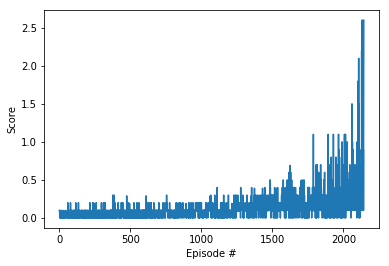

In [14]:
# Standard training session using found hyperparameters or defaults
agent = MasterAgent(num_agents, state_size=state_size, action_size=action_size, seed=0)
session = TrainingSession(num_agents)
scores, _, _ = session.train_ppo(agent, 0.5, max_episodes=10000)   # Do the training

import matplotlib.pyplot as plt
%matplotlib inline
 
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


### Run the Policy
The code below runs the policy that has previously been trained.

In [11]:
session.run_ppo(agent) 

/anaconda2/envs/drlnd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda2/envs/drlnd/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished 1 episodes (2179.0 cycles). best score over agents    0.100 trailing    0.100
Finished 4 episodes (2180.0 cycles). best score over agents    1.200 trailing    0.650
Breaking
Breaking
Finished 5 episodes (2181.0 cycles). best score over agents    1.200 trailing    0.833
Breaking
Policy failed to reach target in 5


In [12]:
env.close()